## Causal Tracing (ROME)

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
} 

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

base = "The Space Needle is in downtown"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The Space Needle is in downtown
_Seattle             0.9763796925544739
_Bellev              0.0027682771906256676
_Portland            0.002157781505957246
,                    0.001514942036010325
_Vancouver           0.0014351324643939734
_San                 0.0013575773919001222
_Minneapolis         0.0009382683783769608
.                    0.0007443437934853137
_Tacoma              0.0006097253644838929
_Los                 0.0005885540740564466


In [5]:
base = "The Space Needle is in downtown"
inputs = tokenizer(base, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {base}")
print(f"Tokens: {tokens}")


Original text: The Space Needle is in downtown
Tokens: ['The', 'ĠSpace', 'ĠNeed', 'le', 'Ġis', 'Ġin', 'Ġdowntown']


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [6]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, num_of_units, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type,):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

In [7]:
num_of_units = 4


Let's check that this reduced the probability of the output "_Seattle".

In [8]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt").to(device)
config = corrupted_config(type(gpt))
intervenable = IntervenableModel(config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Los                 0.032942481338977814
_San                 0.03194469213485718
_Seattle             0.026176391169428825
_Toronto             0.025859203189611435
_Chicago             0.024749061092734337
_Houston             0.024224204942584038
_Atlanta             0.018664492294192314
_Austin              0.017735343426465988
_St                  0.017606759443879128
_Denver              0.01740880496799946


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [9]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [10]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [11]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(7):
            config = restore_corrupted_with_interval_config(
                layer_i, stream, 
                window=1 if stream == "block_output" else 10
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[[0, 1, 2, 3]]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )
            prob = distrib[0][-1][token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

100%|██████████| 48/48 [02:21<00:00,  2.94s/it]


The plot below should now replicate Meng et al.

/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf


<ggplot: (500 x 400)>


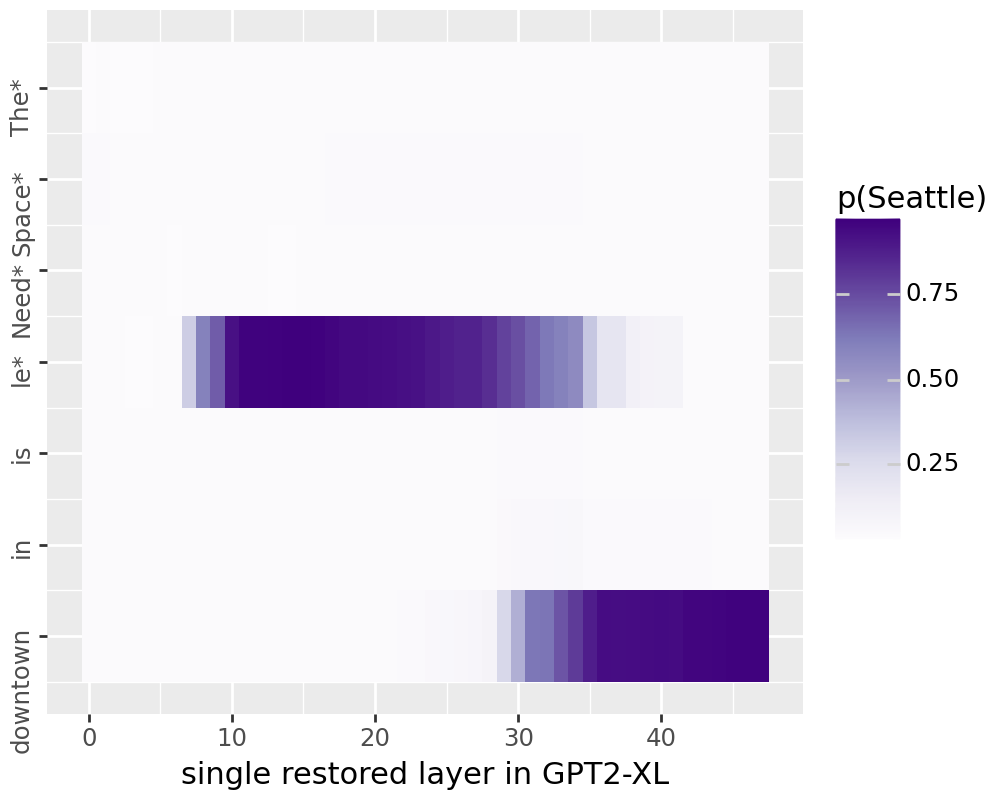

<ggplot: (500 x 400)>


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf


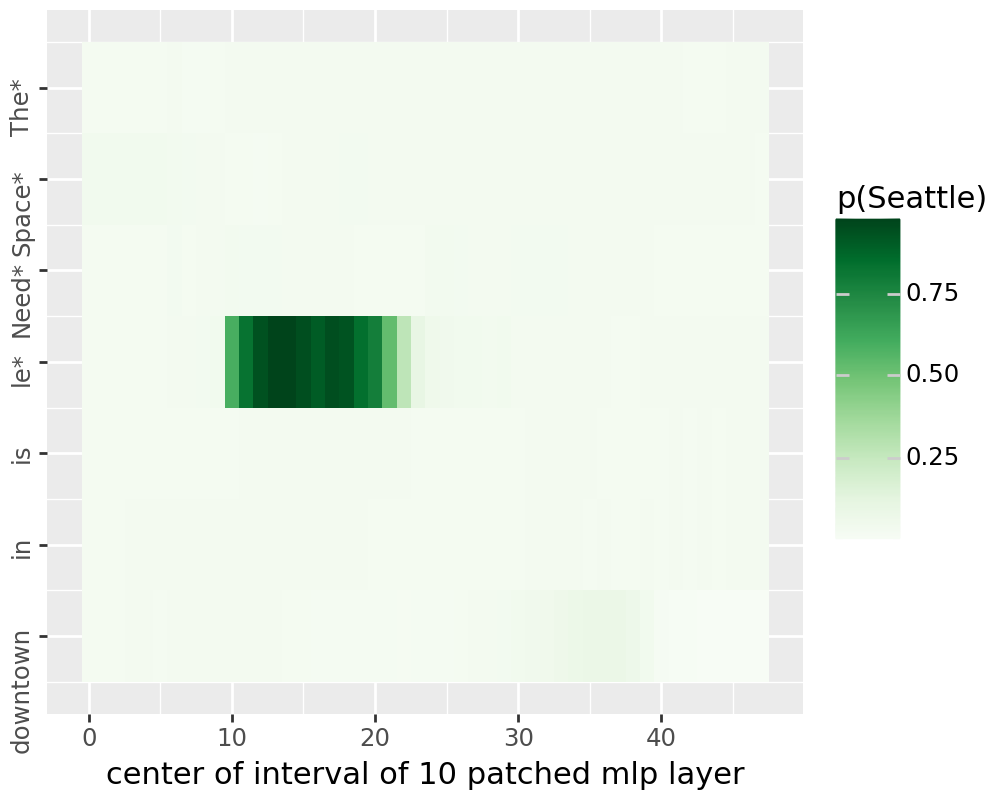

/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf


<ggplot: (500 x 400)>


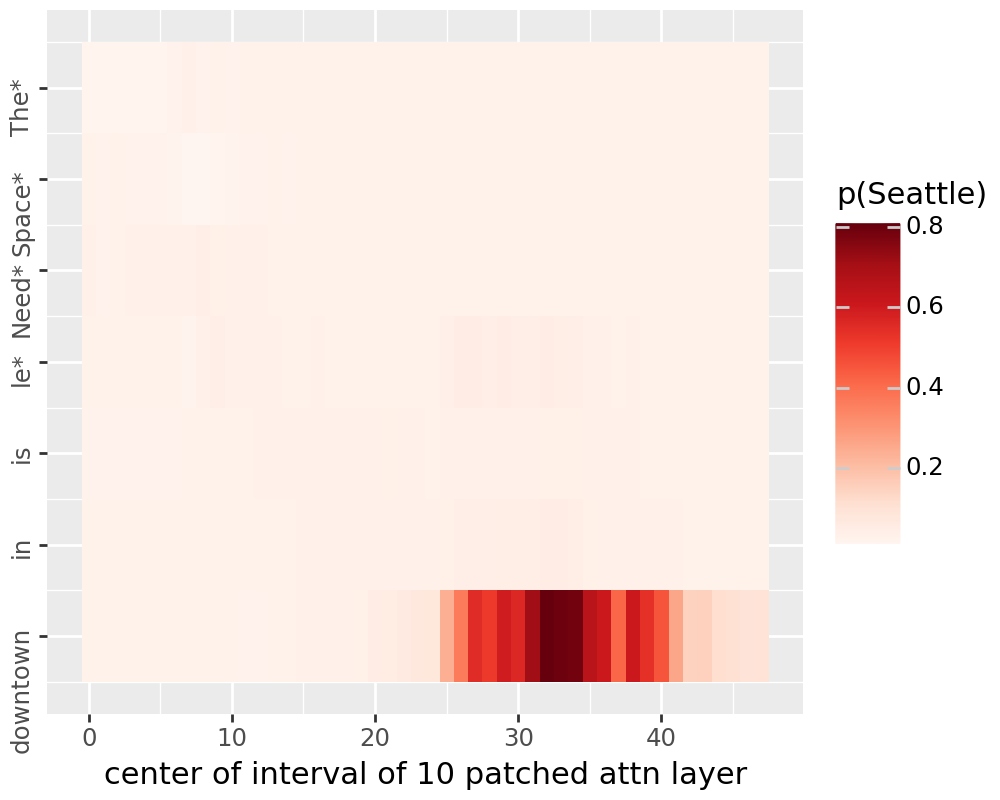

In [12]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)

    custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))    

        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5), 
            breaks=breaks, labels=custom_labels) 
        + theme(figure_size=(5, 4)) + ylab("") 
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    )
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    print(plot)
    plot.show()

# Zadanie

## Zdanie 1

In [13]:
sentence = 'The Big Ben is an iconic symbol of'
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

unit_locations = [0,1,2]
num_of_units = len(unit_locations)


Original text: The Big Ben is an iconic symbol of
Tokens: ['The', 'ĠBig', 'ĠBen', 'Ġis', 'Ġan', 'Ġiconic', 'Ġsymbol', 'Ġof']


In [14]:
def casual_tracing(sentence, unit_locations):

    inputs = [
        tokenizer(sentence, return_tensors="pt").to(device),
    ]
    print(sentence)
    res = gpt(**inputs[0])
    distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
    print('Przed zaszumieniem')
    top_vals(tokenizer, distrib[0][-1], n=10)

    base = tokenizer(sentence, return_tensors="pt").to(device)
    config = corrupted_config(type(gpt))
    intervenable = IntervenableModel(config, gpt)
    _, counterfactual_outputs = intervenable(
        base, unit_locations={"base": ([[unit_locations]])}
    )
    distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
    print('Po zaszumieniu')
    top_vals(tokenizer, distrib[0][-1], n=10)


In [15]:
casual_tracing(sentence, unit_locations)

The Big Ben is an iconic symbol of
Przed zaszumieniem
_London              0.5511884093284607
_England             0.14494159817695618
_the                 0.12119162082672119
_Britain             0.04161534830927849
_British             0.017686942592263222
_Great               0.012019661255180836
_English             0.009544339030981064
_our                 0.008008318021893501
_Westminster         0.006579796317964792
_a                   0.003550471505150199
Po zaszumieniu
_the                 0.29190024733543396
_a                   0.01933019794523716
_our                 0.017718806862831116
_New                 0.01614392362535
_American            0.01544490922242403
_modern              0.010372677817940712
_America             0.008816767483949661
_all                 0.006909290794283152
_this                0.005376383196562529
_British             0.0053270780481398106


In [16]:
token = tokenizer.encode(" London")[0]
print(token)

3576


In [17]:

def plot(token, name, file_name, custom_labels, unit_locations):
    for stream in ["block_output", "mlp_activation", "attention_output"]:
        data = []
        for layer_i in tqdm(range(gpt.config.n_layer)):
            for pos_i in range(len(tokens)):
                config = restore_corrupted_with_interval_config(
                    layer_i, stream, 
                    window=1 if stream == "block_output" else 10
                )
                n_restores = len(config.representations) - 1
                intervenable = IntervenableModel(config, gpt)
                _, counterfactual_outputs = intervenable(
                    base,
                    [None] + [base]*n_restores,
                    {
                        "sources->base": (
                            [None] + [[[pos_i]]]*n_restores,
                            [[unit_locations]] + [[[pos_i]]]*n_restores,
                        )
                    },
                )
                distrib = embed_to_distrib(
                    gpt, counterfactual_outputs.last_hidden_state, logits=False
                )
                prob = distrib[0][-1][token].detach().cpu().item()
                data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
        df = pd.DataFrame(data)
        df.to_csv(f"./data/gptxl/{file_name}_{stream}.csv")

    for stream in ["block_output", "mlp_activation", "attention_output"]:
            df = pd.read_csv(f"./data/gptxl/{file_name}_{stream}.csv")
            df["layer"] = df["layer"].astype(int)
            df["pos"] = df["pos"].astype(int)
            df[name] = df["prob"].astype(float)


            breaks = [i for i in range(len(custom_labels))]
            print(breaks)

            plot = (
                ggplot(df, aes(x="layer", y="pos"))    

                + geom_tile(aes(fill=name))
                + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
                + scale_y_reverse(
                    limits = (-0.5, 6.5), 
                    breaks=breaks, labels=custom_labels) 
                + theme(figure_size=(10, 10)) + ylab("") 
                + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
            )
            ggsave(
                plot, filename=f"./data/gptxl/{file_name}_{stream}.pdf", dpi=200
            )
            plot.show()


  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [02:35<00:00,  3.23s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent1_block_output.pdf
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.


[0, 1, 2, 3, 4, 5, 6, 7]


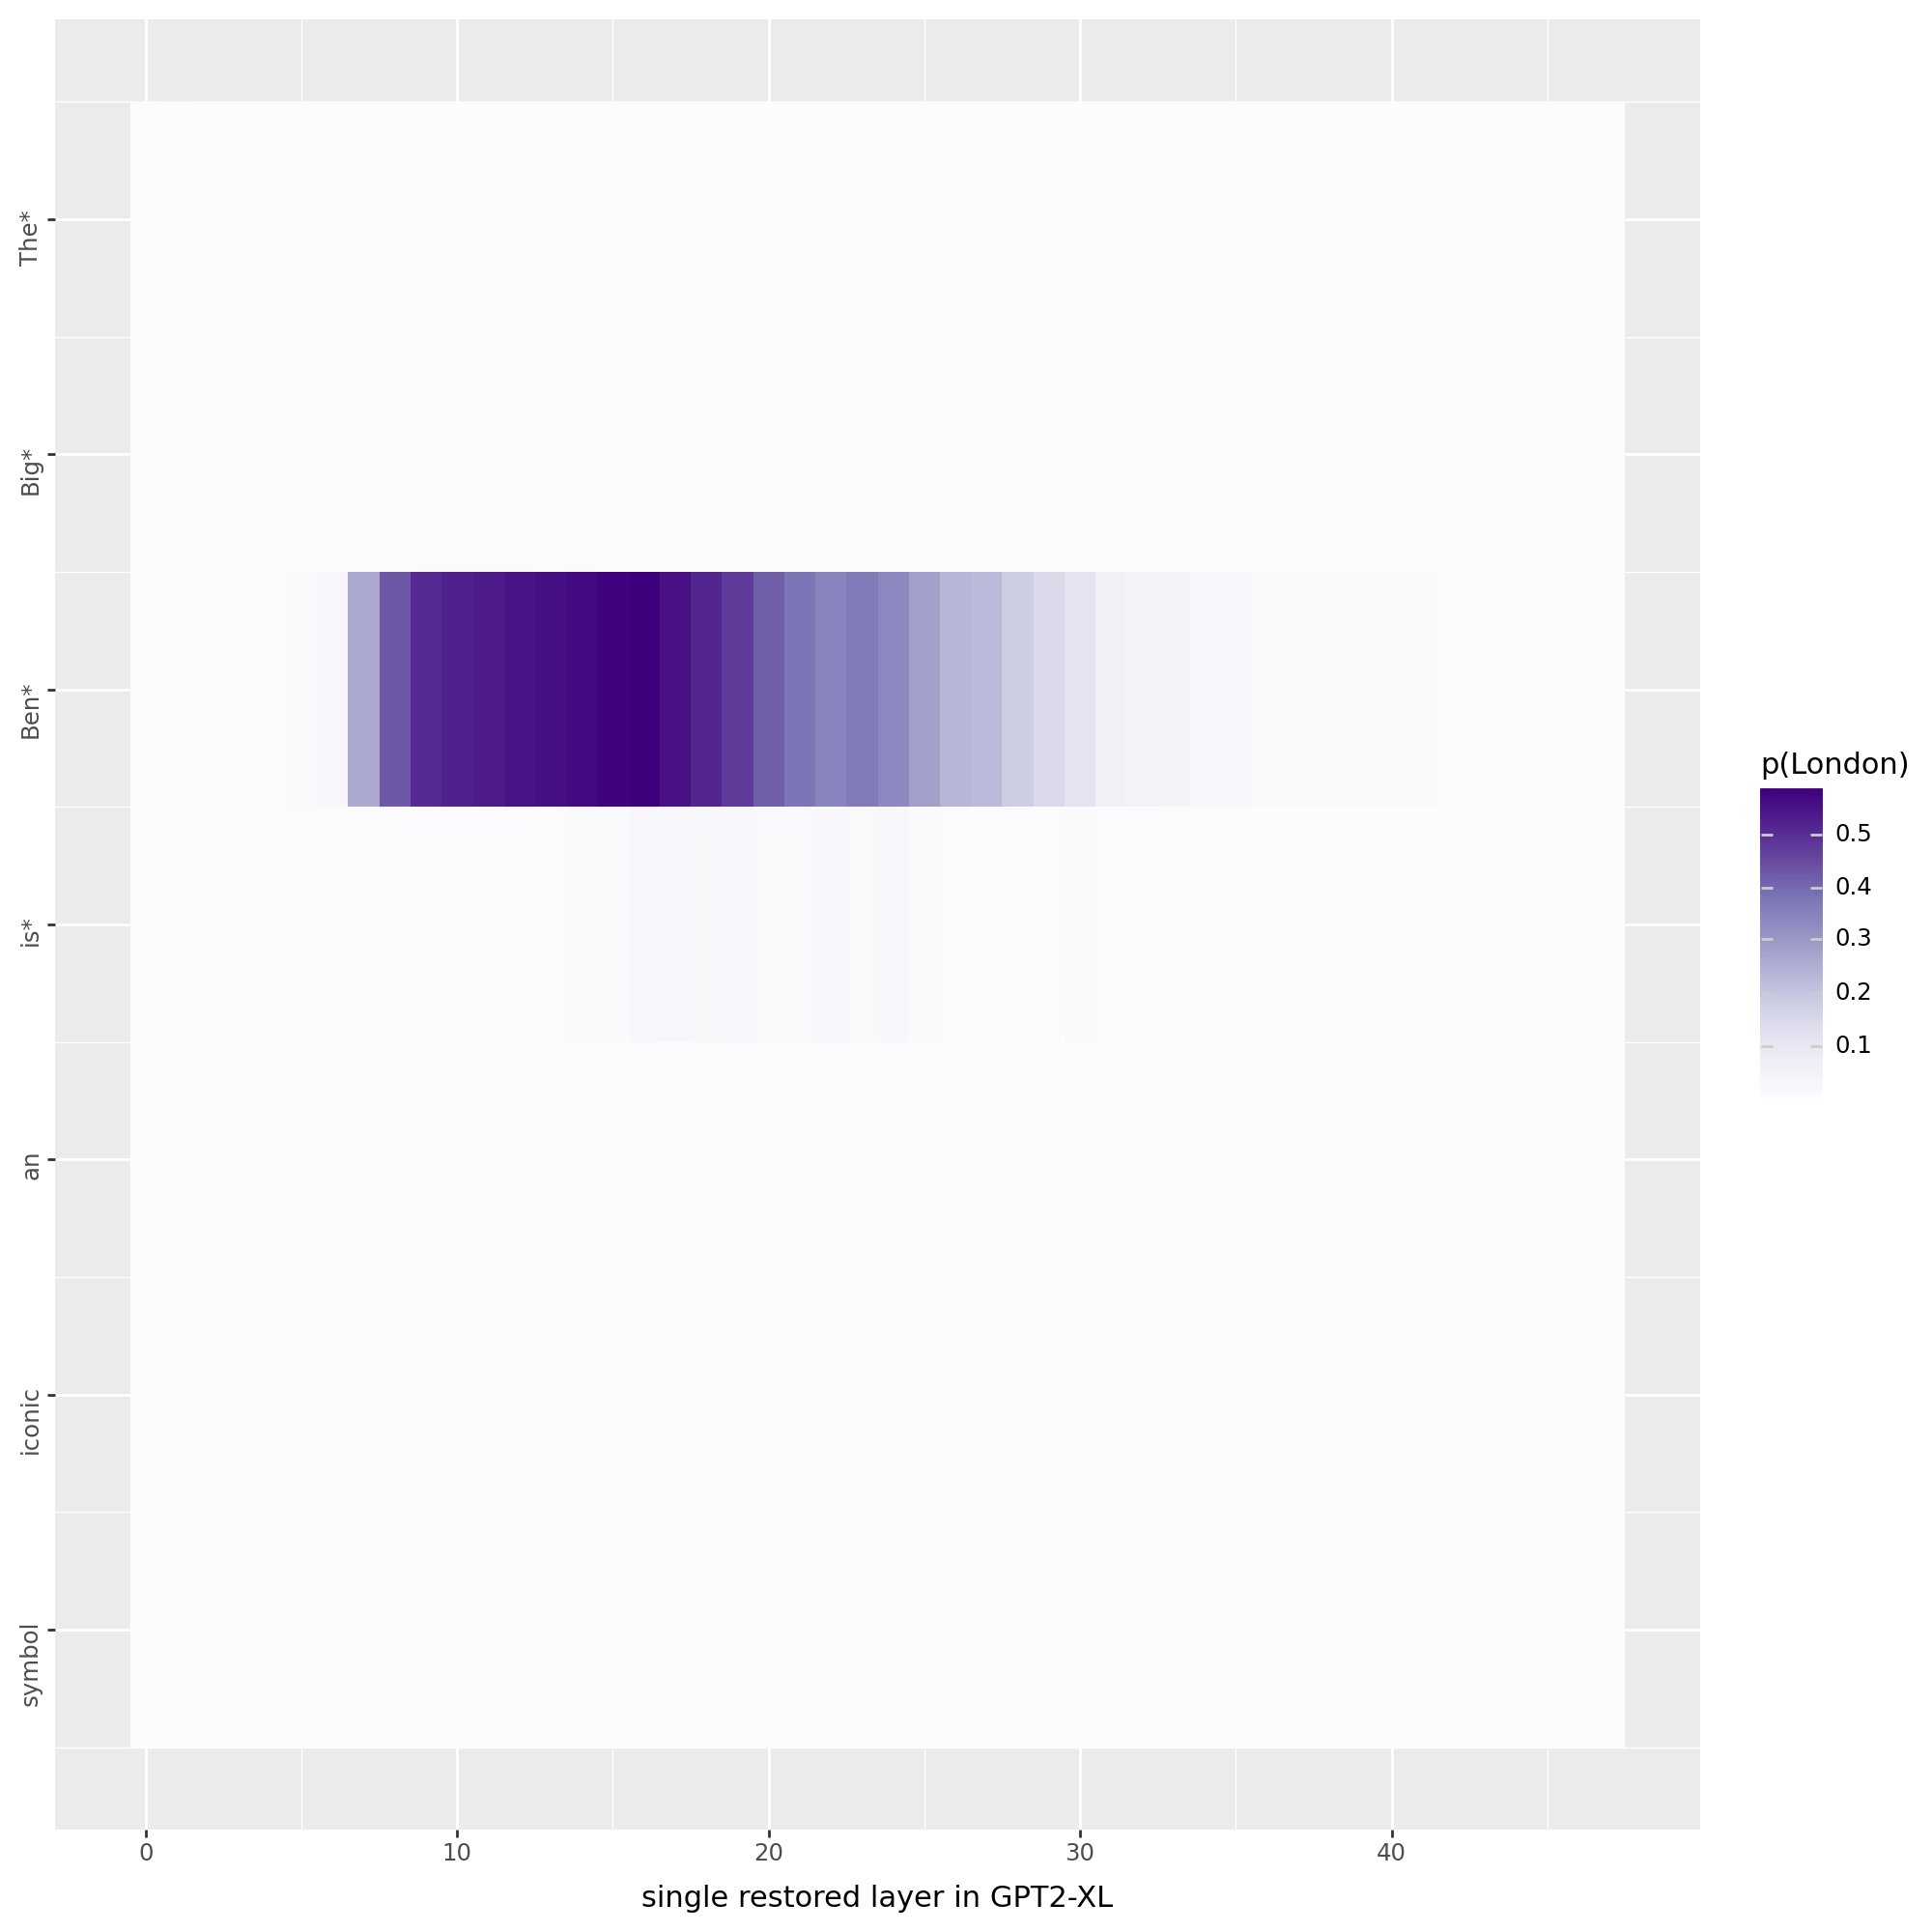

[0, 1, 2, 3, 4, 5, 6, 7]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent1_mlp_activation.pdf
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.


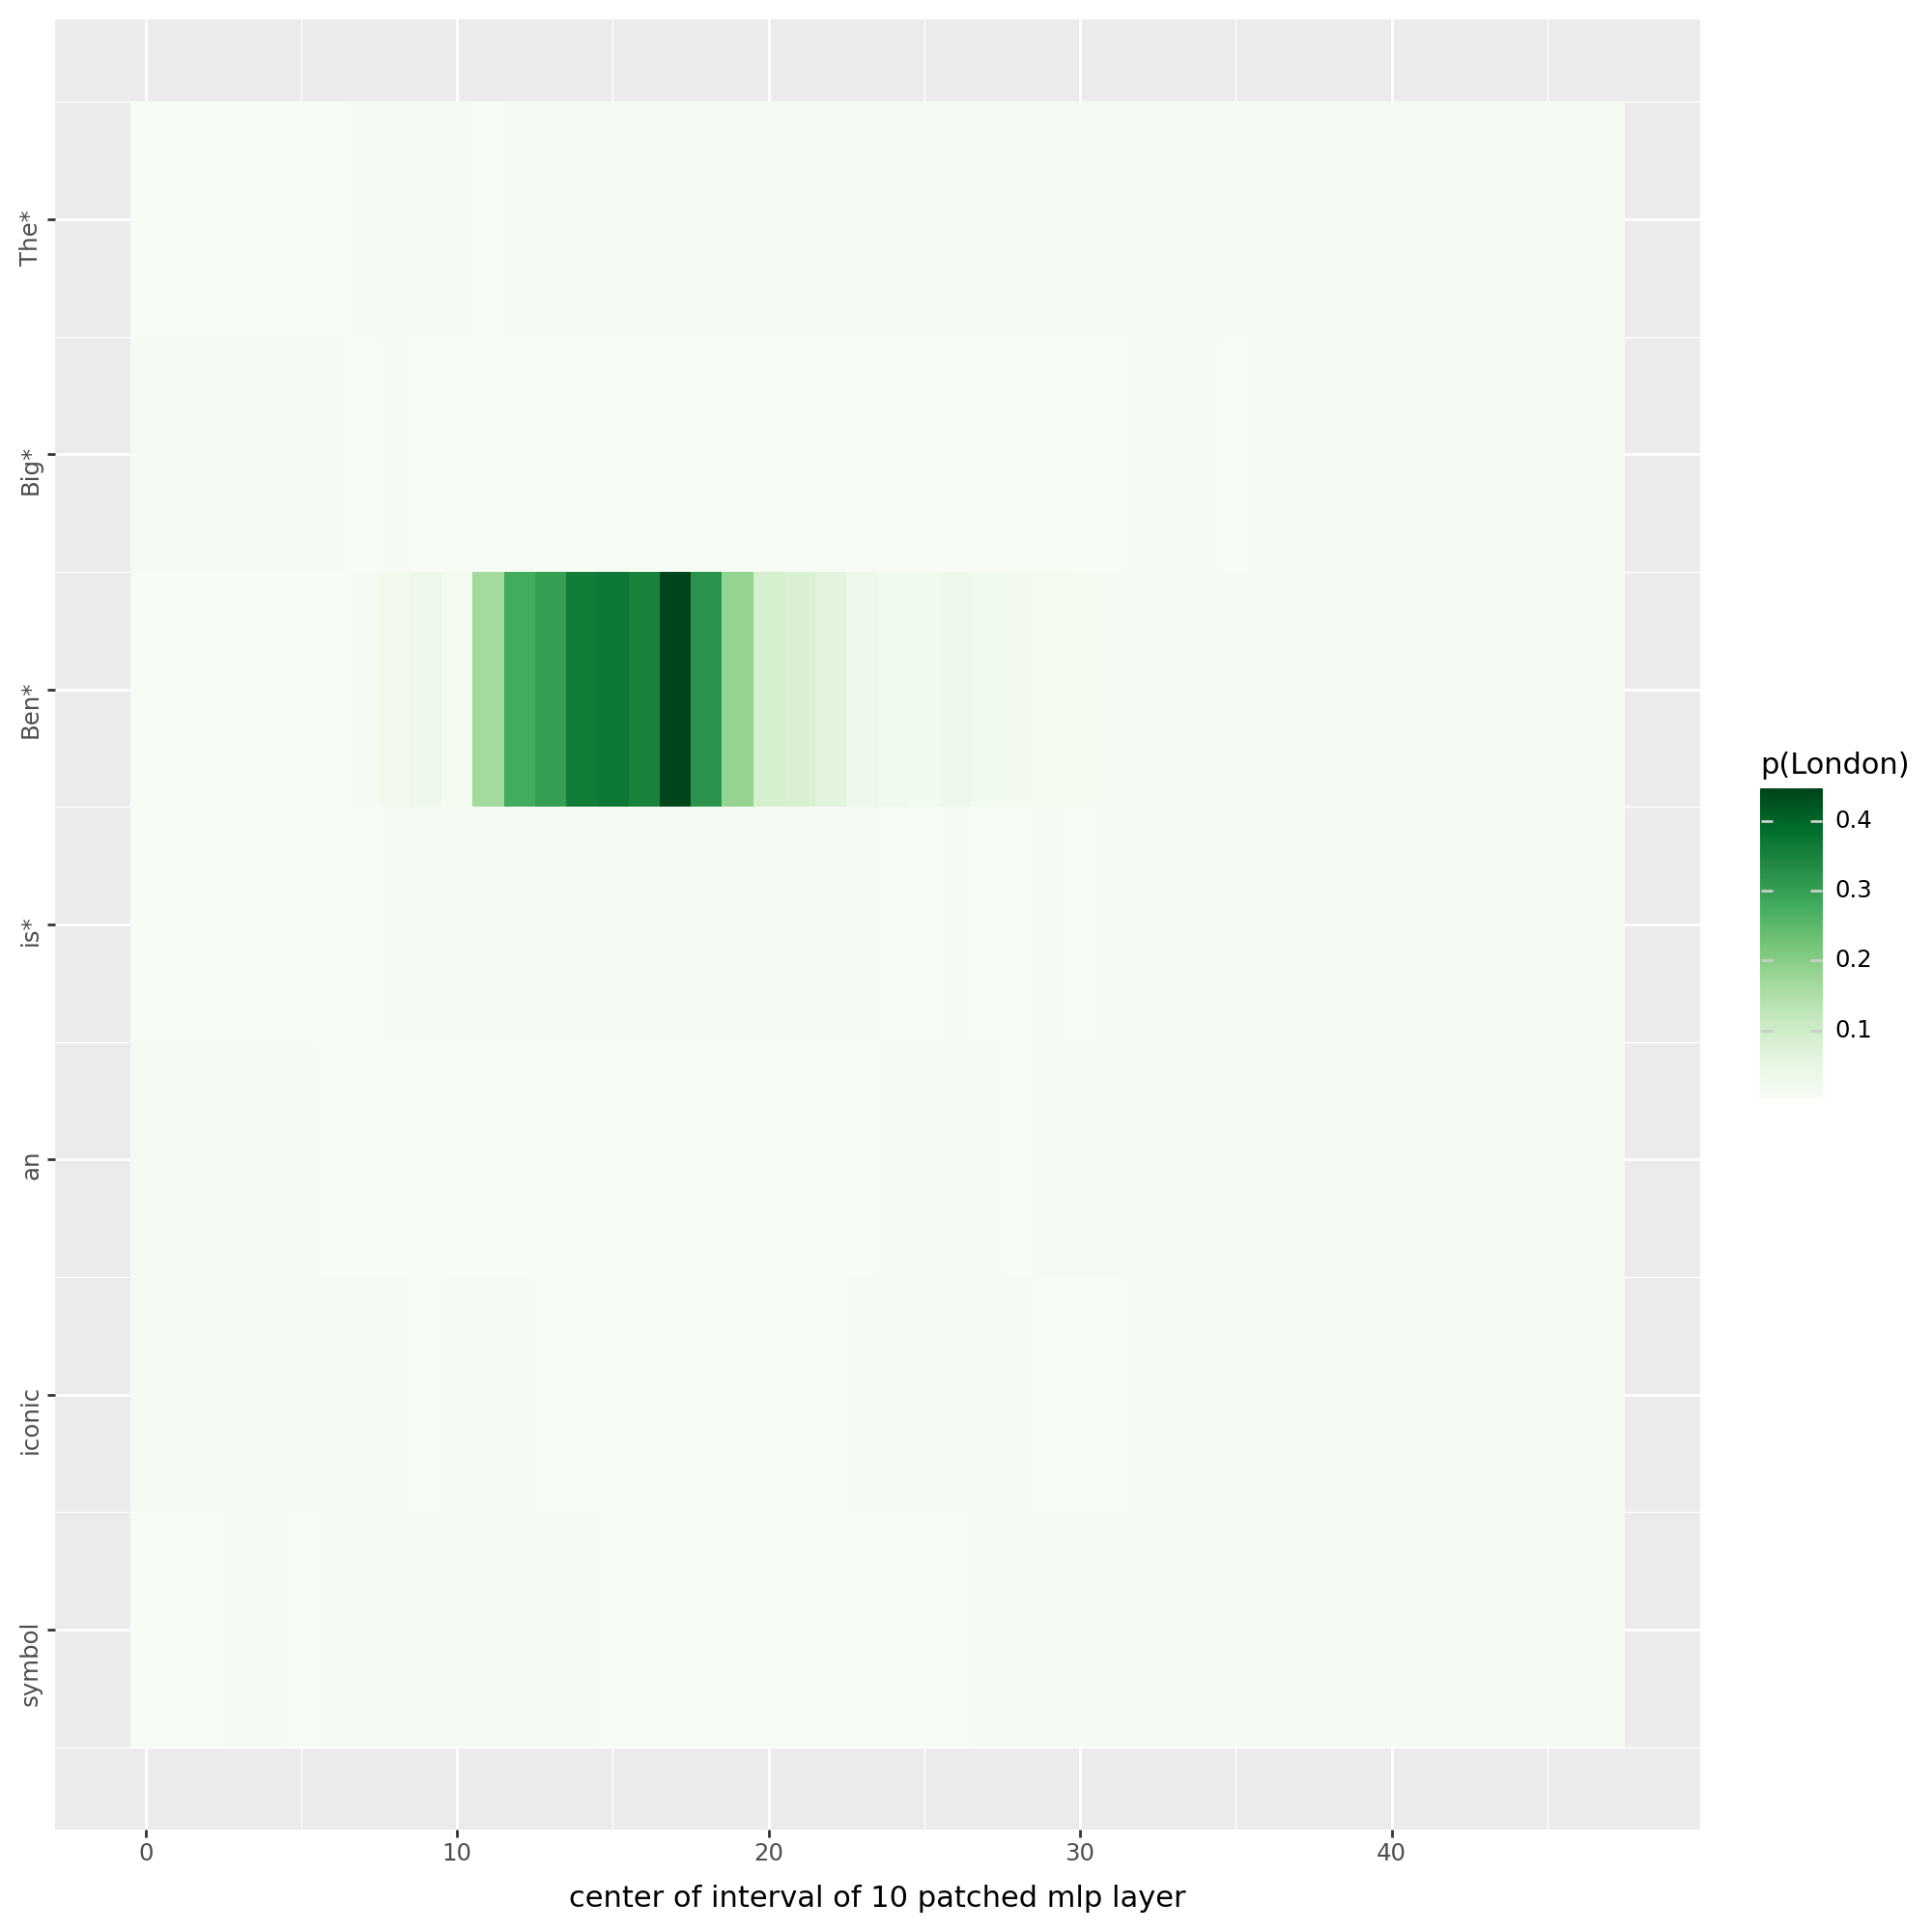

[0, 1, 2, 3, 4, 5, 6, 7]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent1_attention_output.pdf
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_tile : Removed 48 rows containing missing values.


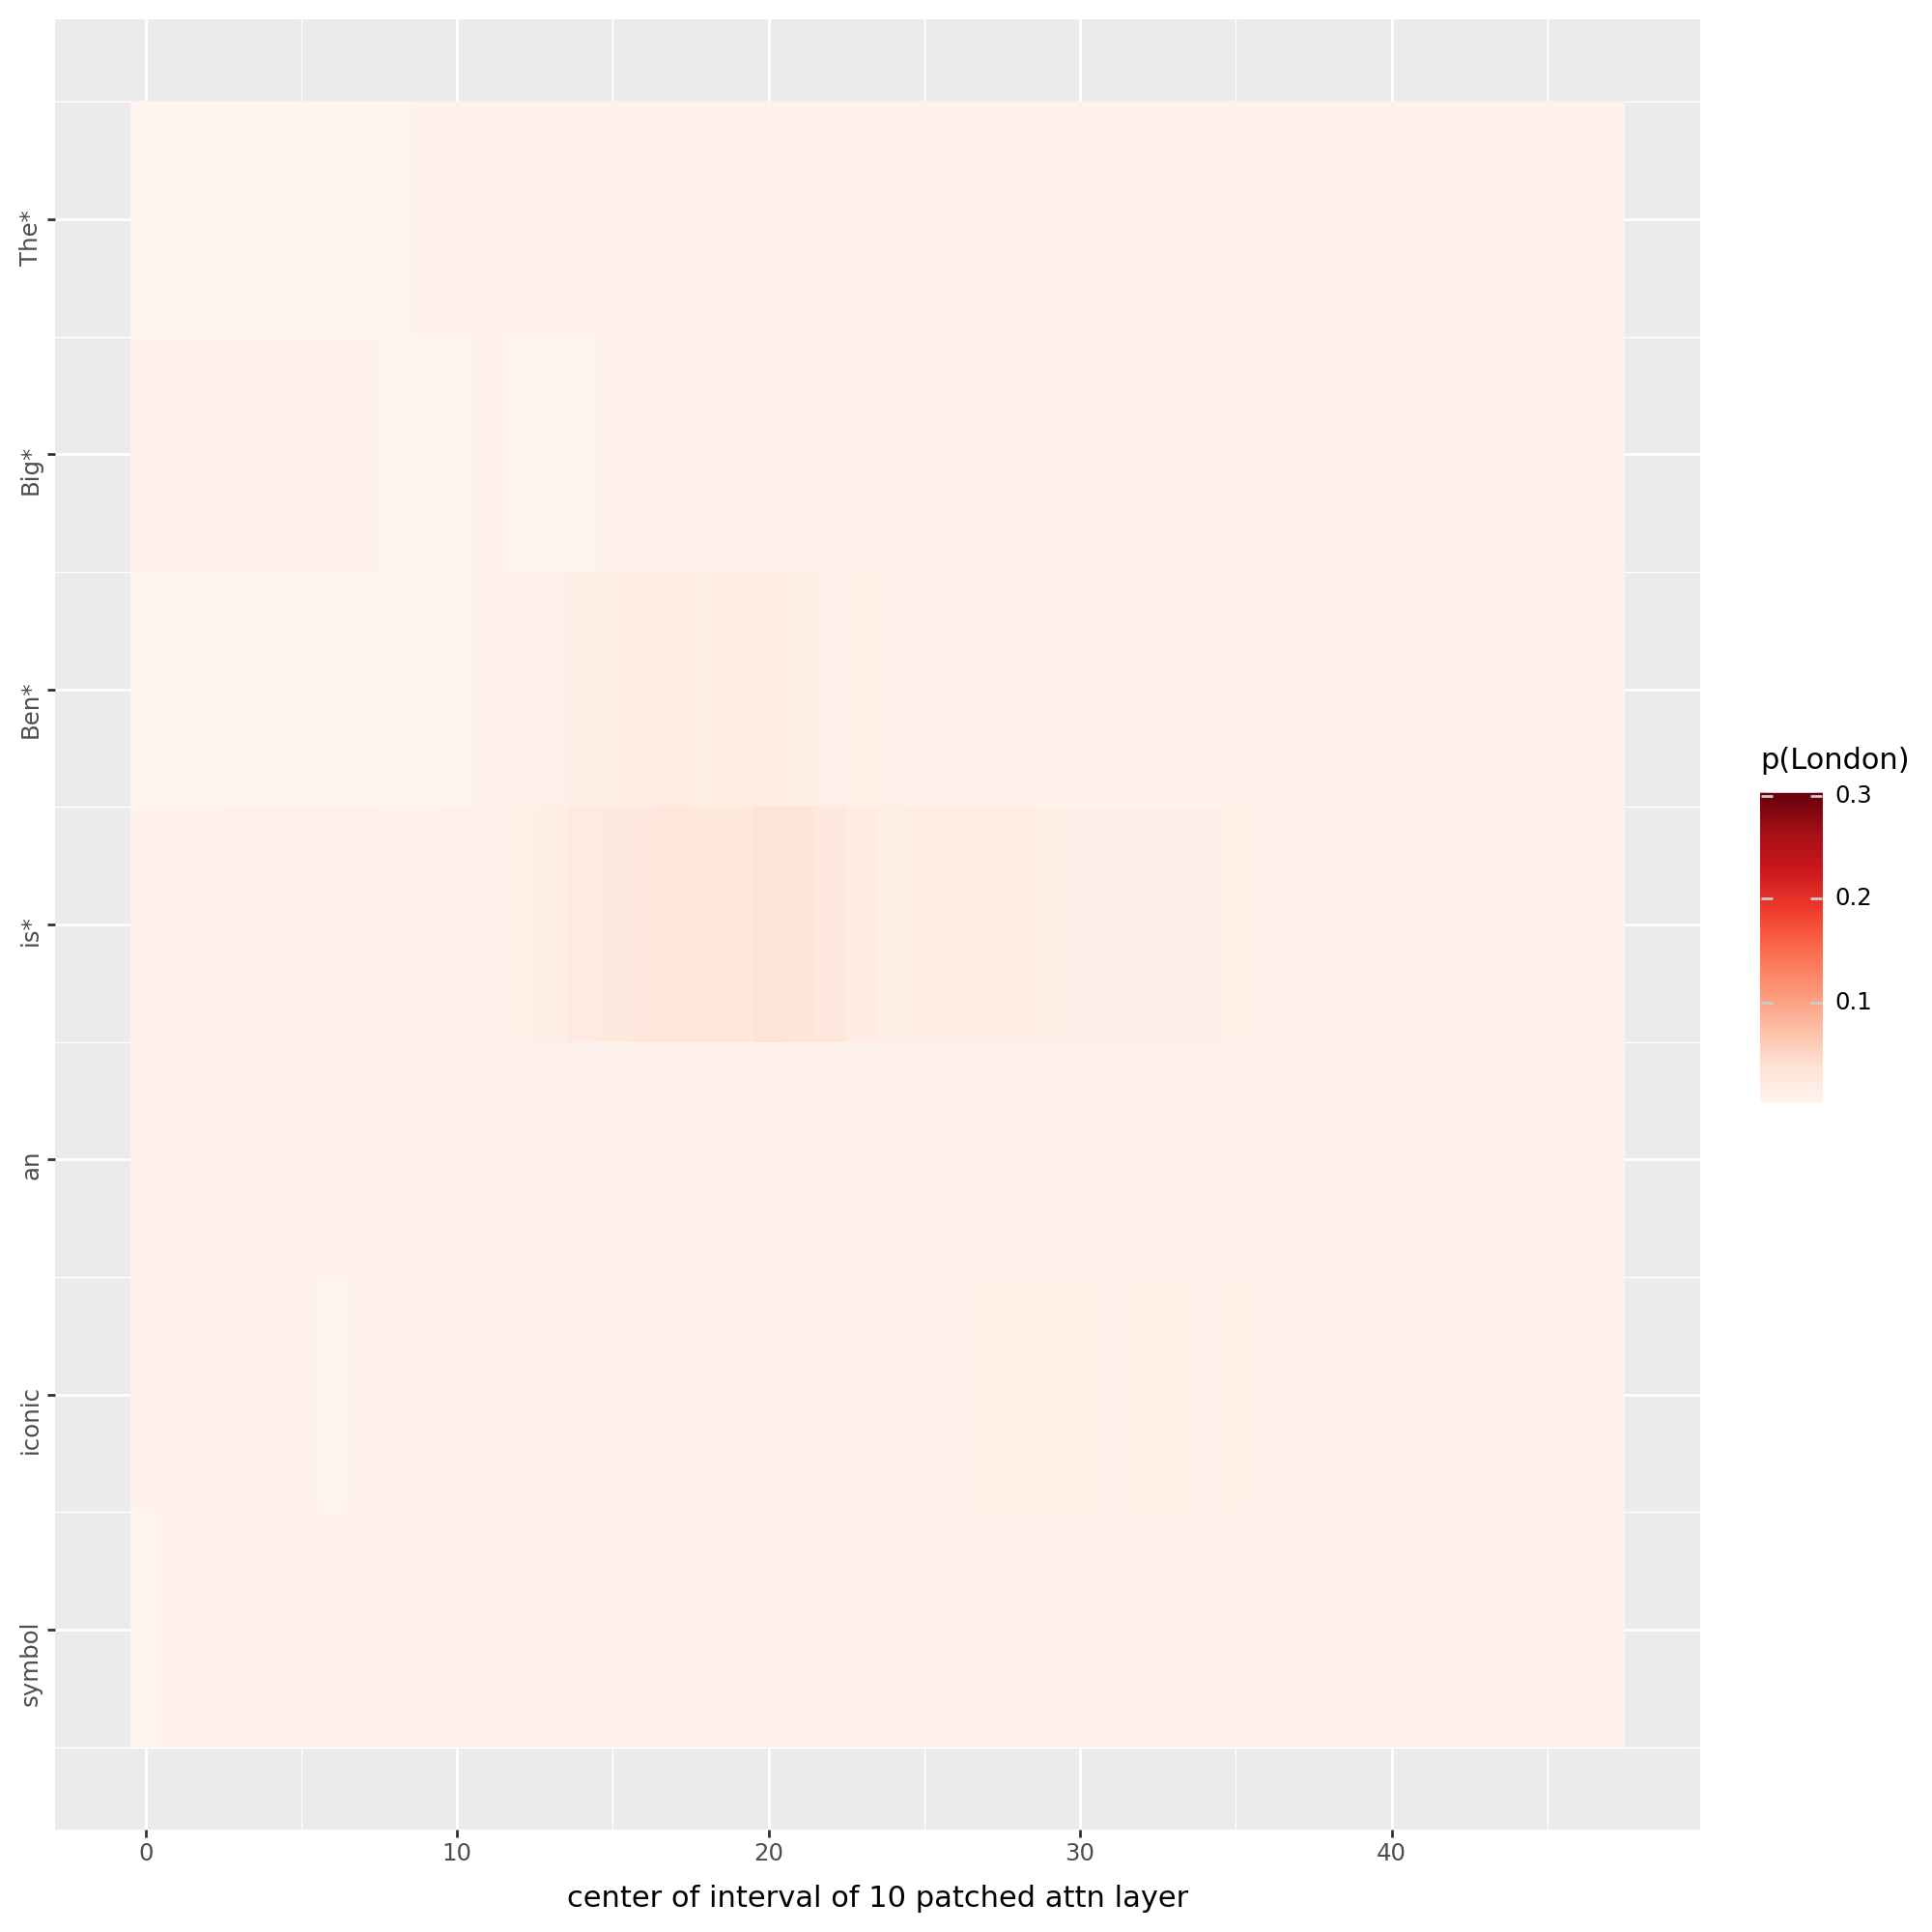

In [18]:
file_name = 'sent1'
name = "p(London)"
custom_labels = ["The*", "Big*", "Ben*", "is*", "an", "iconic", "symbol", "of"]
token = tokenizer.encode(" London")[0]
base = tokenizer(sentence, return_tensors="pt").to(device)

plot(token, name, file_name, custom_labels, unit_locations)

# Zdanie 2

In [19]:
sentence  = "Aleksander Graham Bell invented the"
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

Original text: Aleksander Graham Bell invented the
Tokens: ['Ale', 'ks', 'ander', 'ĠGraham', 'ĠBell', 'Ġinvented', 'Ġthe']


In [20]:
unit_locations = [0,1,2,4,5]
num_of_units = len(unit_locations)

In [21]:
casual_tracing(sentence, unit_locations)

Aleksander Graham Bell invented the
Przed zaszumieniem
_telephone           0.5032839775085449
_first               0.07193245738744736
_transistor          0.0482906848192215
_radio               0.04622647538781166
_Bell                0.018263451755046844
_phon                0.017184285447001457
_te                  0.017137430608272552
_electric            0.012791583314538002
_bell                0.010008404031395912
_modern              0.008579620160162449
Po zaszumieniu
_great               0.018691616132855415
_first               0.01812604069709778
_Great               0.014504171907901764
_greatest            0.01009869109839201
_world               0.008954815566539764
_most                0.008366753347218037
_king                0.008191774599254131
_best                0.008029084652662277
_last                0.007866616360843182
_man                 0.006282457150518894


In [22]:
token = tokenizer.encode(" telephone")[0]
print(token)

11426


100%|██████████| 48/48 [02:21<00:00,  2.95s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent2_block_output.pdf


[0, 1, 2, 3, 4, 5, 6]


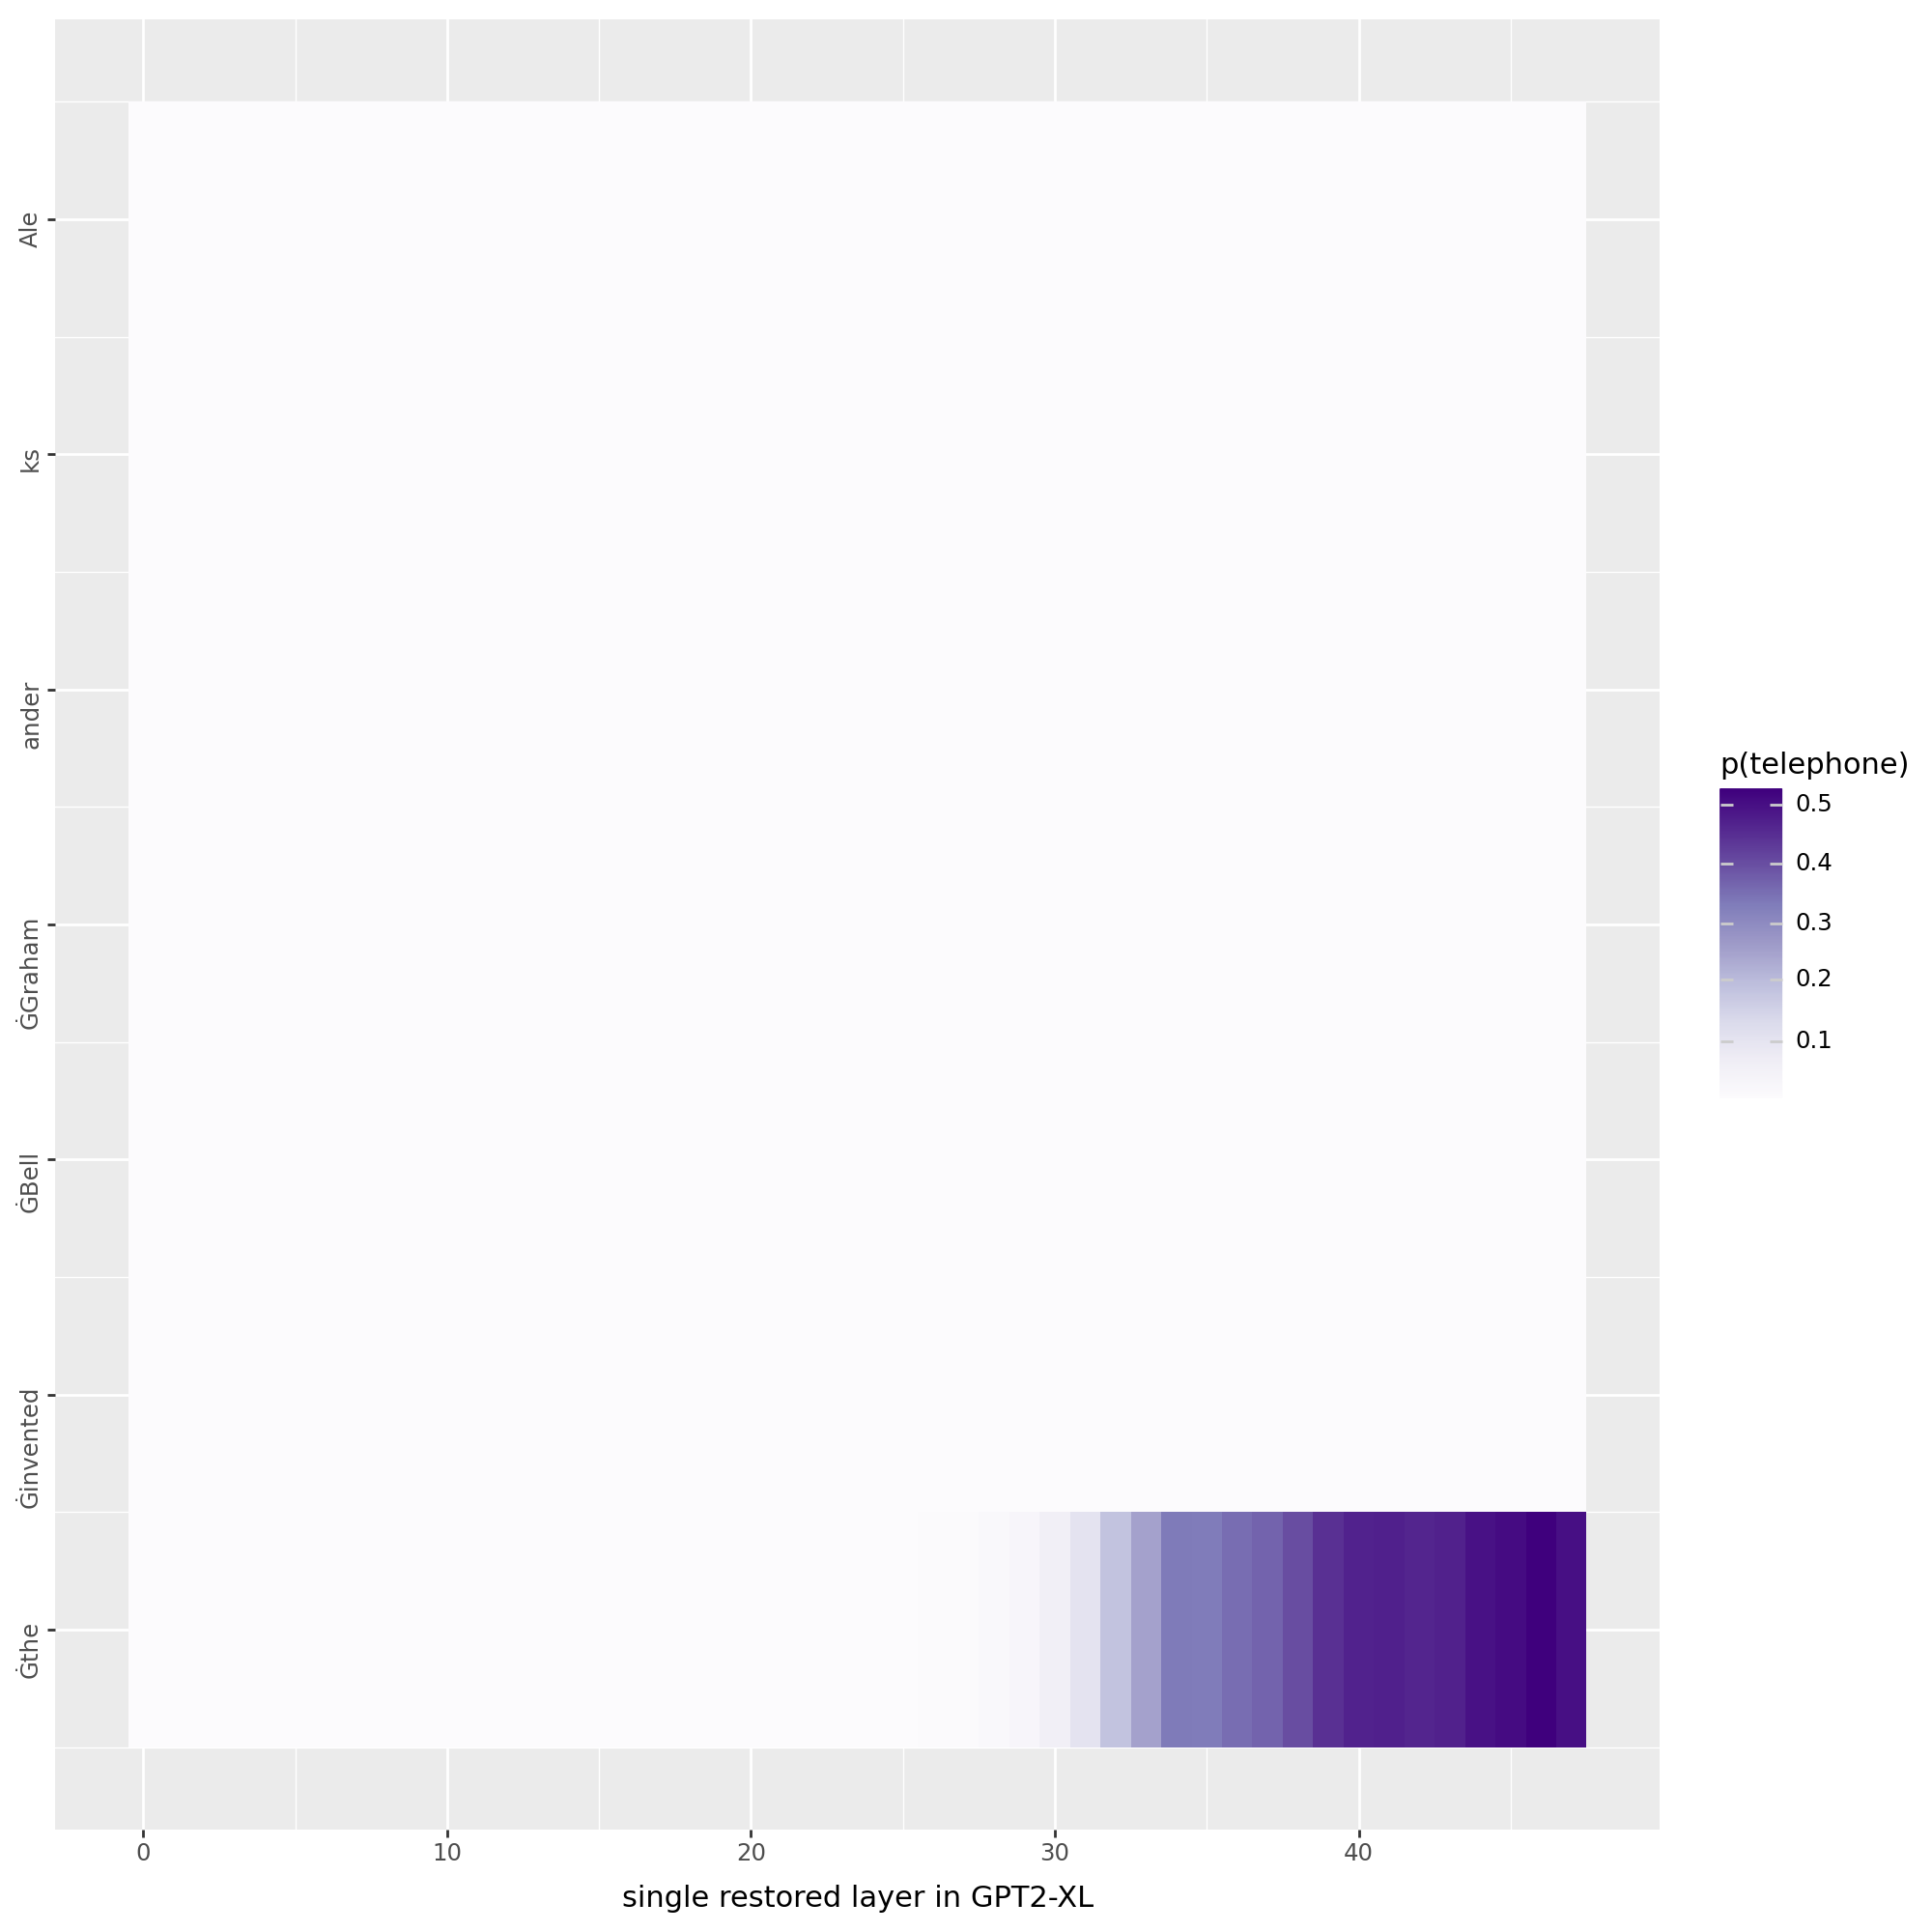

[0, 1, 2, 3, 4, 5, 6]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent2_mlp_activation.pdf


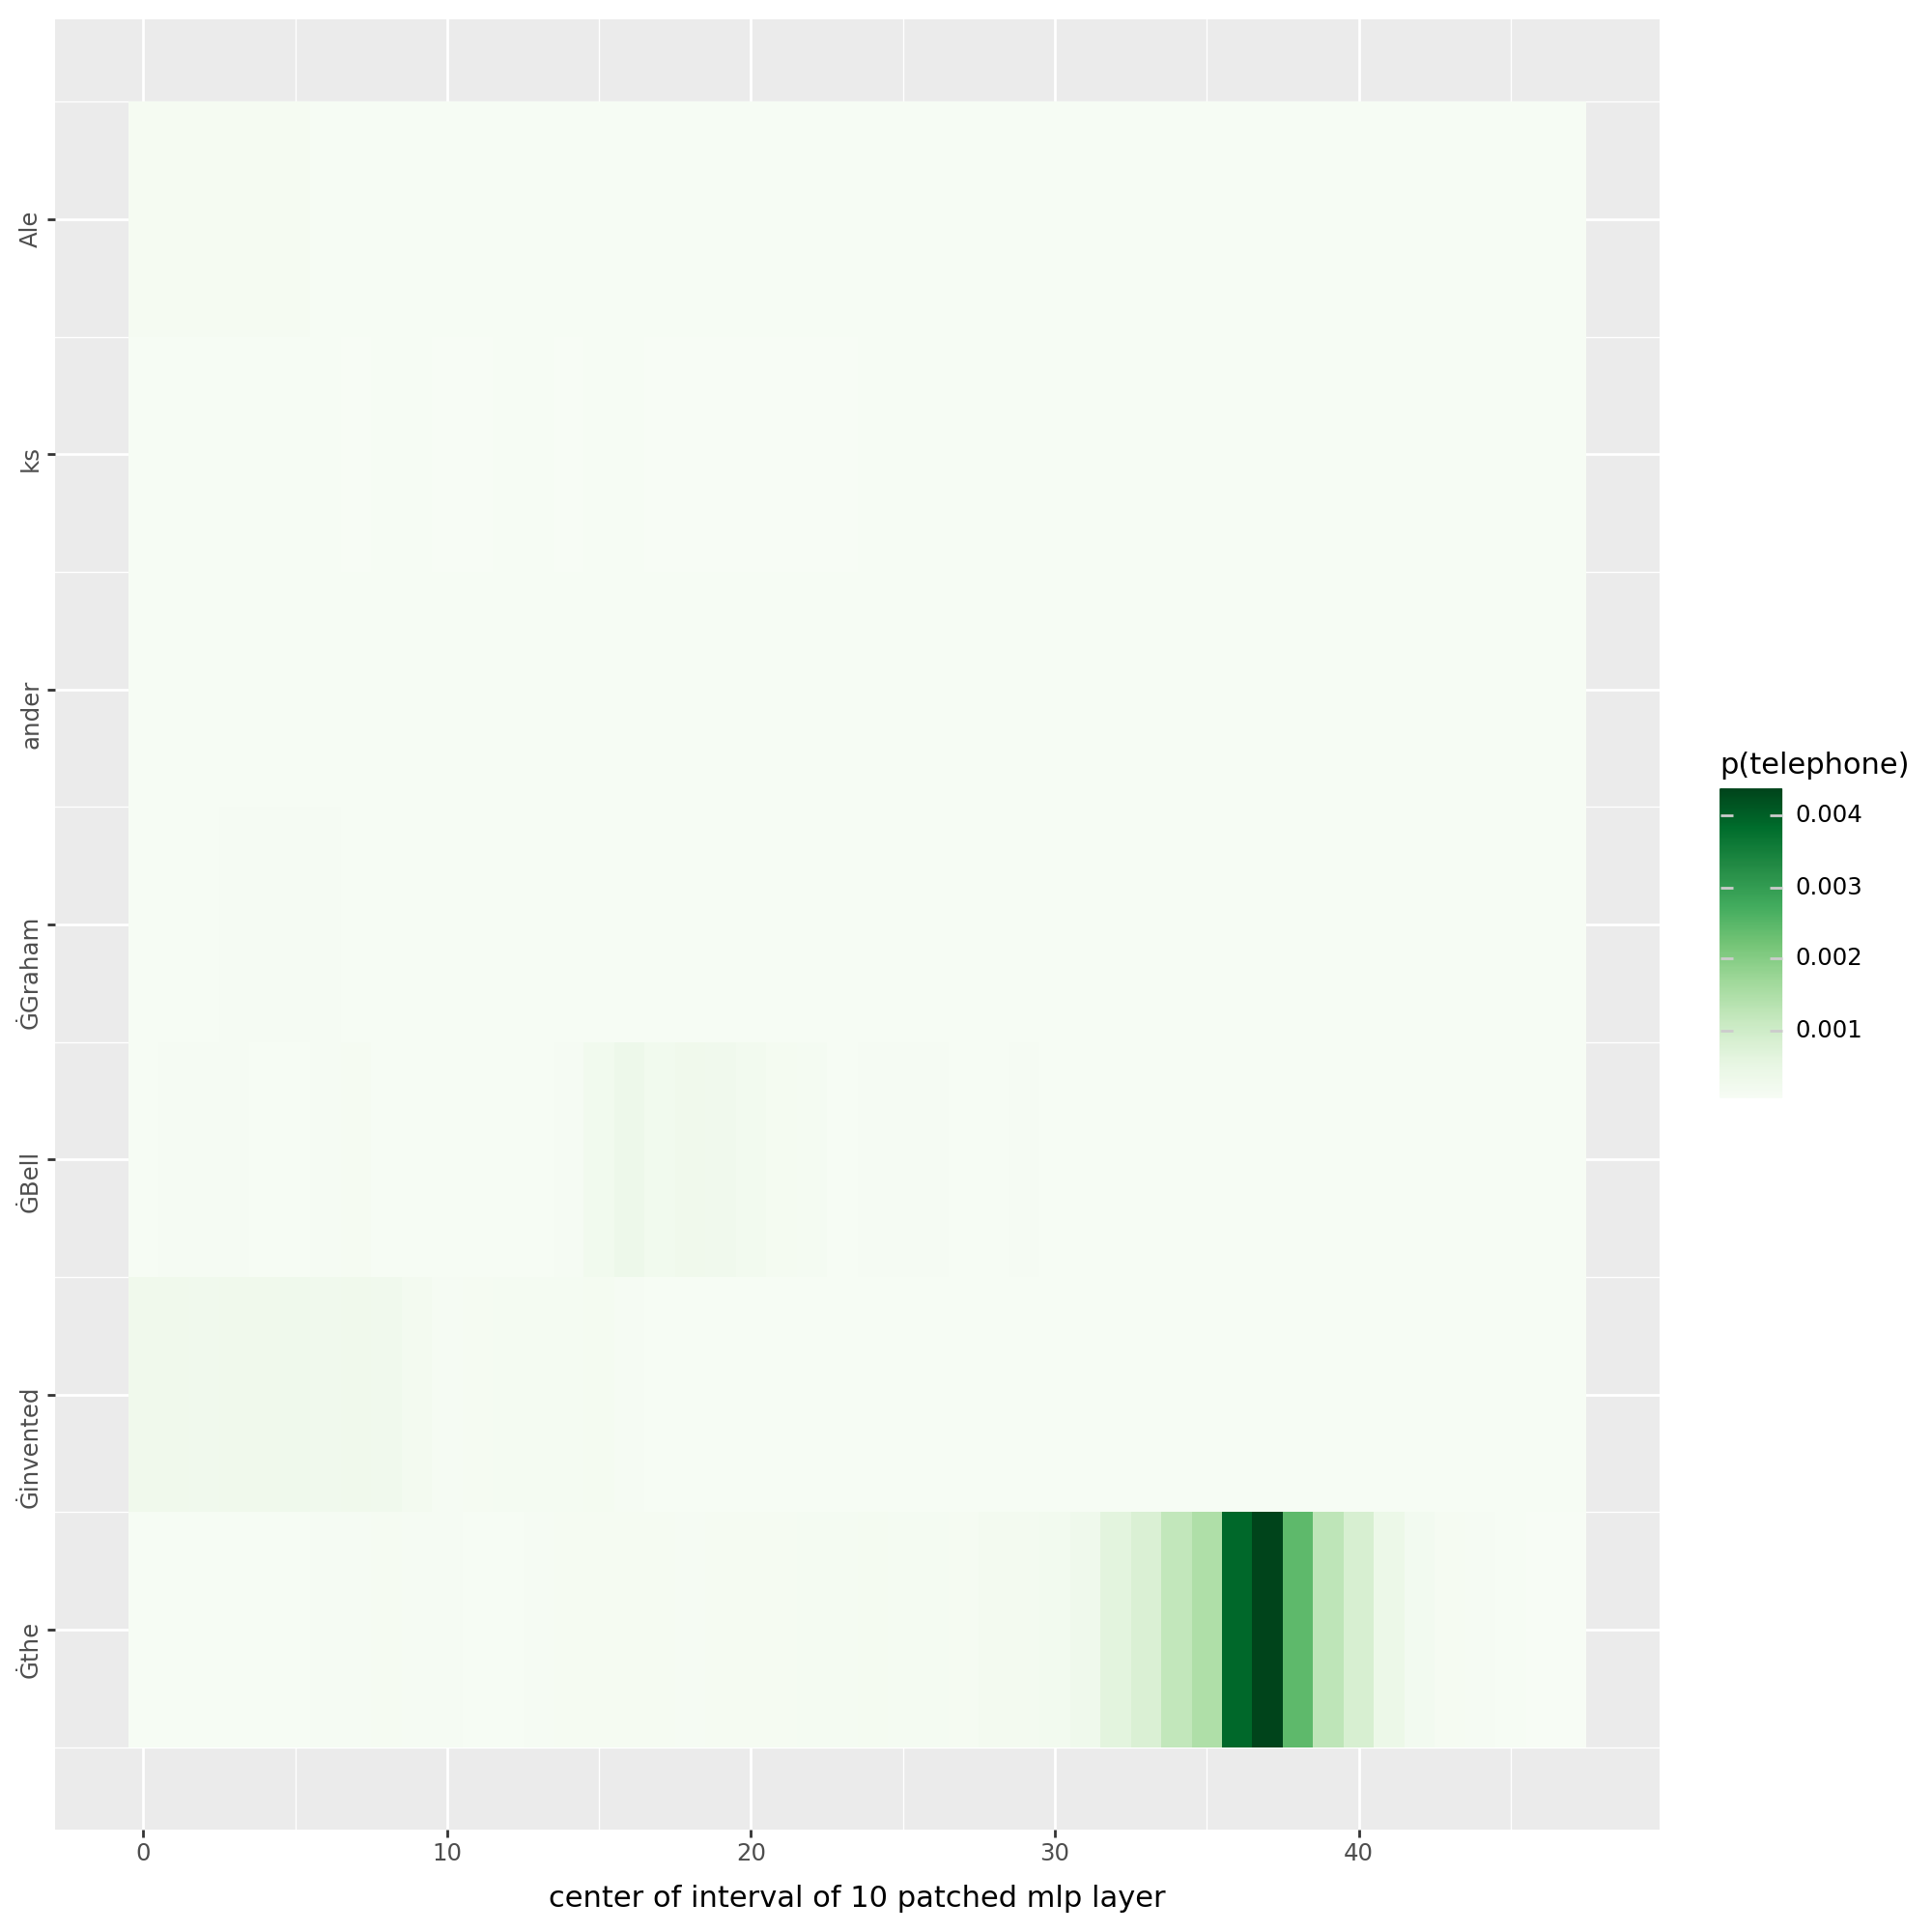

[0, 1, 2, 3, 4, 5, 6]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent2_attention_output.pdf


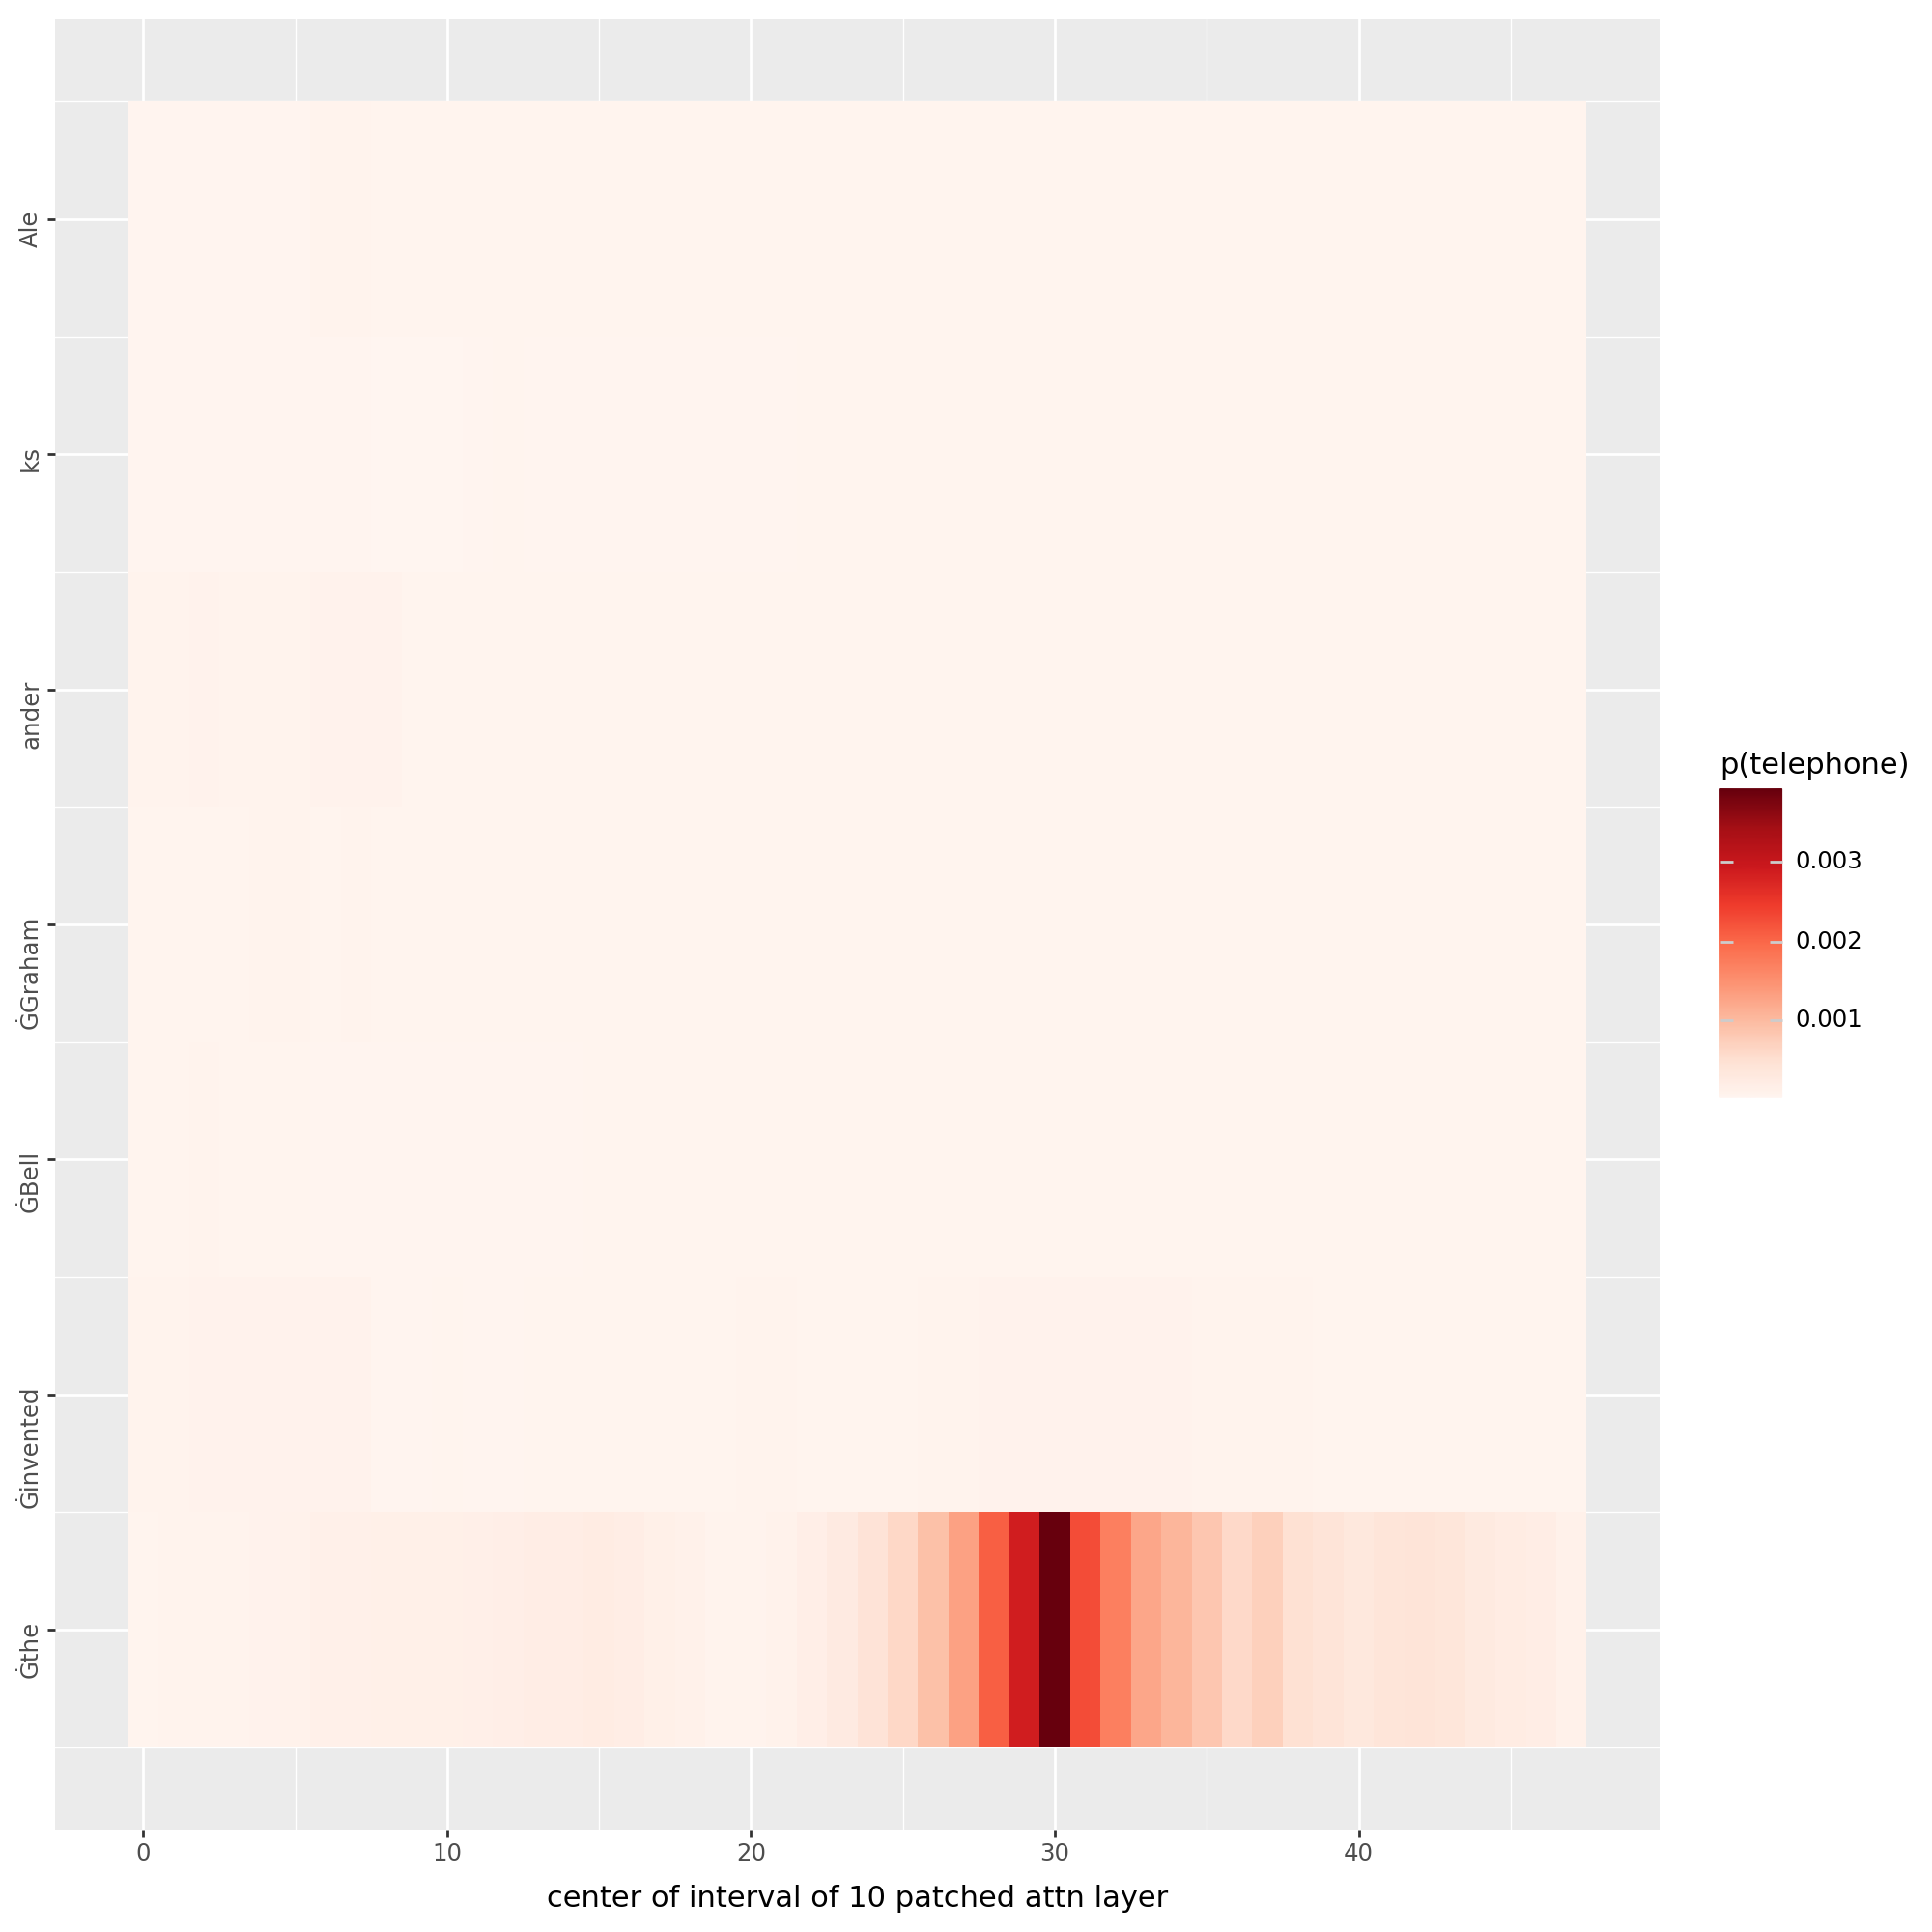

In [23]:
file_name = 'sent2'
name = "p(telephone)"
custom_labels = tokens
token = tokenizer.encode(" telephone")[0]
base = tokenizer(sentence, return_tensors="pt").to(device)

plot(token, name, file_name, custom_labels, unit_locations)

# Zdanie 3

In [24]:
sentence = 'The Earth revolves around the'
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

Original text: The Earth revolves around the
Tokens: ['The', 'ĠEarth', 'Ġrevolves', 'Ġaround', 'Ġthe']


In [25]:
unit_locations = [0,1]
num_of_units = len(unit_locations)

In [26]:
casual_tracing(sentence, unit_locations)

The Earth revolves around the
Przed zaszumieniem
_Sun                 0.6345247626304626
_sun                 0.36269816756248474
_Moon                0.00048480366240255535
_star                0.0004807346558663994
_center              0.0003976724692620337
_stars               0.00015477946726605296
_moon                0.0001465003442717716
_solar               7.31122272554785e-05
_Earth               7.273321534739807e-05
_North               3.889309664373286e-05
Po zaszumieniu
_idea                0.06619809567928314
_concept             0.029620034620165825
_fact                0.02957834303379059
_question            0.024088500067591667
_notion              0.013014166615903378
_"                   0.010675626806914806
_same                0.009253984317183495
_issue               0.007354232016950846
_following           0.006155236158519983
_theme               0.005597694311290979


100%|██████████| 48/48 [01:29<00:00,  1.87s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent23_block_output.pdf


[0, 1, 2, 3, 4]


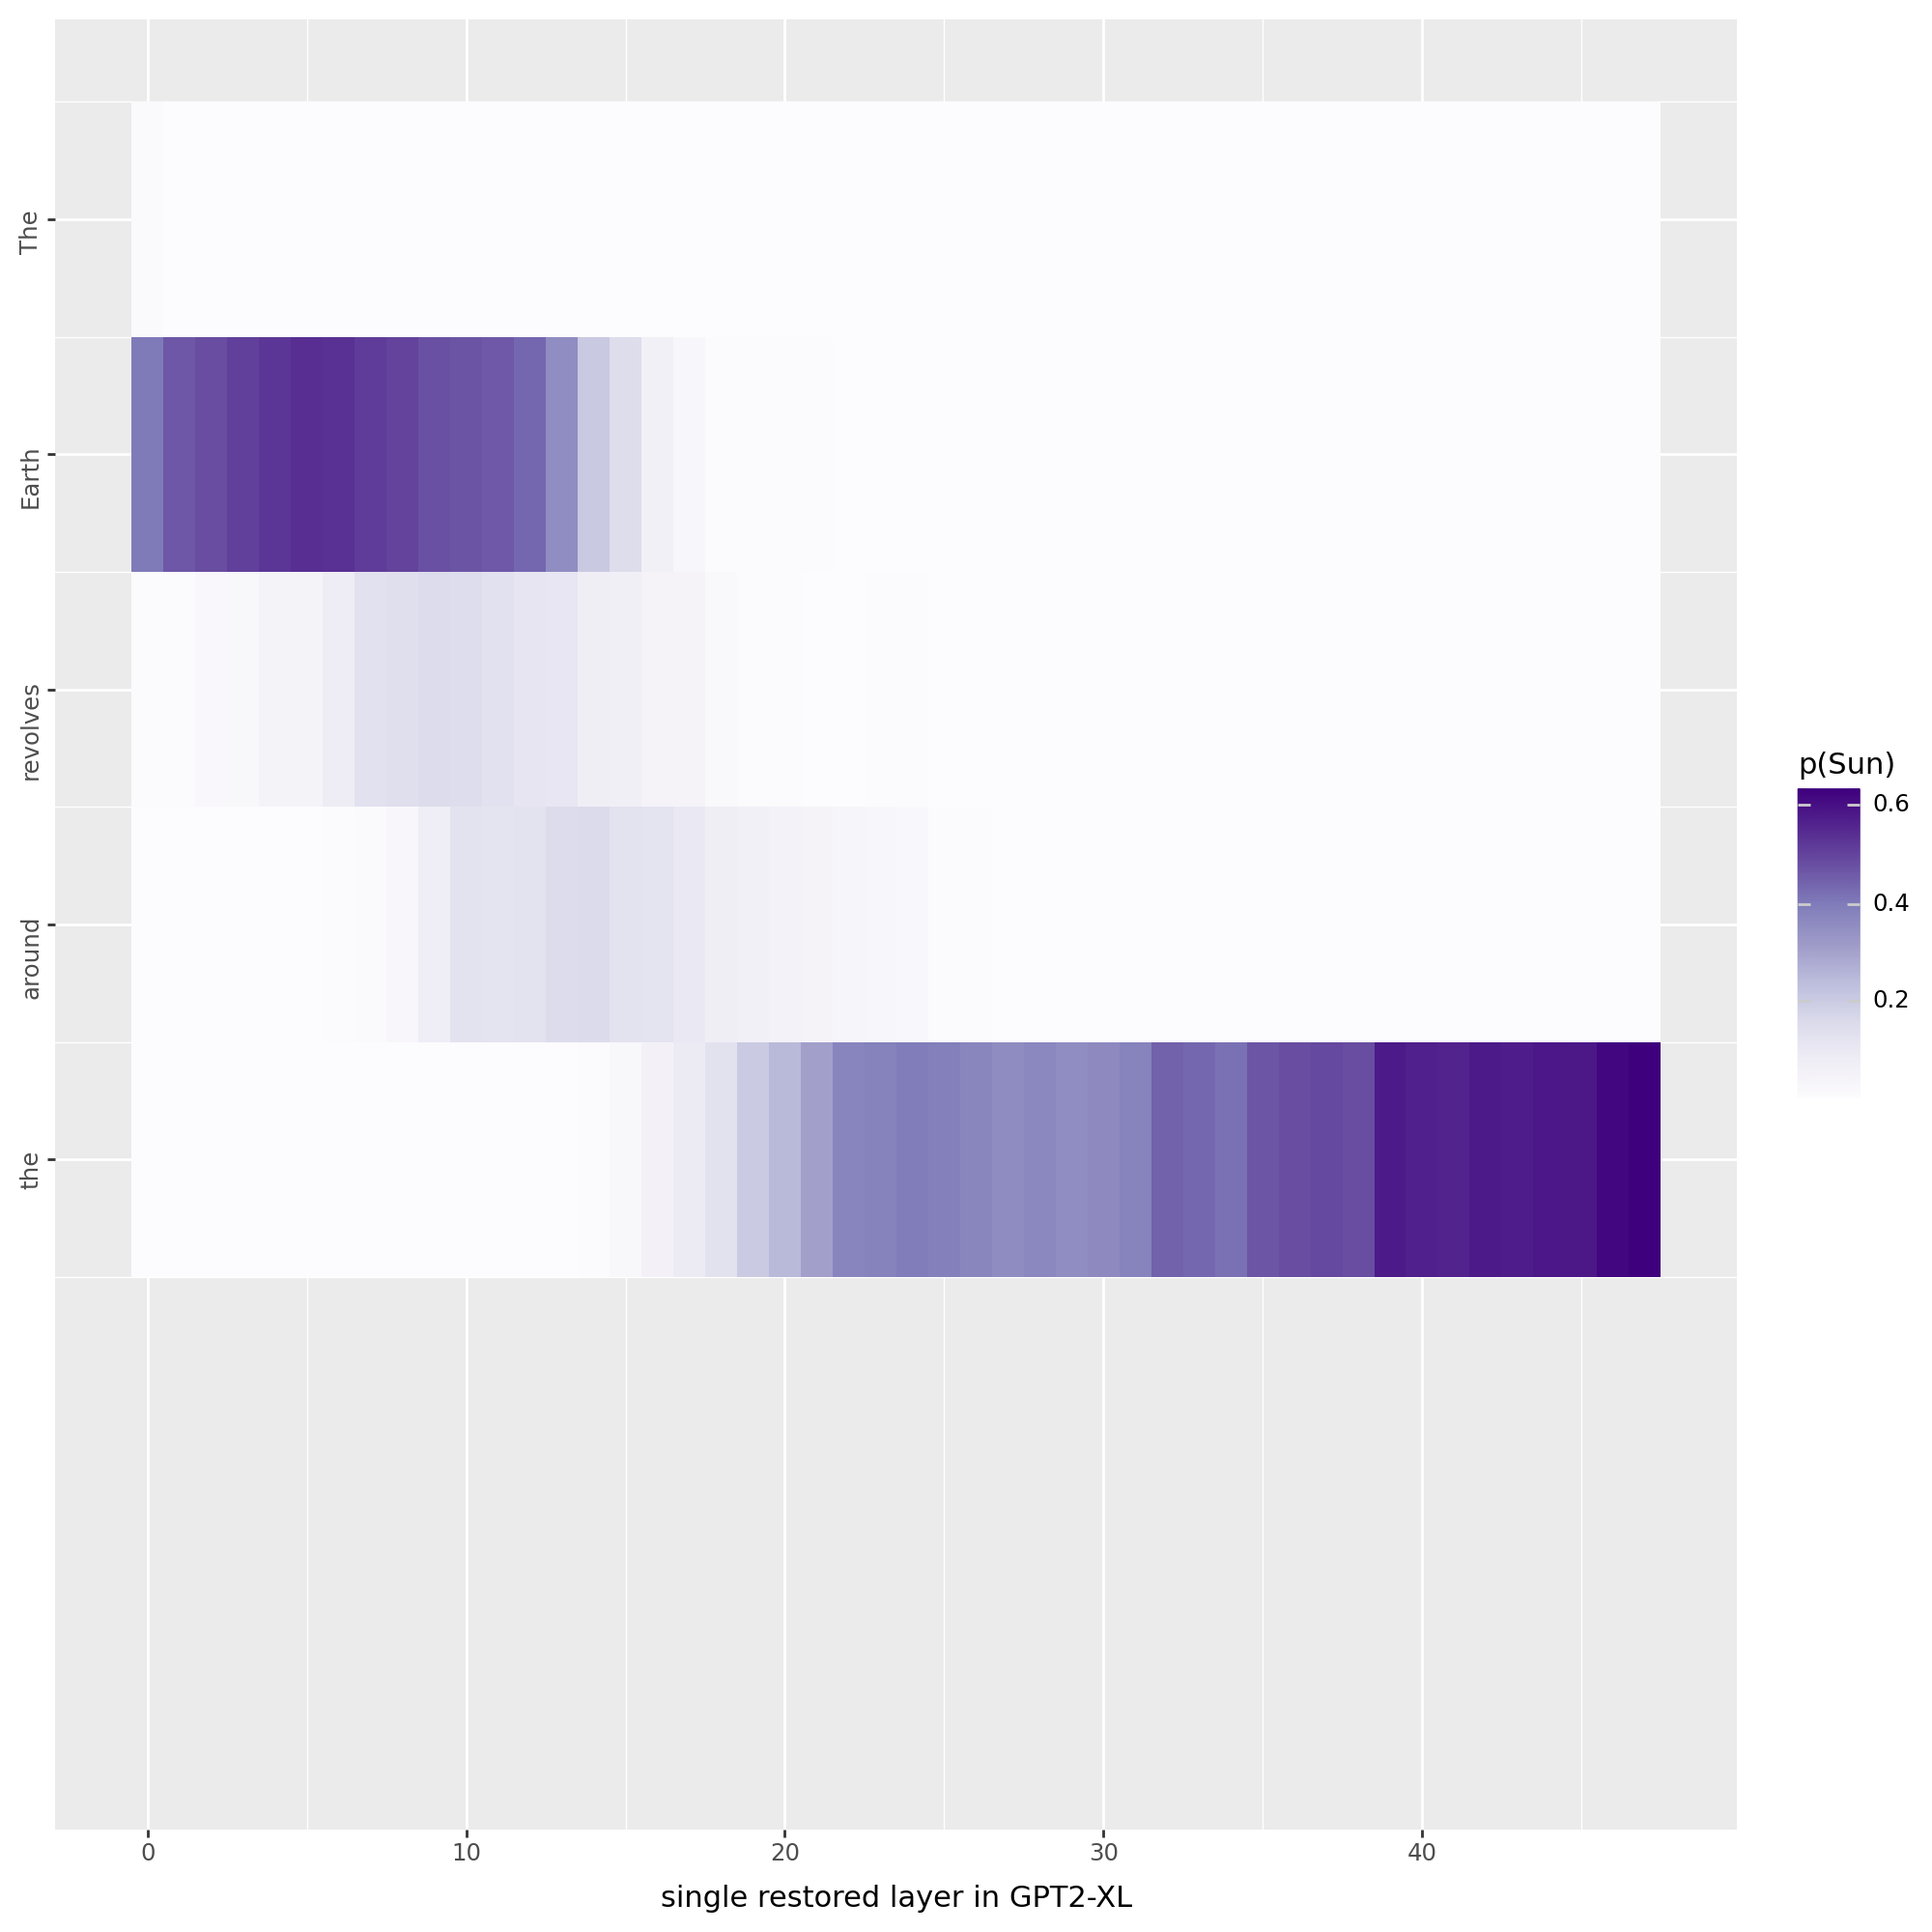

[0, 1, 2, 3, 4]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent23_mlp_activation.pdf


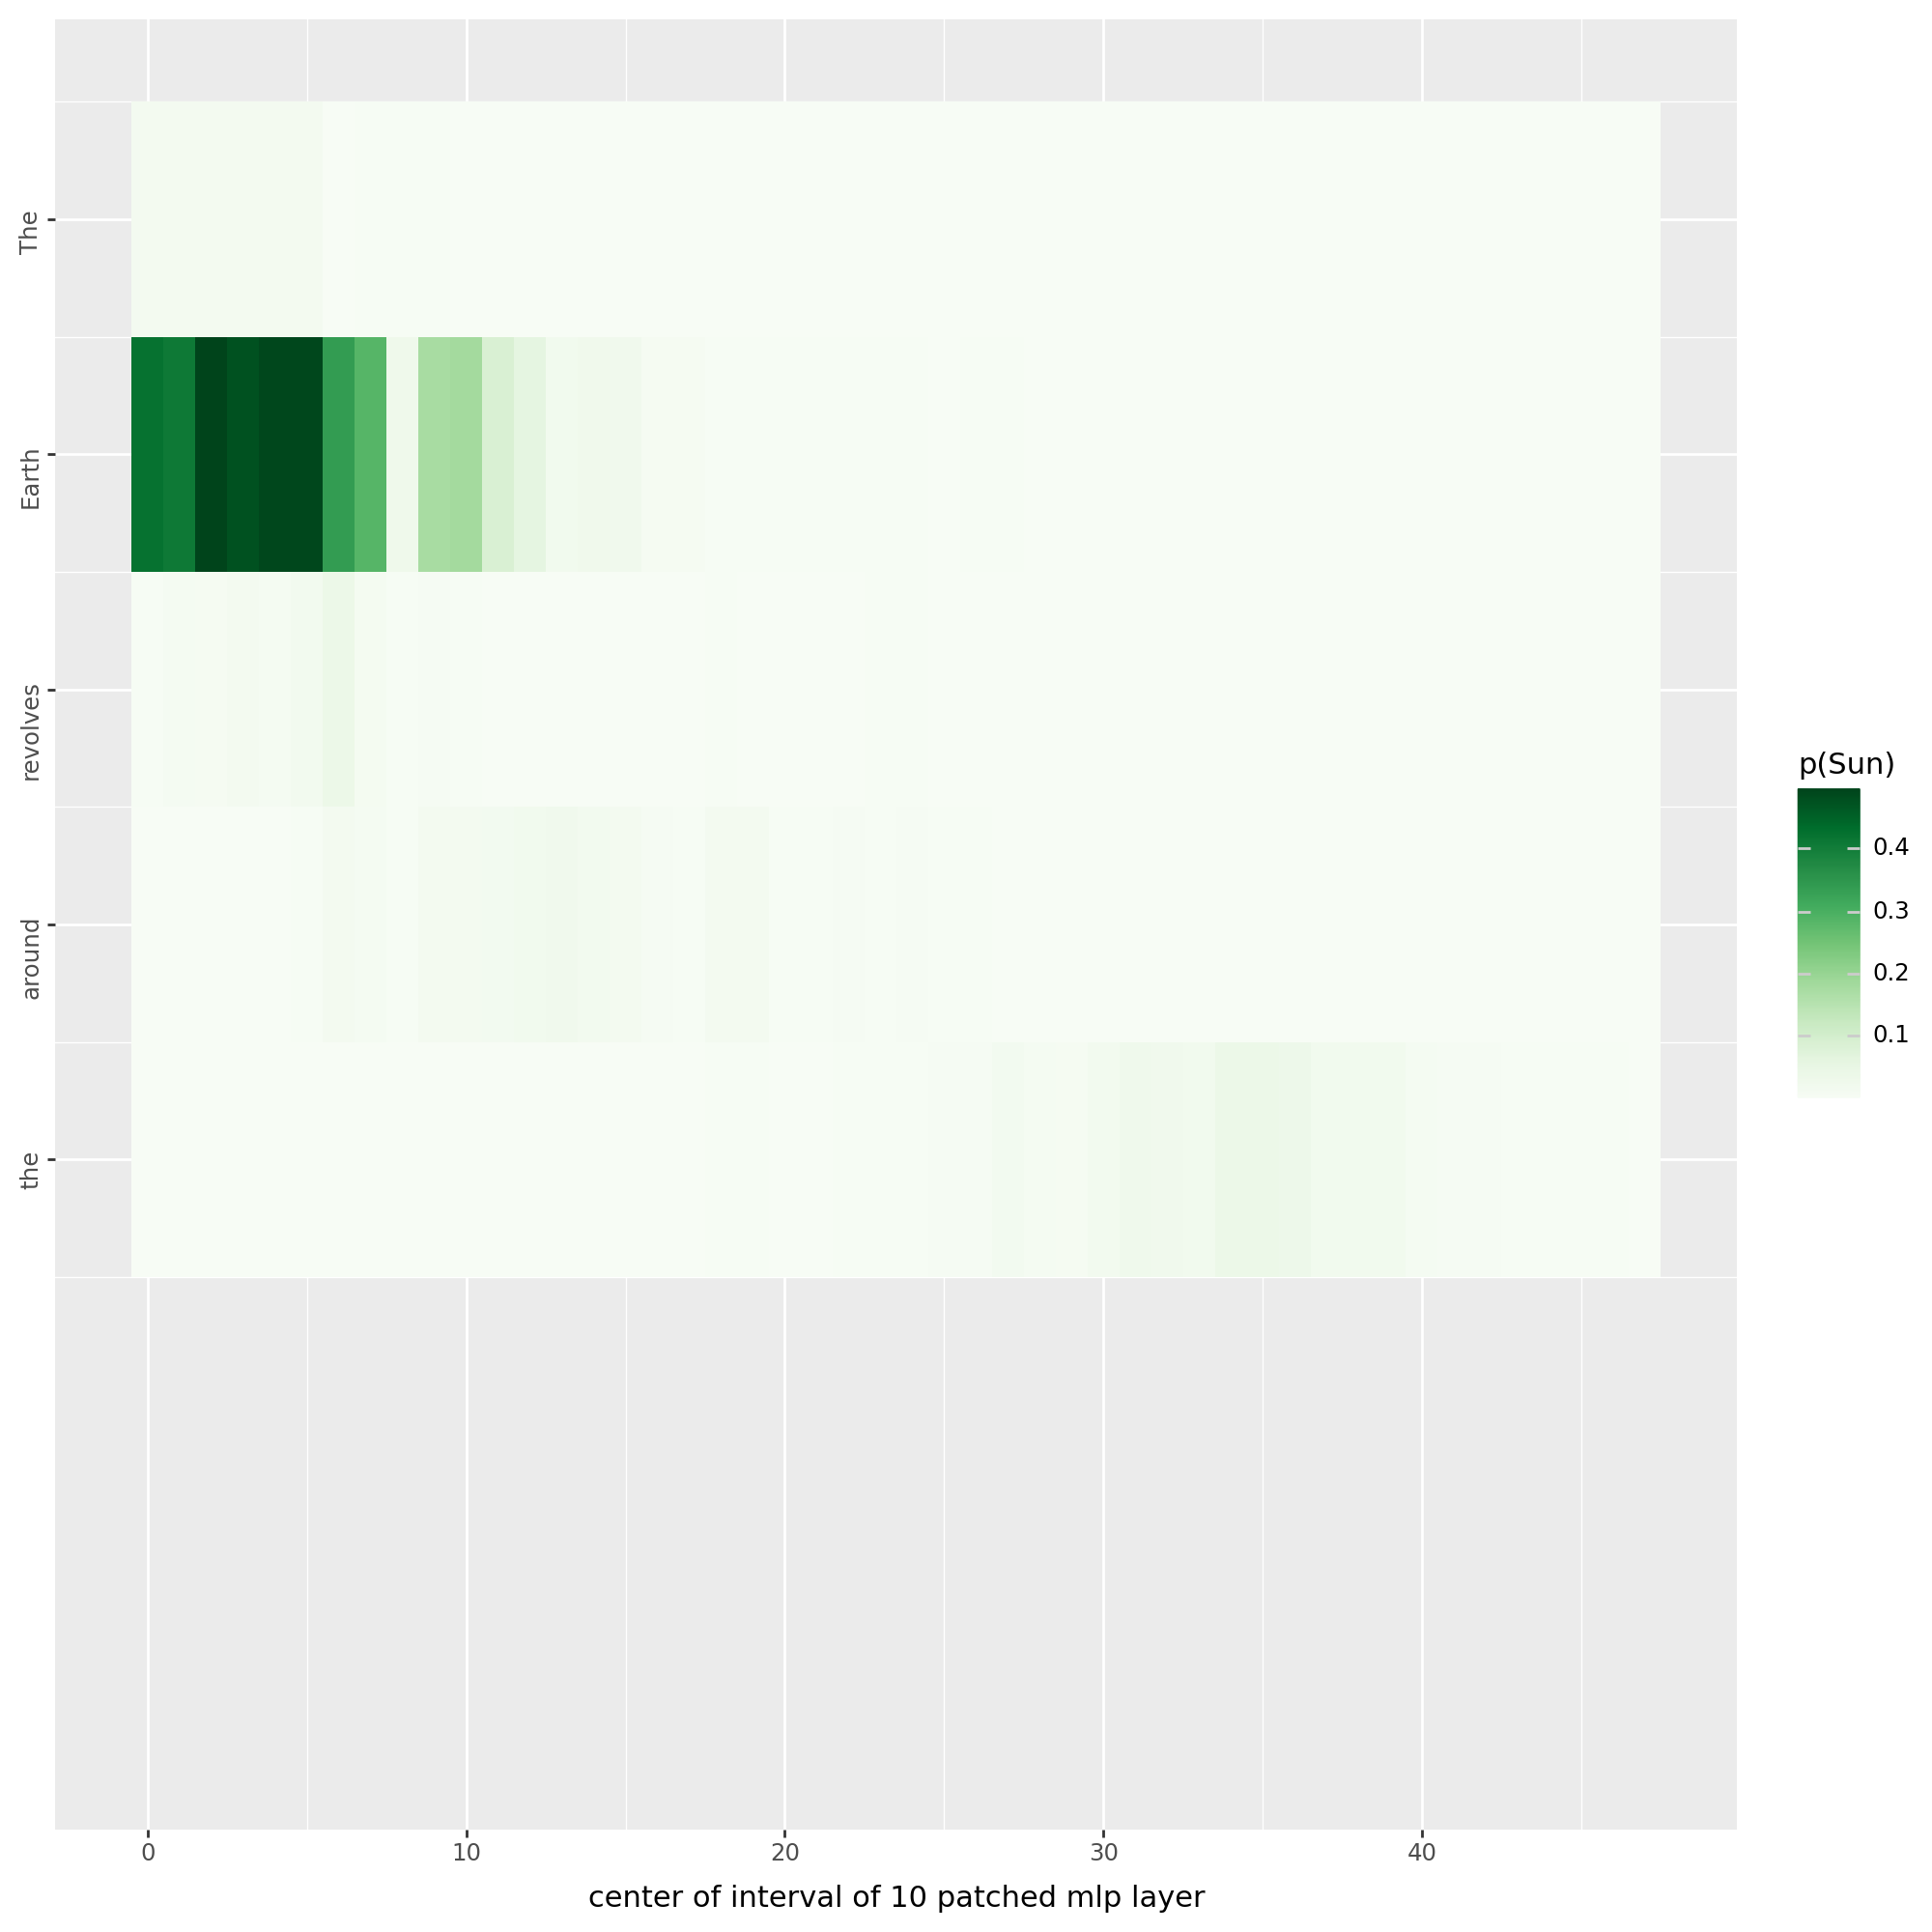

[0, 1, 2, 3, 4]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent23_attention_output.pdf


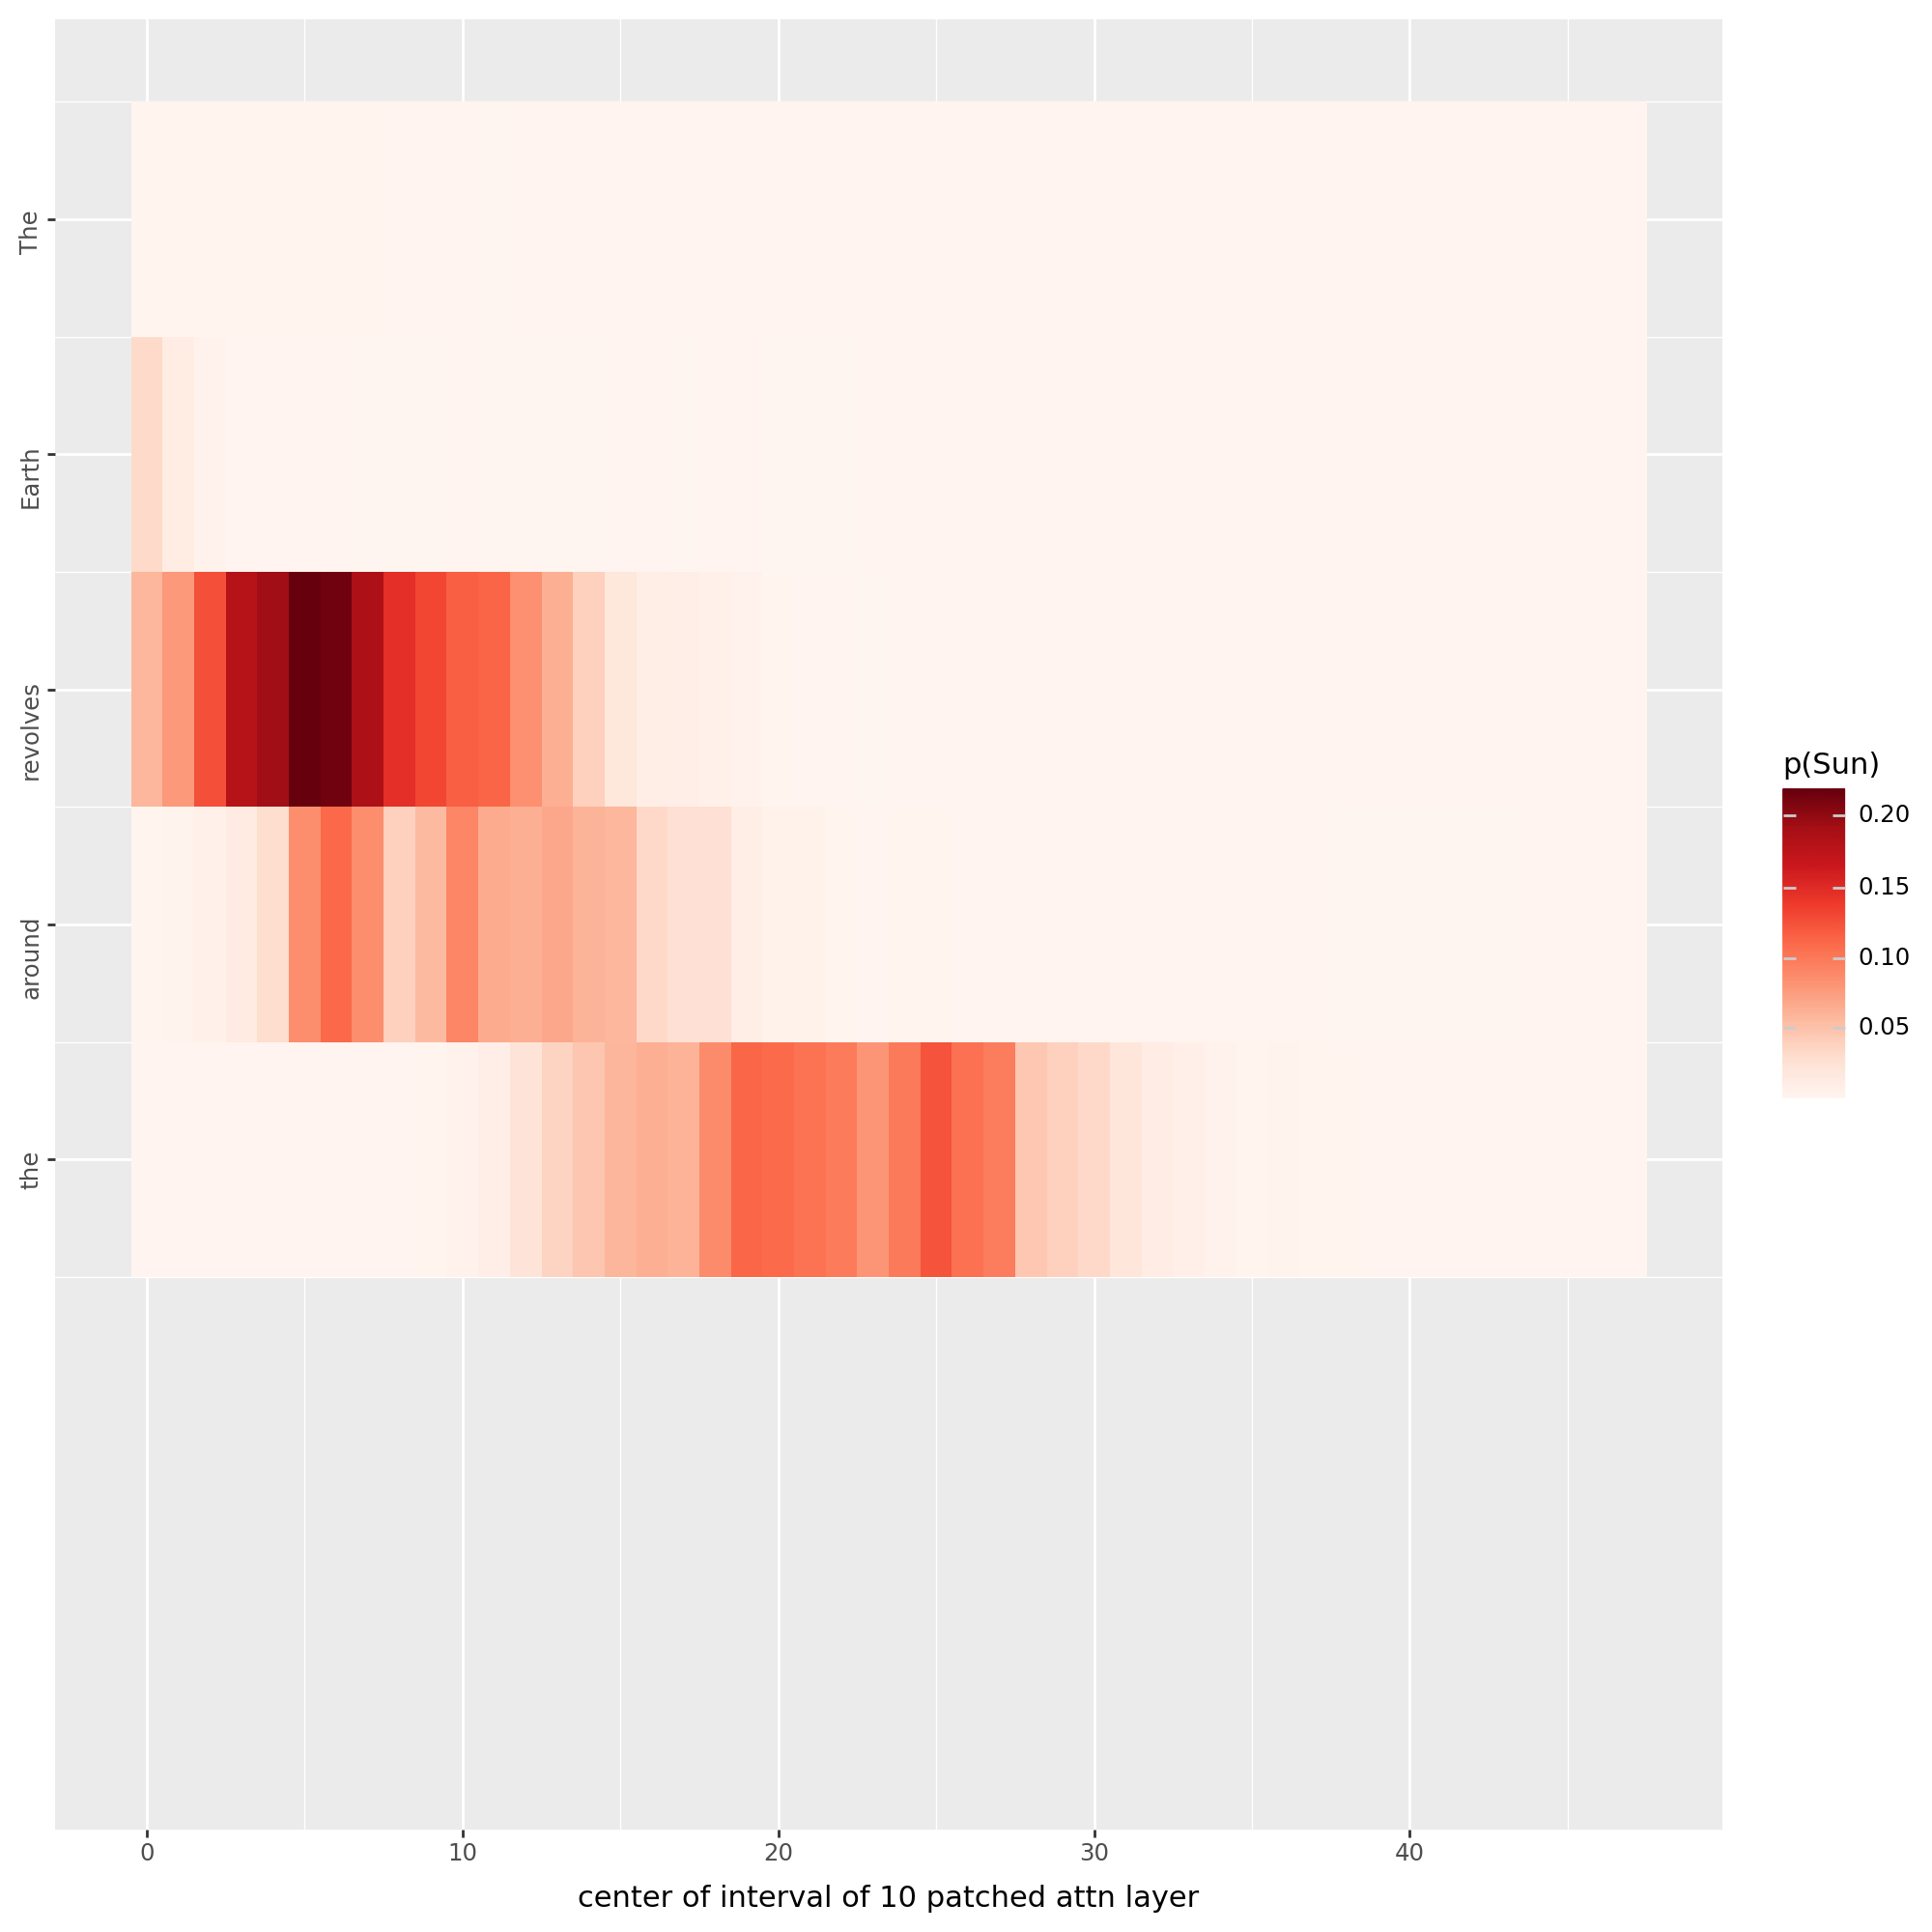

In [27]:
file_name = 'sent23'
name = "p(Sun)"
custom_labels = ['The', 'Earth', 'revolves', 'around', 'the']
token = tokenizer.encode(" Sun")[0]

base = tokenizer(sentence, return_tensors="pt").to(device)
plot(token, name, file_name, custom_labels, unit_locations)

# Zdanie 4

In [28]:
sentence = 'Paris is the capital of'
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

Original text: Paris is the capital of
Tokens: ['Paris', 'Ġis', 'Ġthe', 'Ġcapital', 'Ġof']


In [29]:
unit_locations = [0]
num_of_units = len(unit_locations)

In [30]:
casual_tracing(sentence, unit_locations)

Paris is the capital of
Przed zaszumieniem
_France              0.6473454833030701
_the                 0.14755338430404663
_a                   0.01980174332857132
_French              0.013600748963654041
_Europe              0.012703640386462212
_Paris               0.007553457282483578
_Spain               0.0030439794063568115
_many                0.0028825453482568264
_one                 0.002730485051870346
_an                  0.002334783785045147
Po zaszumieniu
_the                 0.3043379783630371
_France              0.2880449593067169
_a                   0.014690802432596684
_Brittany            0.013582742772996426
_French              0.012802846729755402
_Burg                0.010646169073879719
_Champ               0.00788950826972723
_Cors                0.007437886204570532
_Paris               0.005723597947508097
_Normandy            0.005451332312077284


100%|██████████| 48/48 [01:30<00:00,  1.88s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_block_output.pdf


[0, 1, 2, 3, 4]


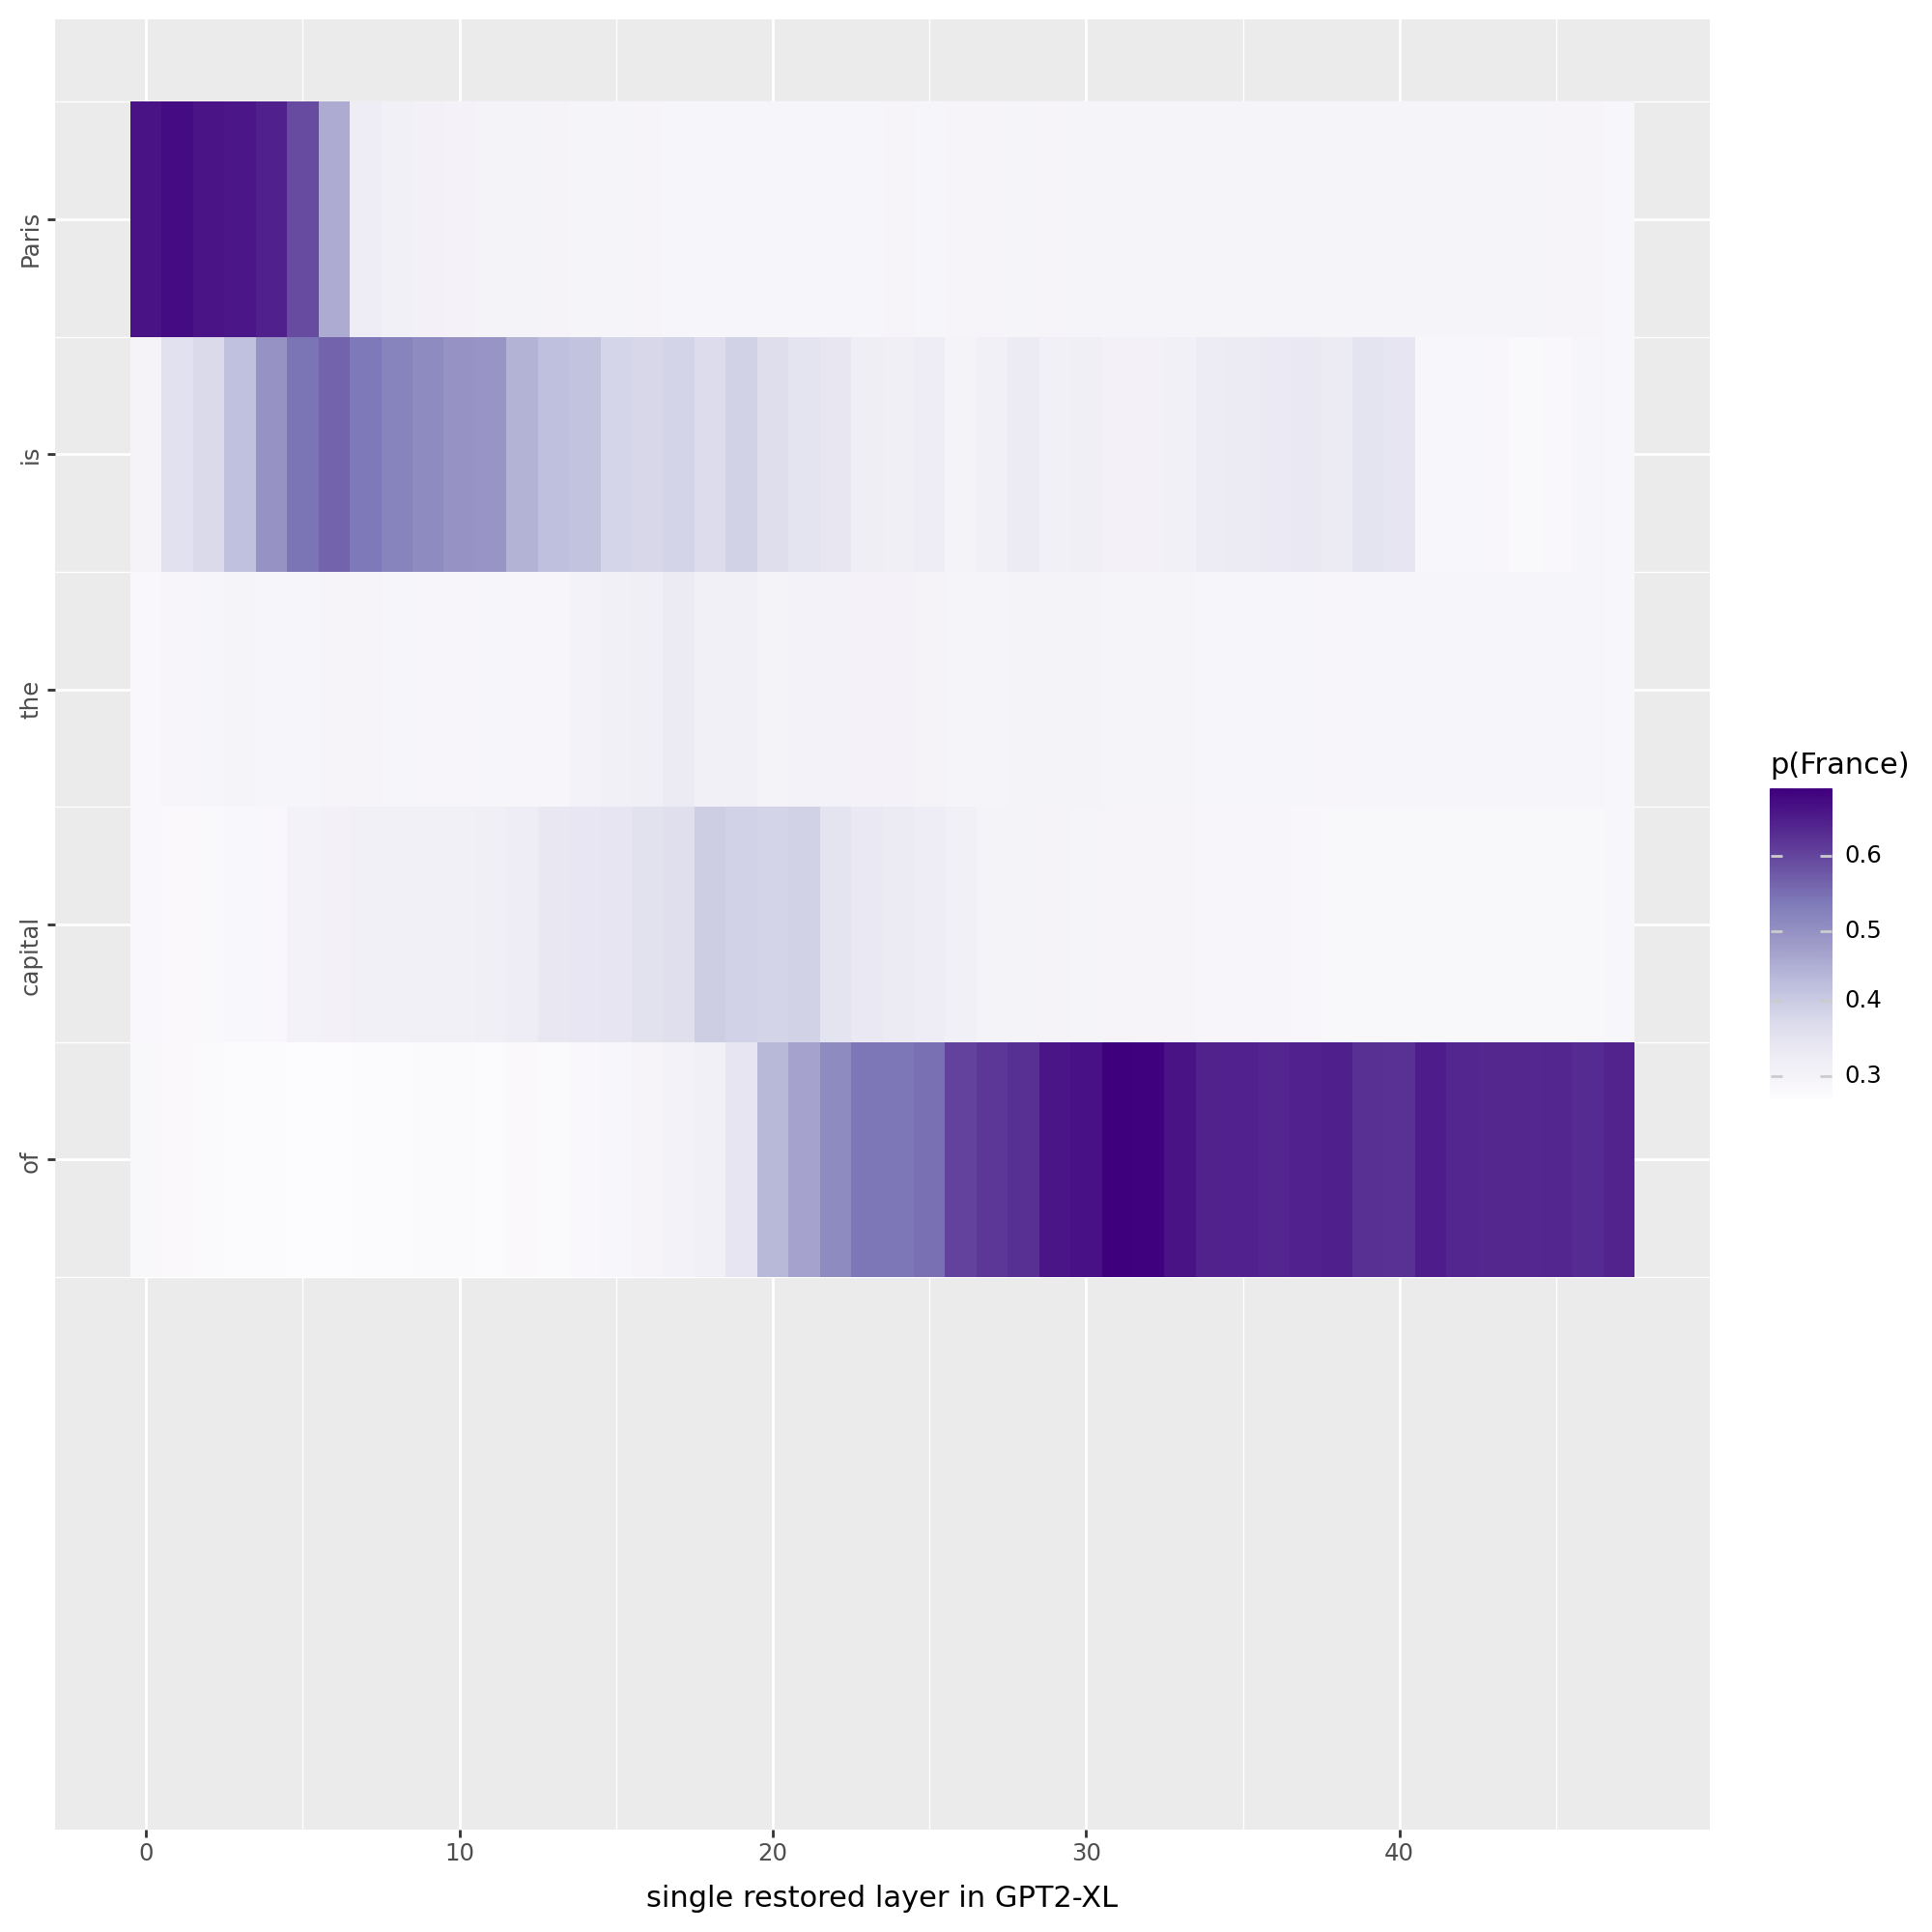

[0, 1, 2, 3, 4]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_mlp_activation.pdf


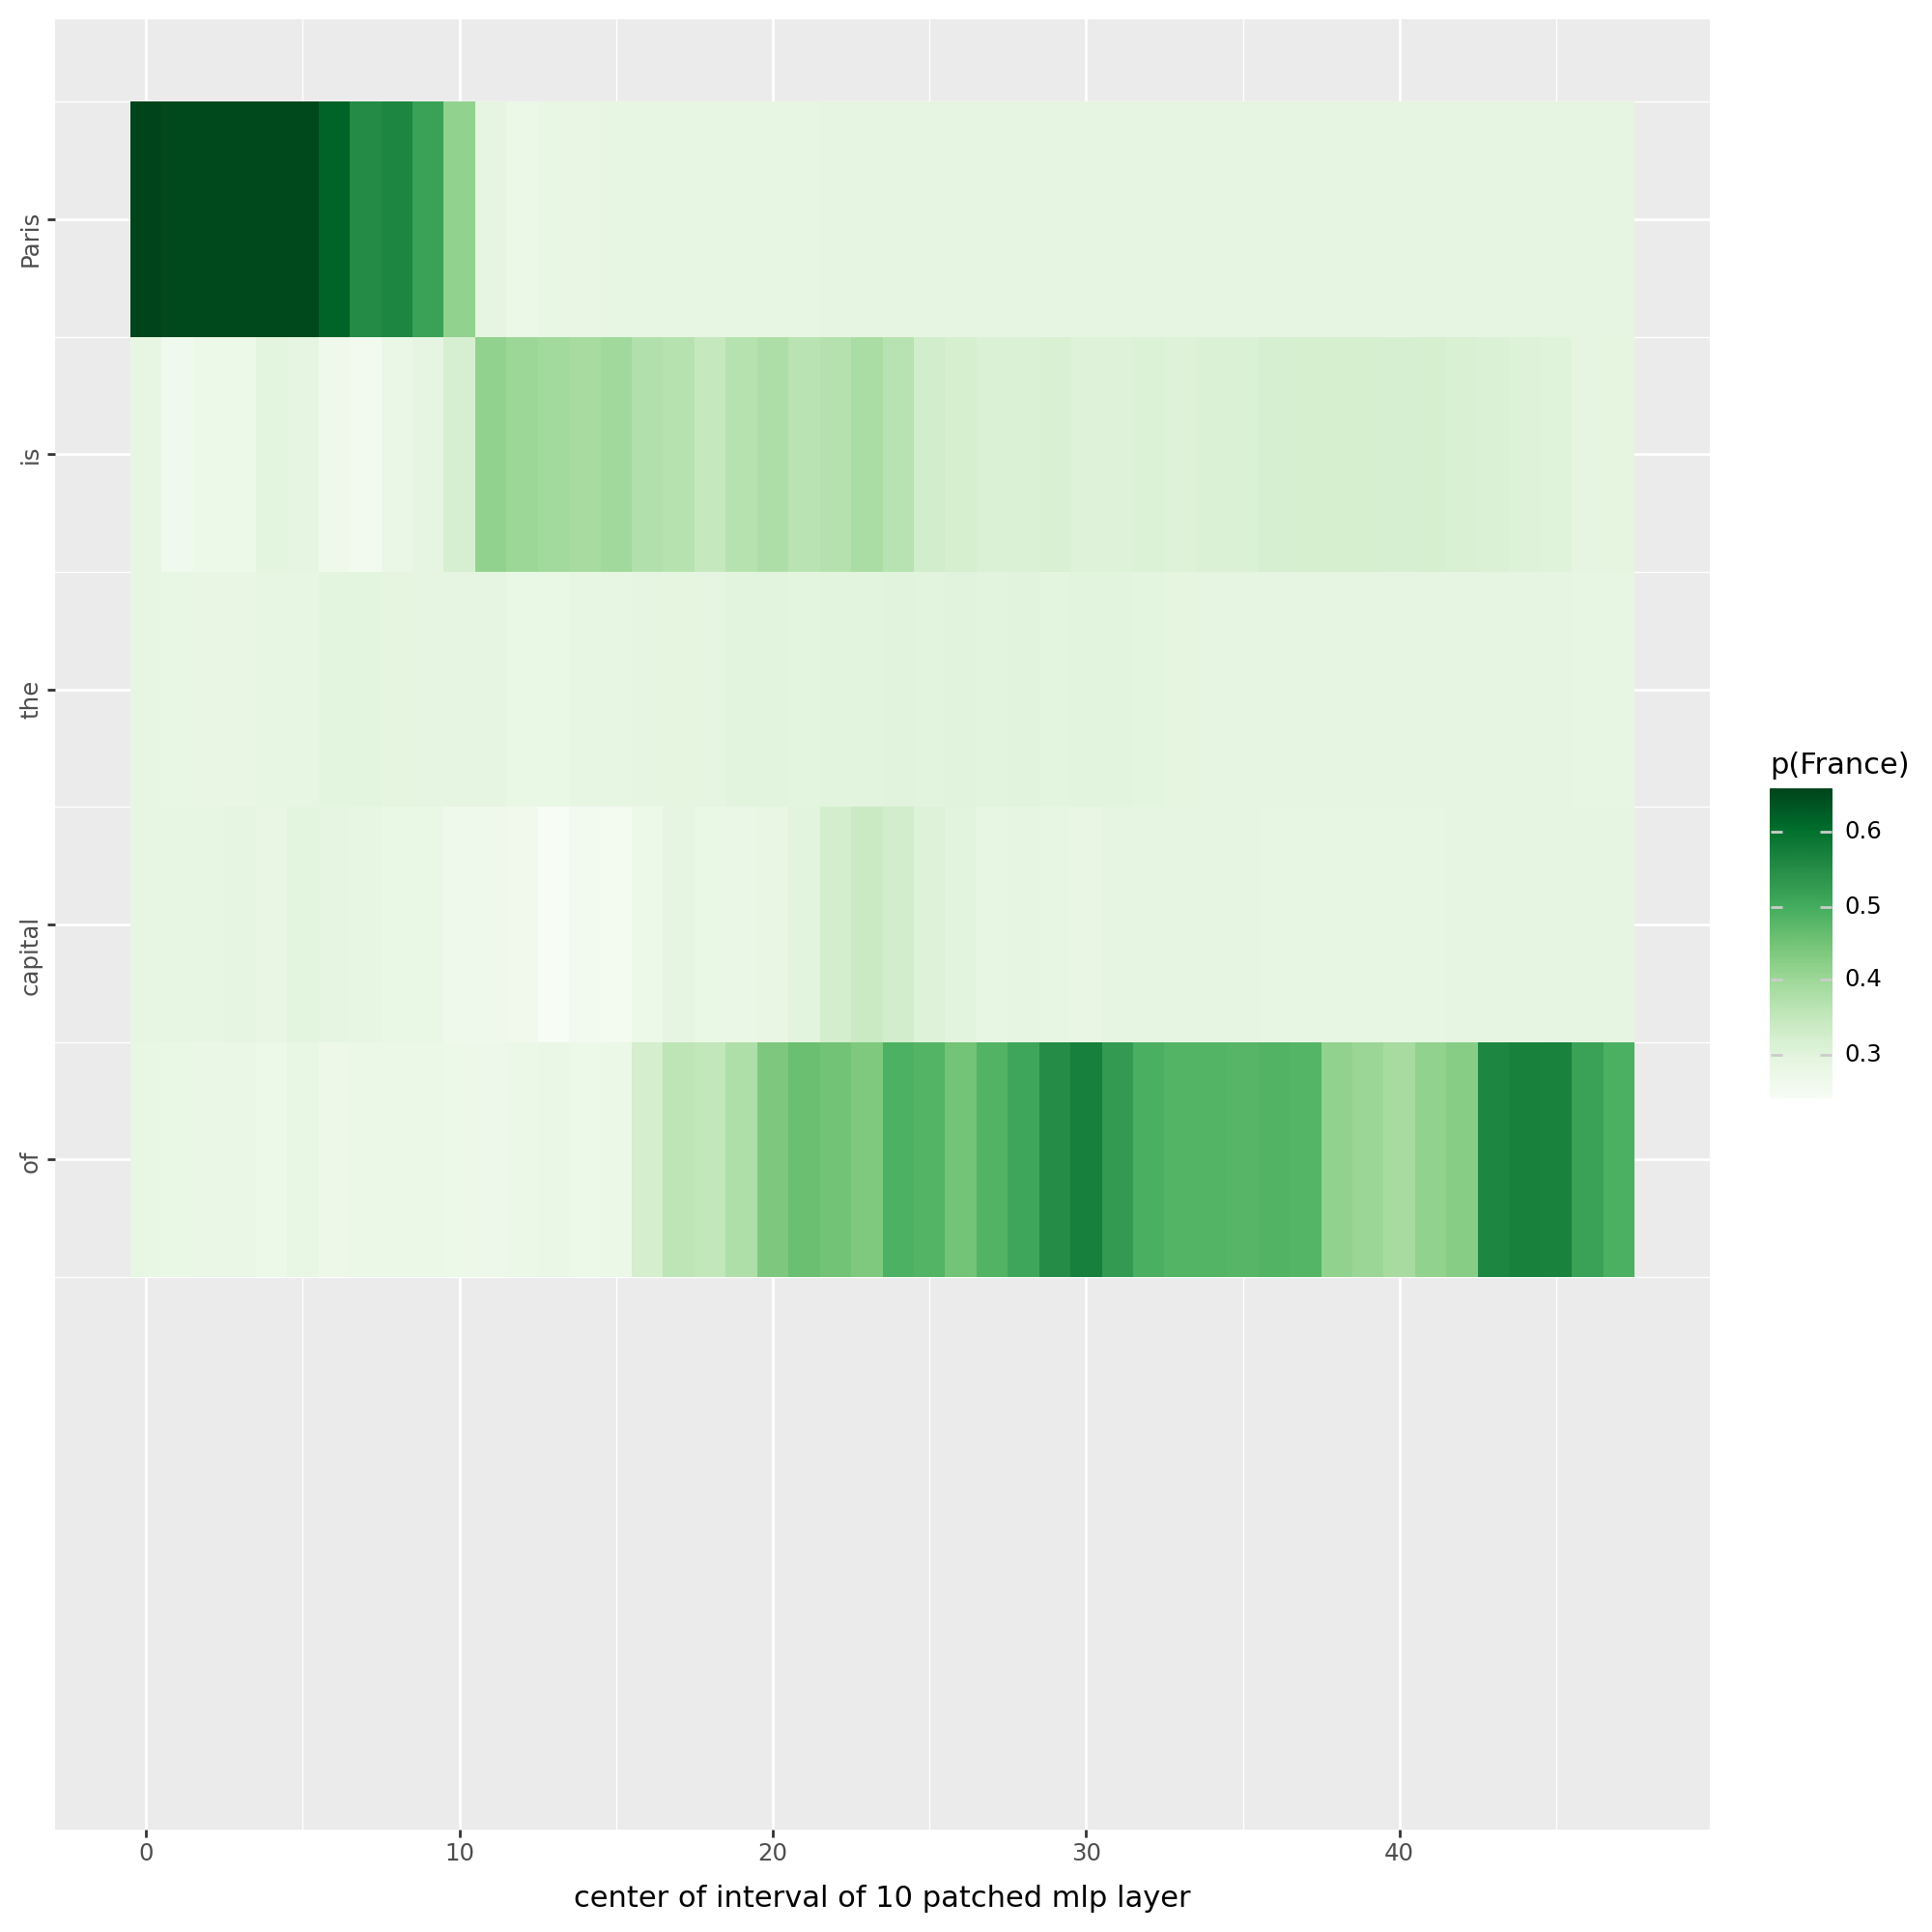

[0, 1, 2, 3, 4]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_attention_output.pdf


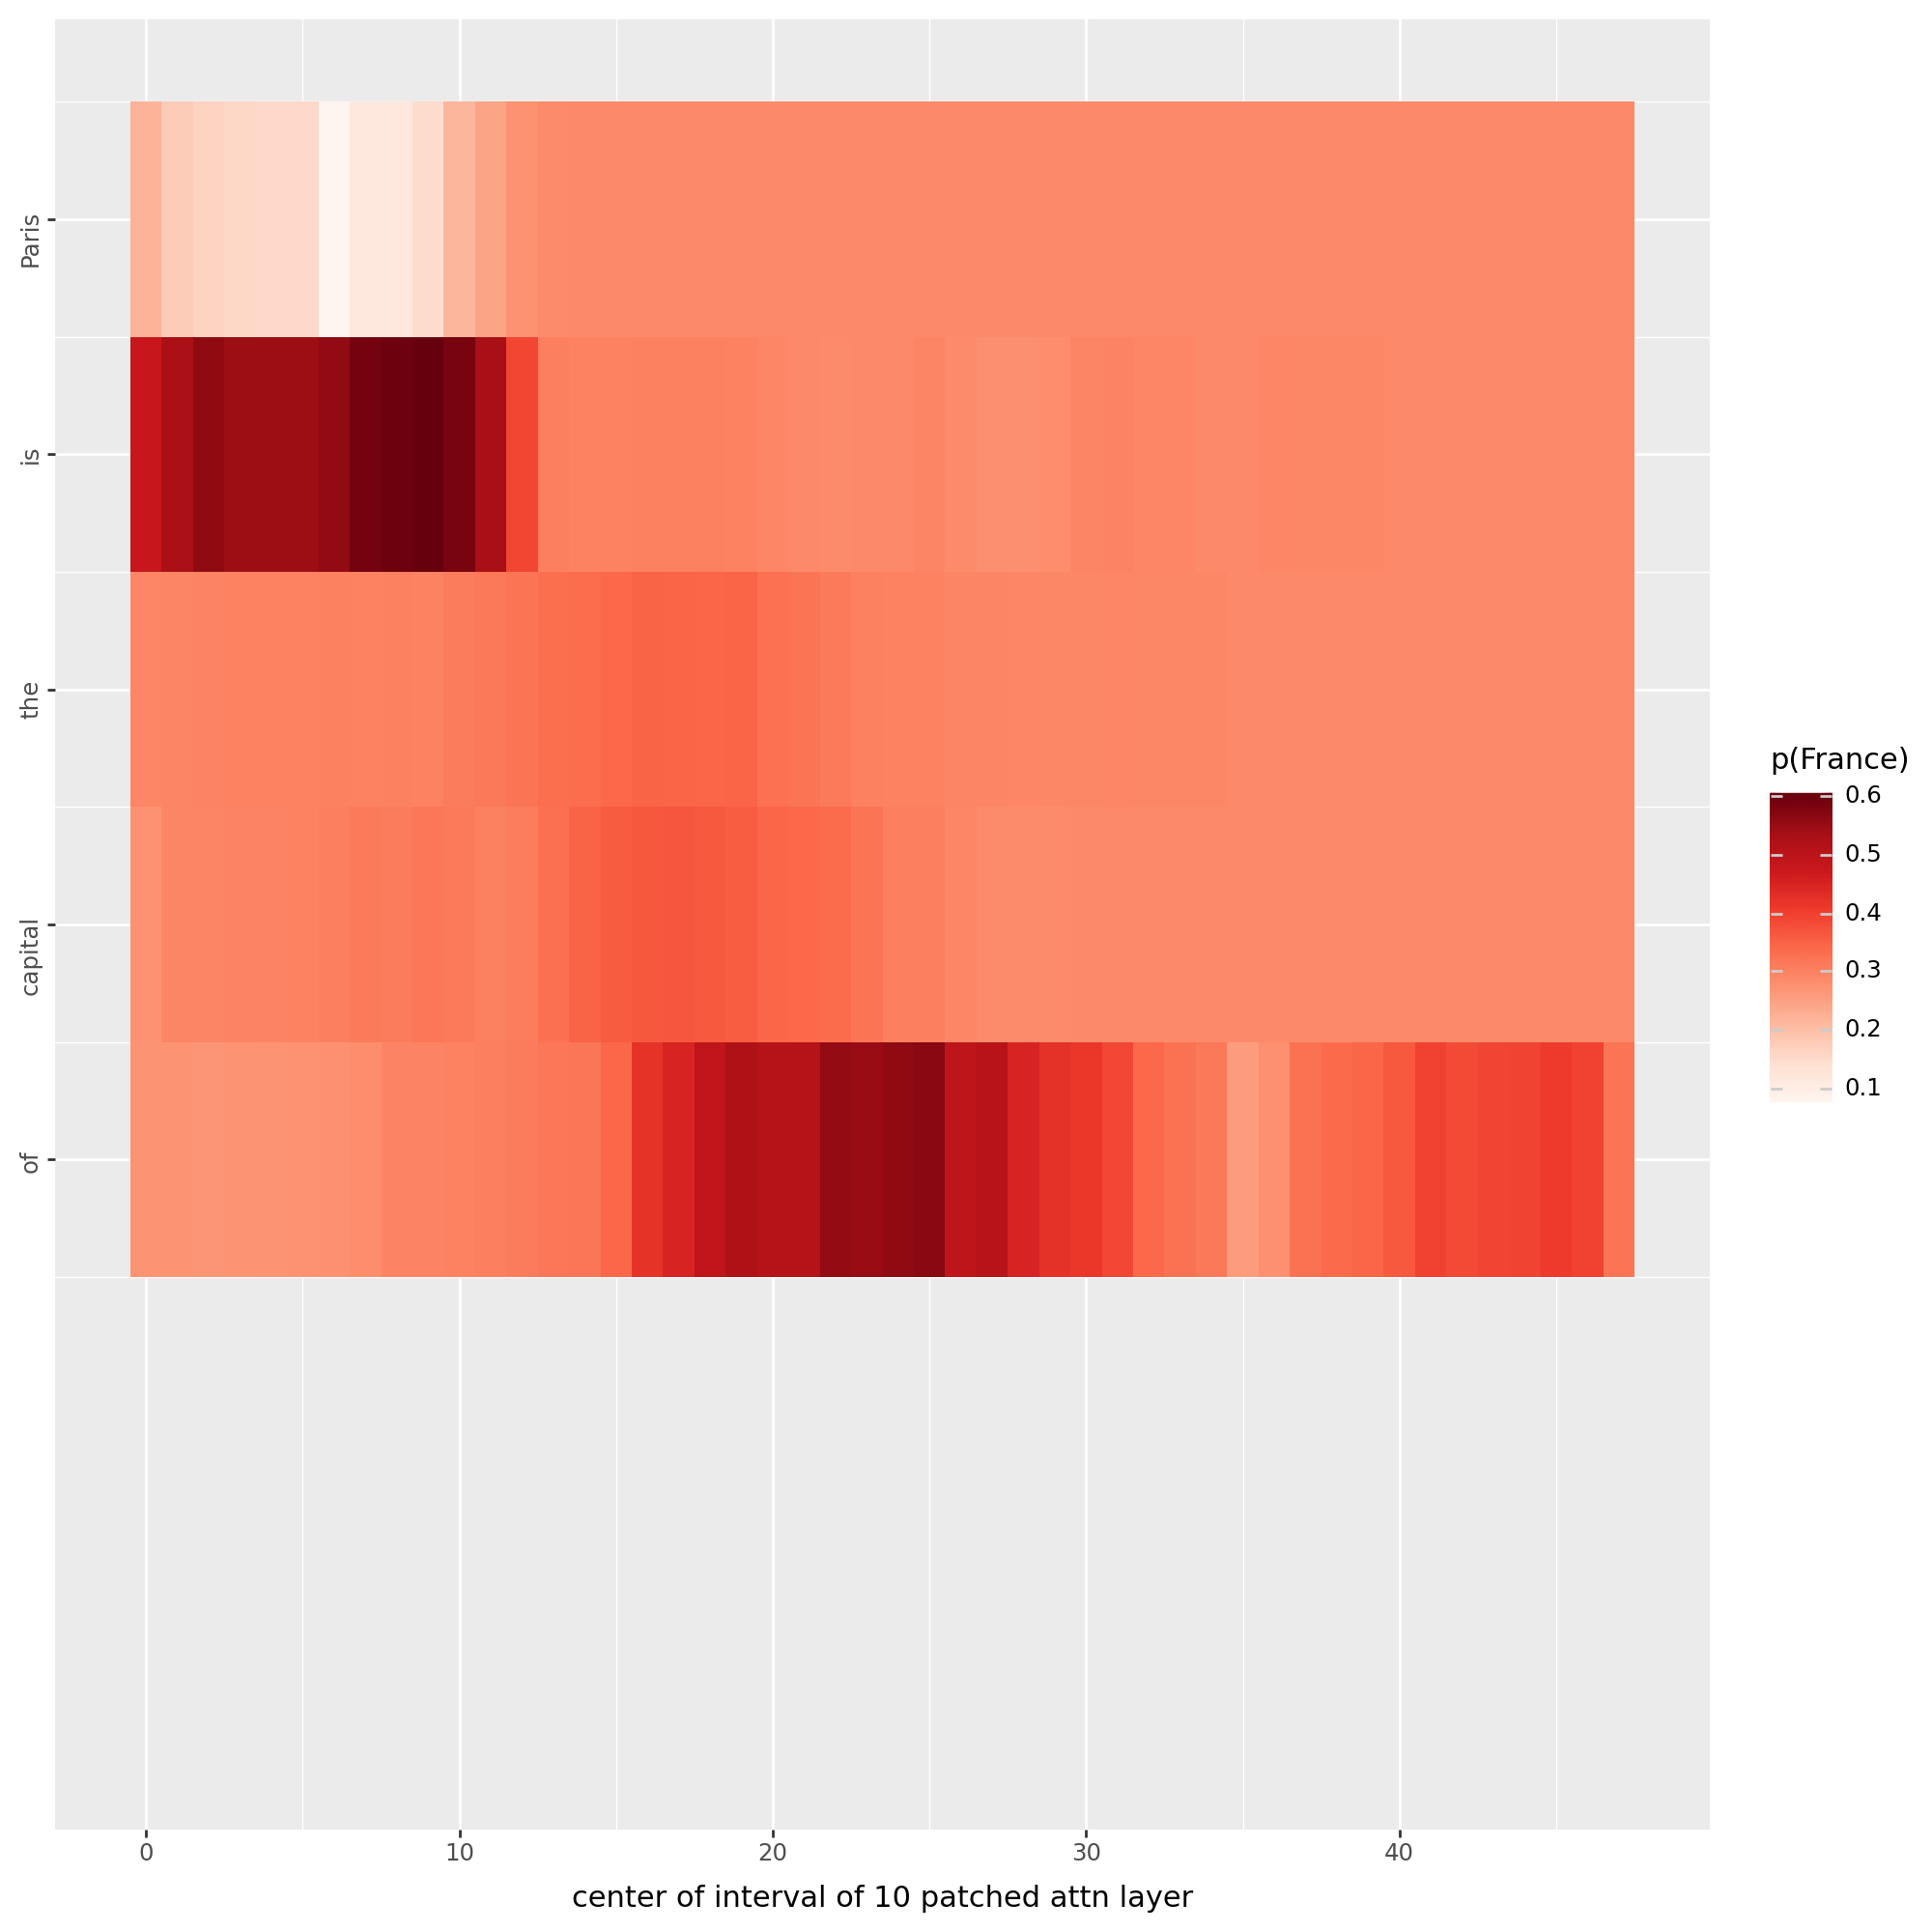

In [31]:
file_name = 'sent4'
name = "p(France)"
custom_labels = ['Paris', 'is', 'the', 'capital', 'of']
token = tokenizer.encode(" France")[0]
base = tokenizer(sentence, return_tensors="pt").to(device)

plot(token, name, file_name, custom_labels, unit_locations)

# Zdanie 5

In [32]:
sentence = 'Christopher Columbus discovered the'
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

Original text: Christopher Columbus discovered the
Tokens: ['Christopher', 'ĠColumbus', 'Ġdiscovered', 'Ġthe']


In [33]:
len(tokens)

4

In [34]:
unit_locations = [0,1]
num_of_units = len(unit_locations)

In [35]:
casual_tracing(sentence, unit_locations)

Christopher Columbus discovered the
Przed zaszumieniem
_Americas            0.5164847373962402
_New                 0.13523952662944794
_island              0.028407201170921326
_Caribbean           0.02377350442111492
_world               0.02307782880961895
_first               0.018427785485982895
_land                0.012096364982426167
_Bahamas             0.011262333020567894
_new                 0.007475744932889938
_"                   0.007417917717248201
Po zaszumieniu
_first               0.012036386877298355
_secret              0.010255706496536732
_world               0.00945744663476944
_"                   0.009124072268605232
_new                 0.007904811762273312
_island              0.00762352766469121
_existence           0.007598645985126495
_truth               0.0073908790946006775
_power               0.00684883538633585
_true                0.0064041647128760815


100%|██████████| 48/48 [00:59<00:00,  1.24s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent5_block_output.pdf


[0, 1, 2, 3]


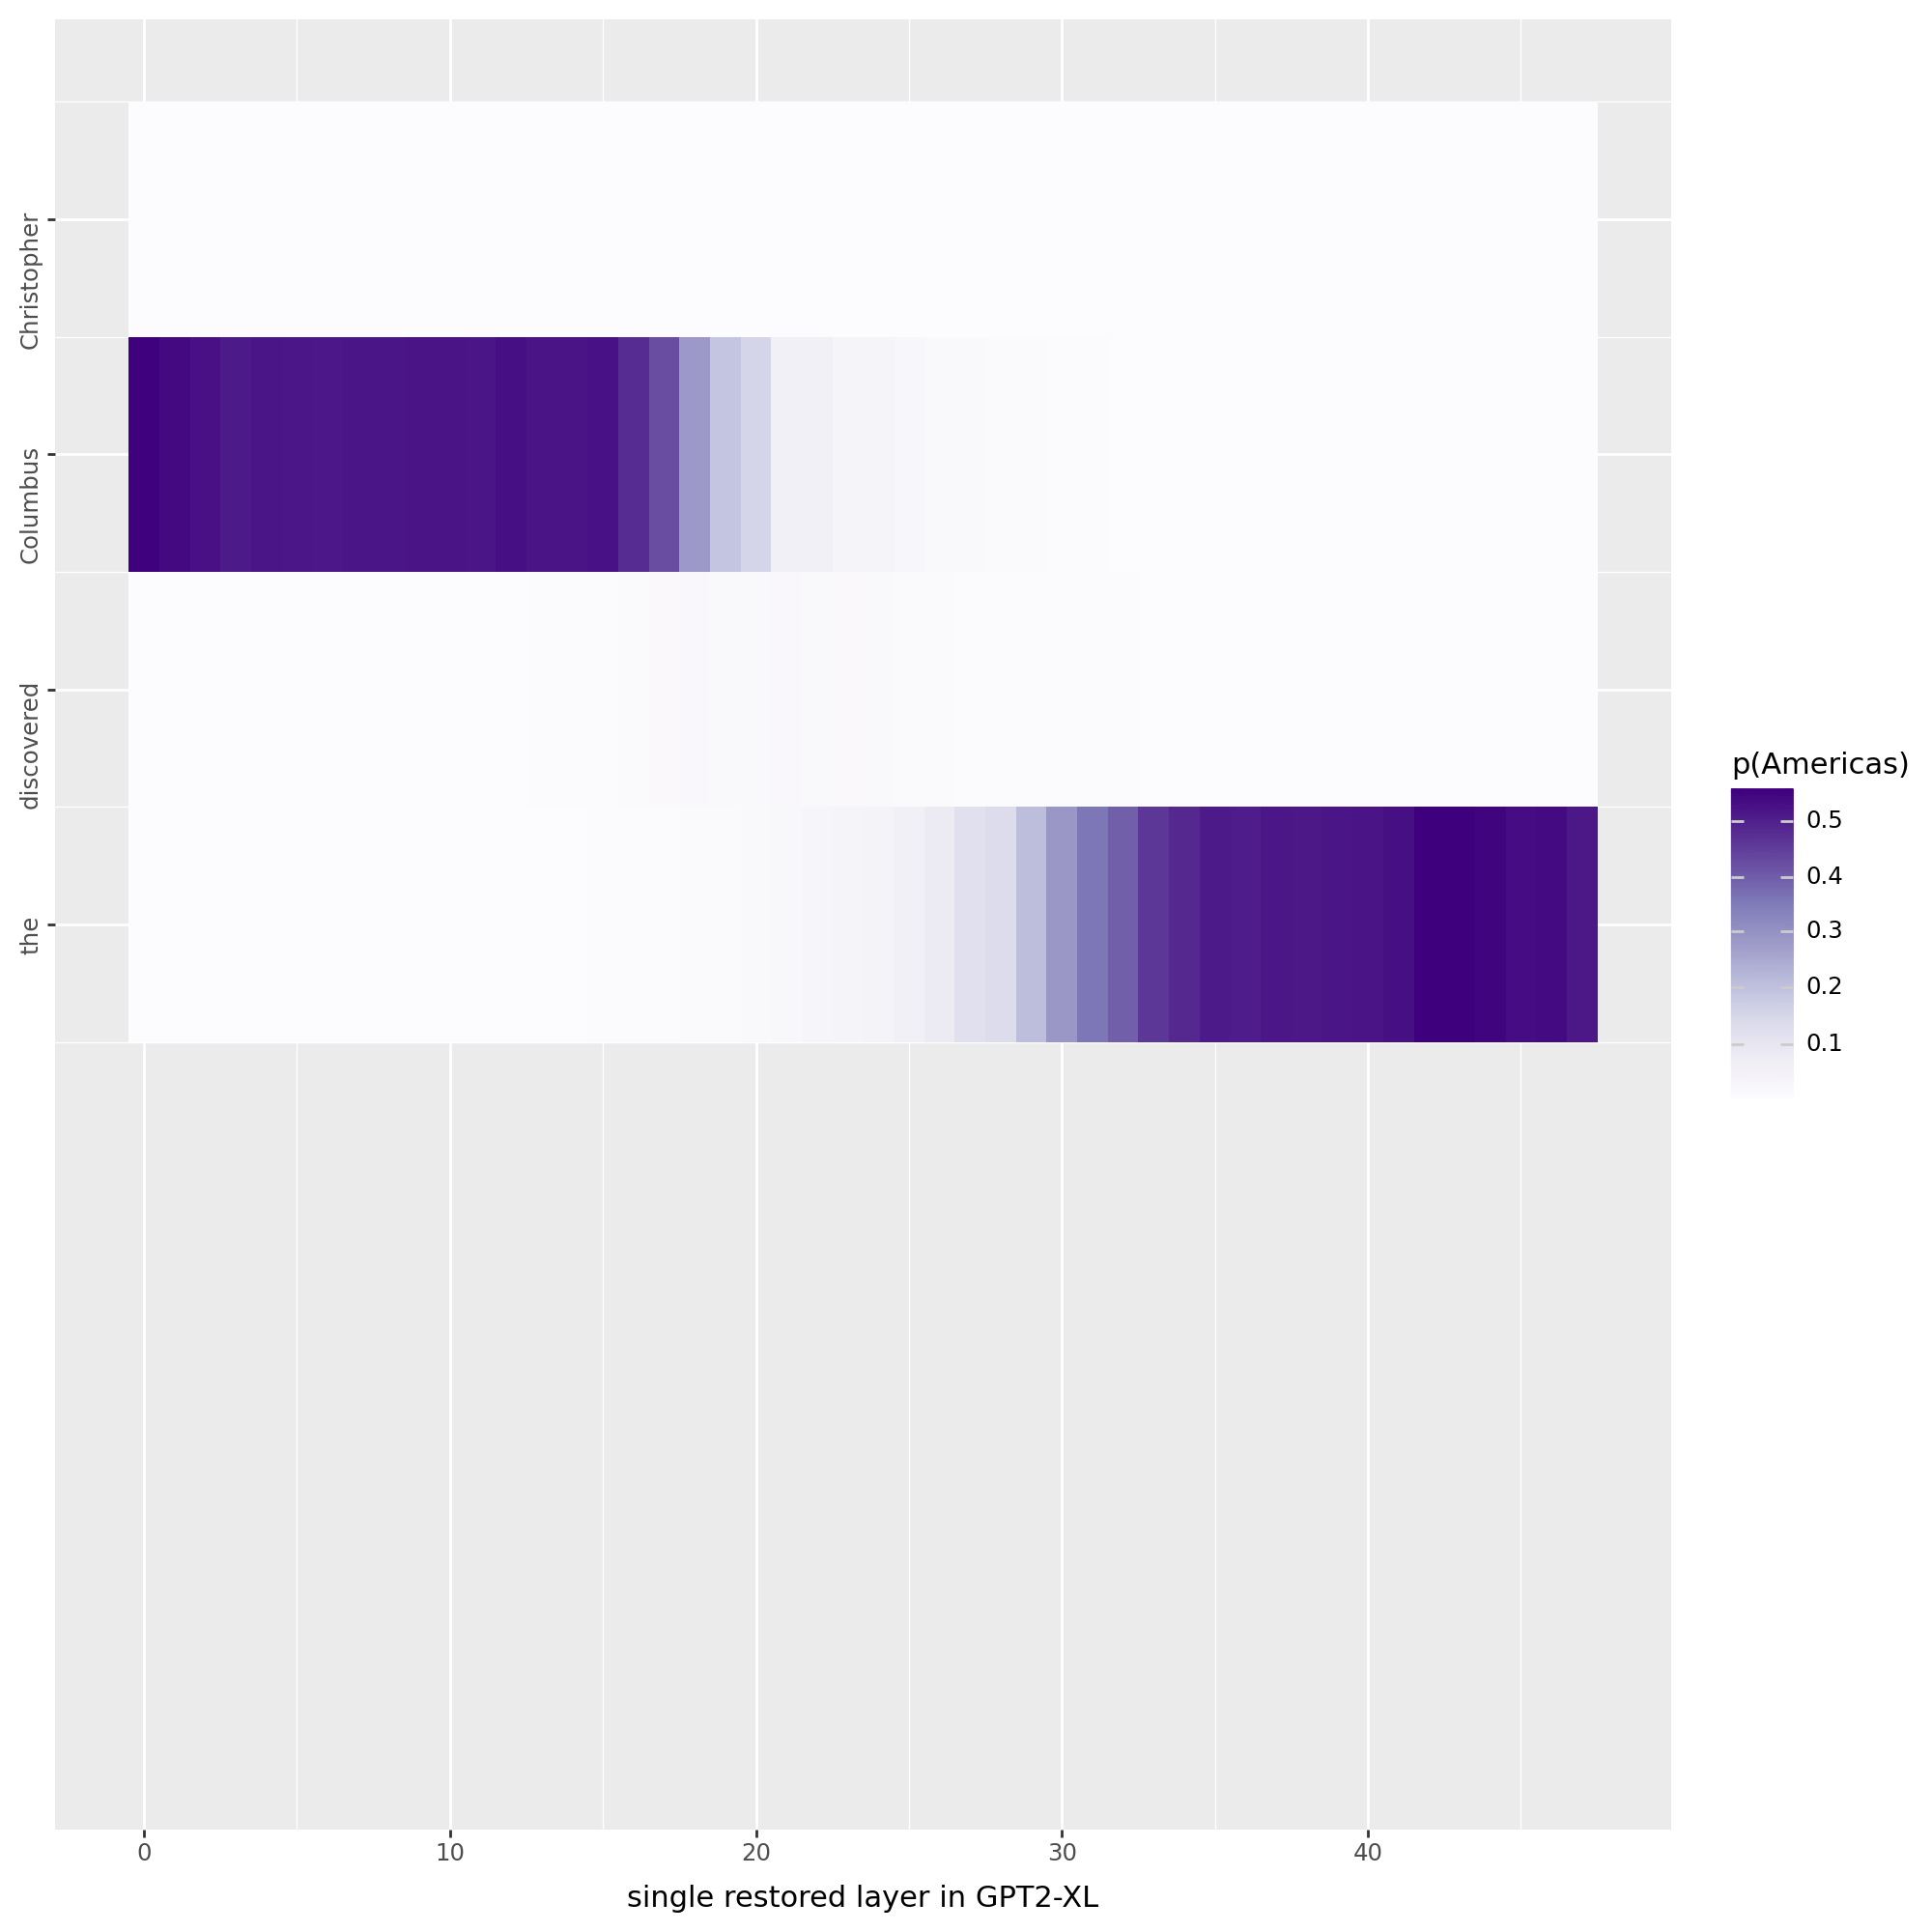

[0, 1, 2, 3]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent5_mlp_activation.pdf


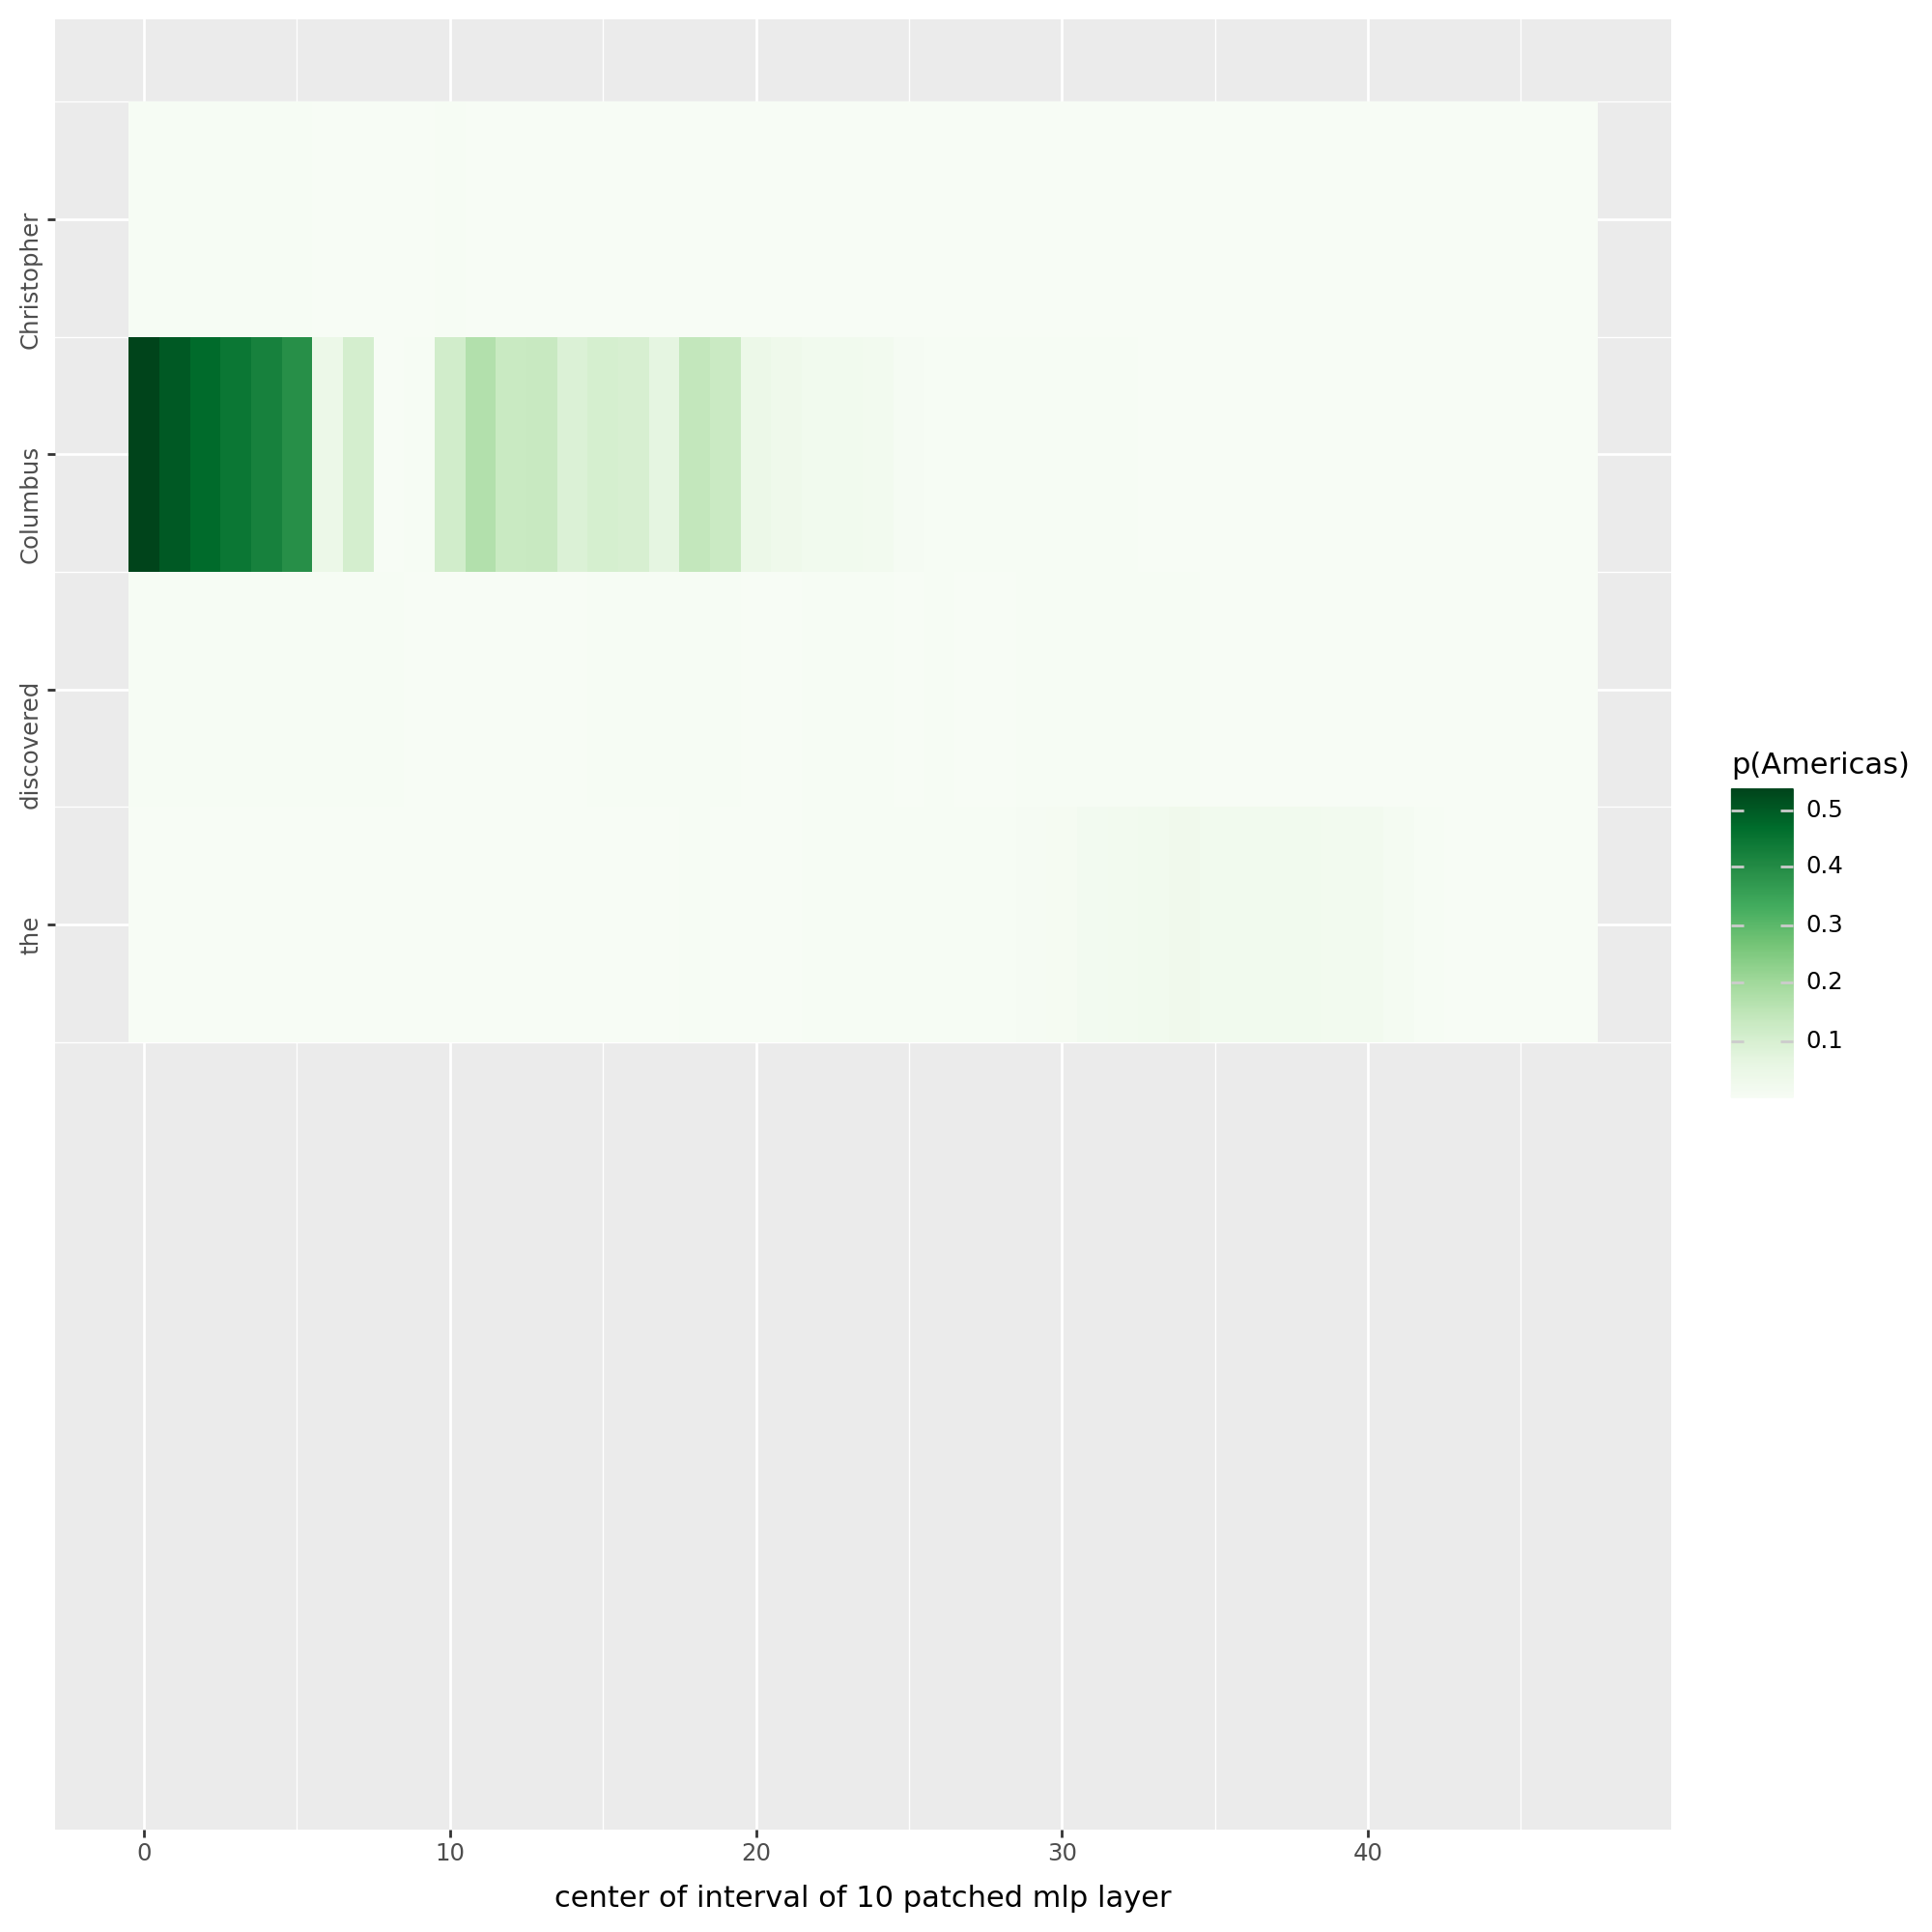

[0, 1, 2, 3]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent5_attention_output.pdf


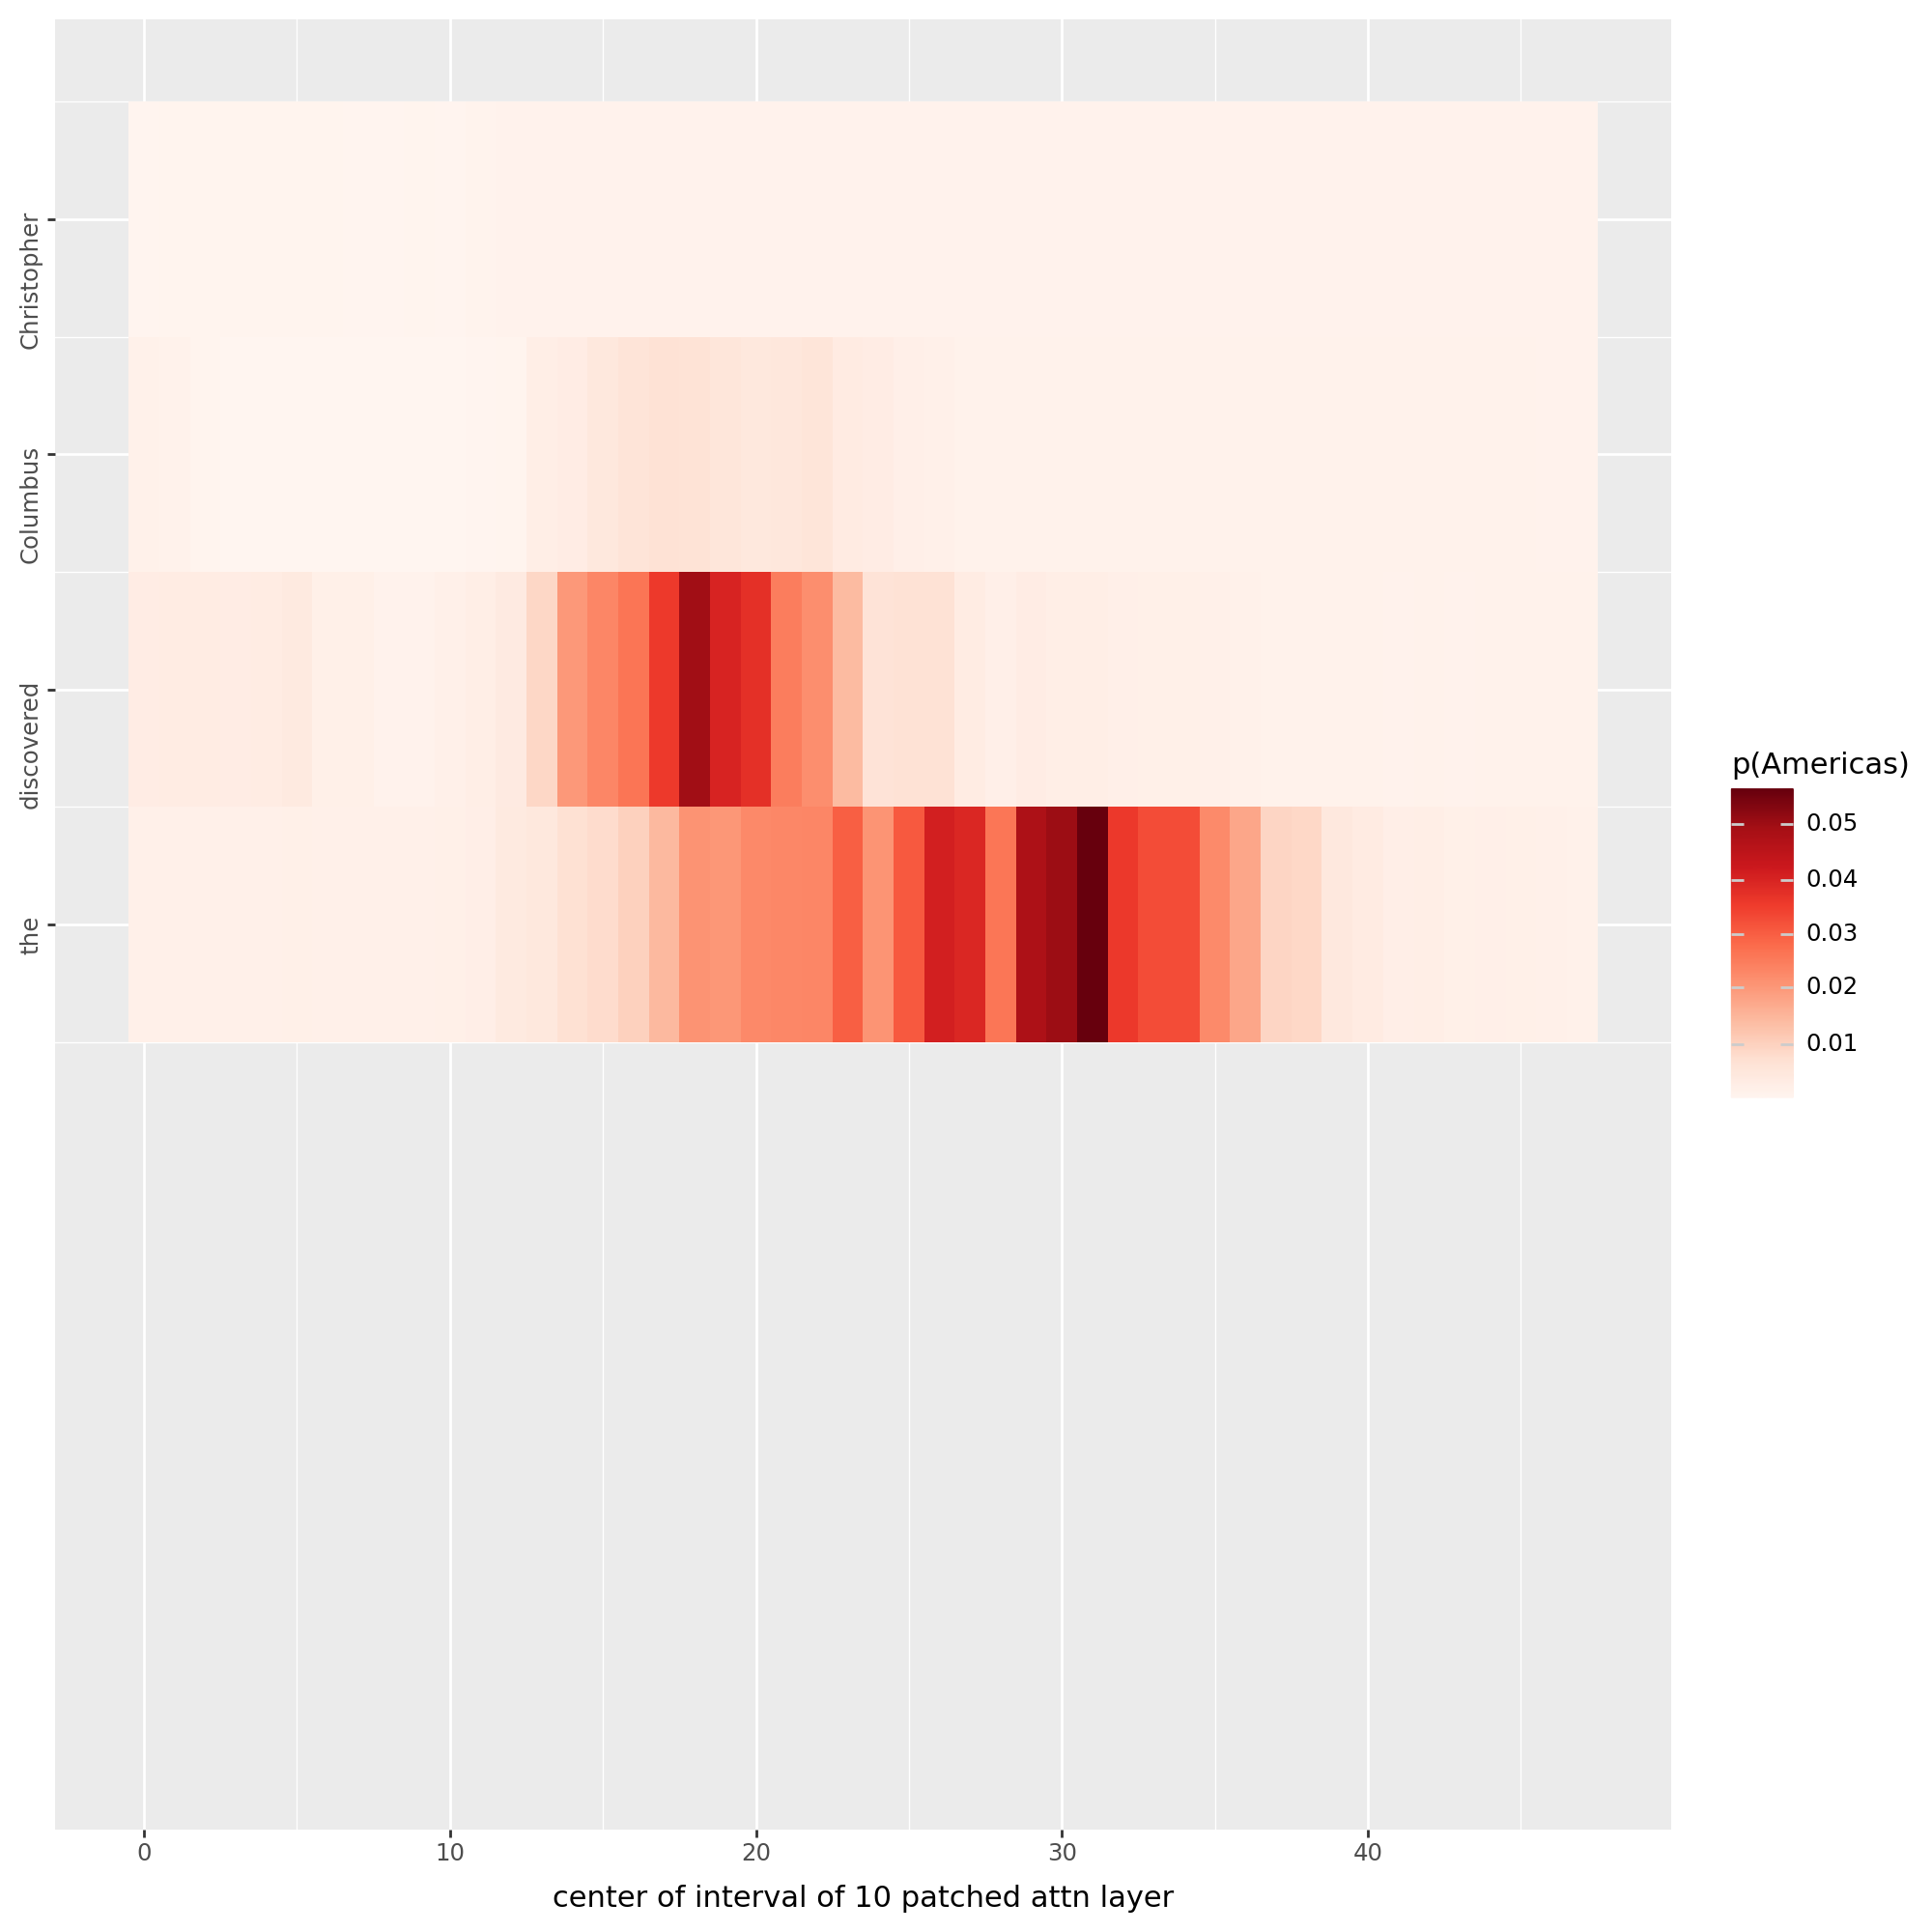

In [36]:
file_name = 'sent5'
name = "p(Americas)"
custom_labels =  ['Christopher', 'Columbus', 'discovered', 'the']
token = tokenizer.encode(" Americas")[0]
base = tokenizer(sentence, return_tensors="pt").to(device)

plot(token, name, file_name, custom_labels, unit_locations)

# Zadanie 6

In [37]:
sentence = 'The Space Needle is in downtown'
inputs = tokenizer(sentence, return_tensors="pt").to(device)

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
print(f"Original text: {sentence}")
print(f"Tokens: {tokens}")

Original text: The Space Needle is in downtown
Tokens: ['The', 'ĠSpace', 'ĠNeed', 'le', 'Ġis', 'Ġin', 'Ġdowntown']


In [38]:
unit_locations = [0,1,2,3]
num_of_units = len(unit_locations)

In [39]:
casual_tracing(sentence, unit_locations)

The Space Needle is in downtown
Przed zaszumieniem
_Seattle             0.9763796925544739
_Bellev              0.0027682771906256676
_Portland            0.002157781505957246
,                    0.001514942036010325
_Vancouver           0.0014351324643939734
_San                 0.0013575773919001222
_Minneapolis         0.0009382683783769608
.                    0.0007443437934853137
_Tacoma              0.0006097253644838929
_Los                 0.0005885540740564466
Po zaszumieniu
_Los                 0.032942481338977814
_San                 0.03194469213485718
_Seattle             0.026176391169428825
_Toronto             0.025859203189611435
_Chicago             0.024749061092734337
_Houston             0.024224204942584038
_Atlanta             0.018664492294192314
_Austin              0.017735343426465988
_St                  0.017606759443879128
_Denver              0.01740880496799946


100%|██████████| 48/48 [01:55<00:00,  2.40s/it]
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_block_output.pdf


[0, 1, 2, 3, 4, 5, 6]


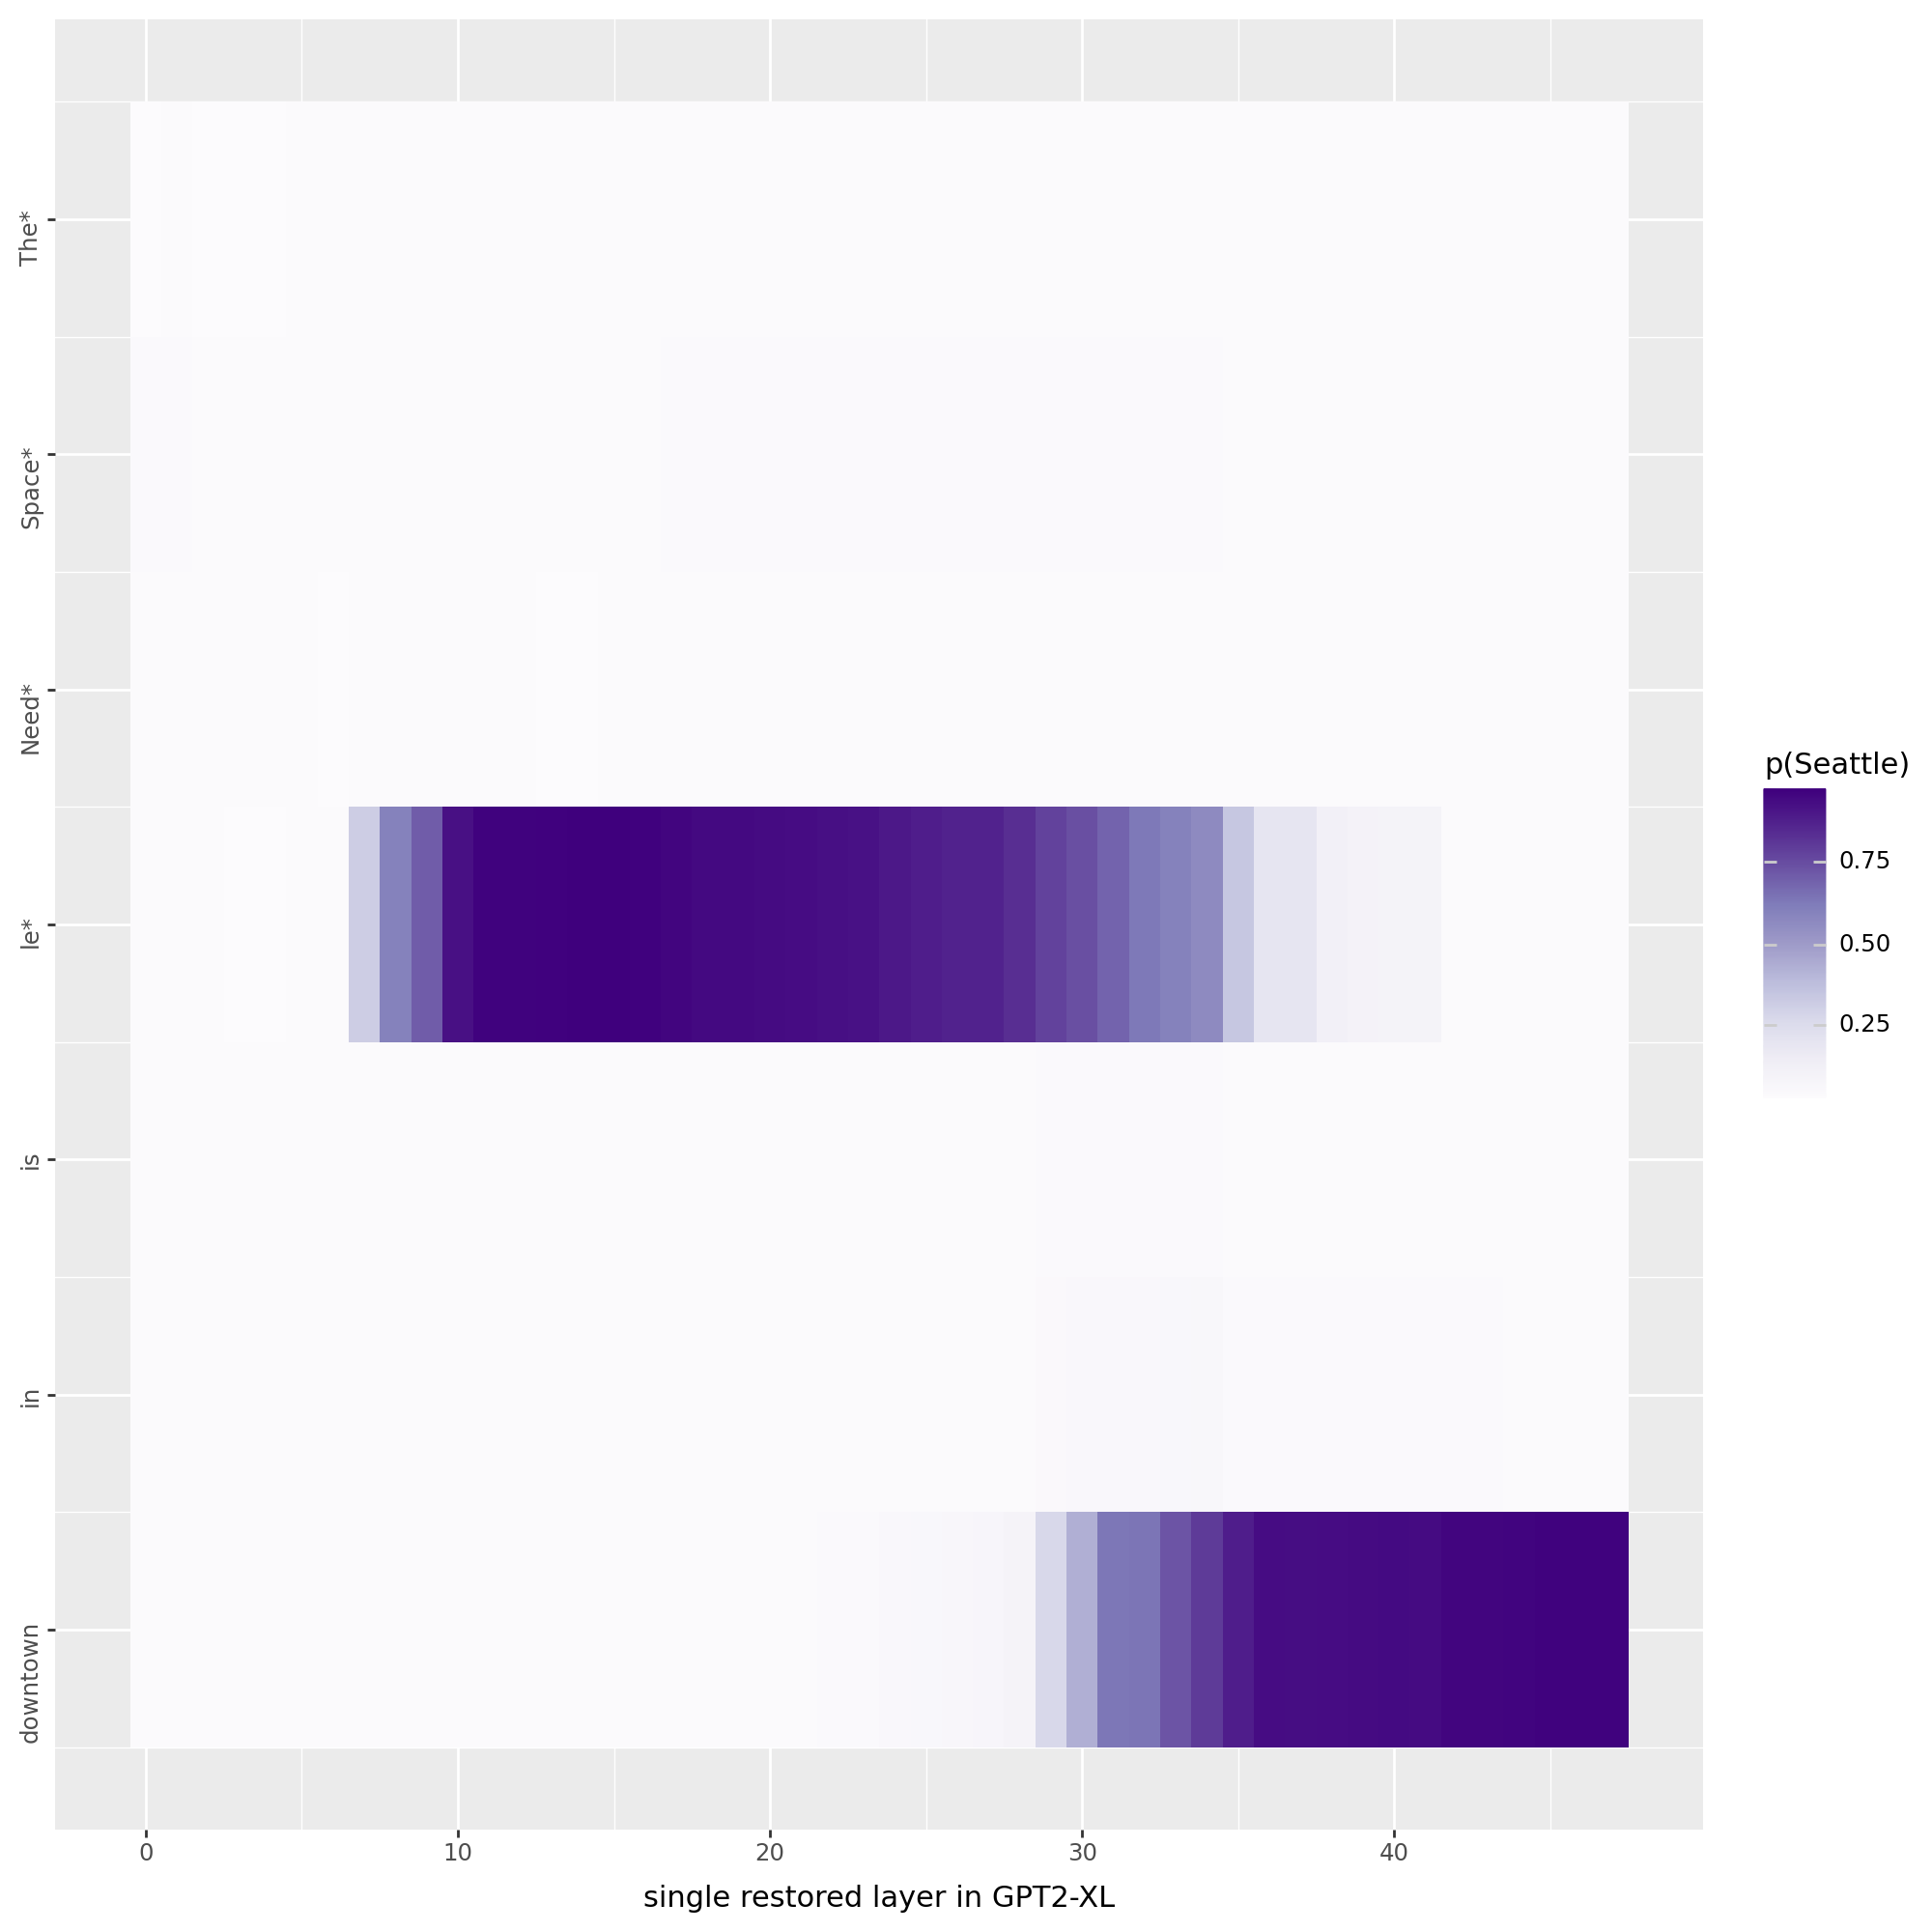

[0, 1, 2, 3, 4, 5, 6]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_mlp_activation.pdf


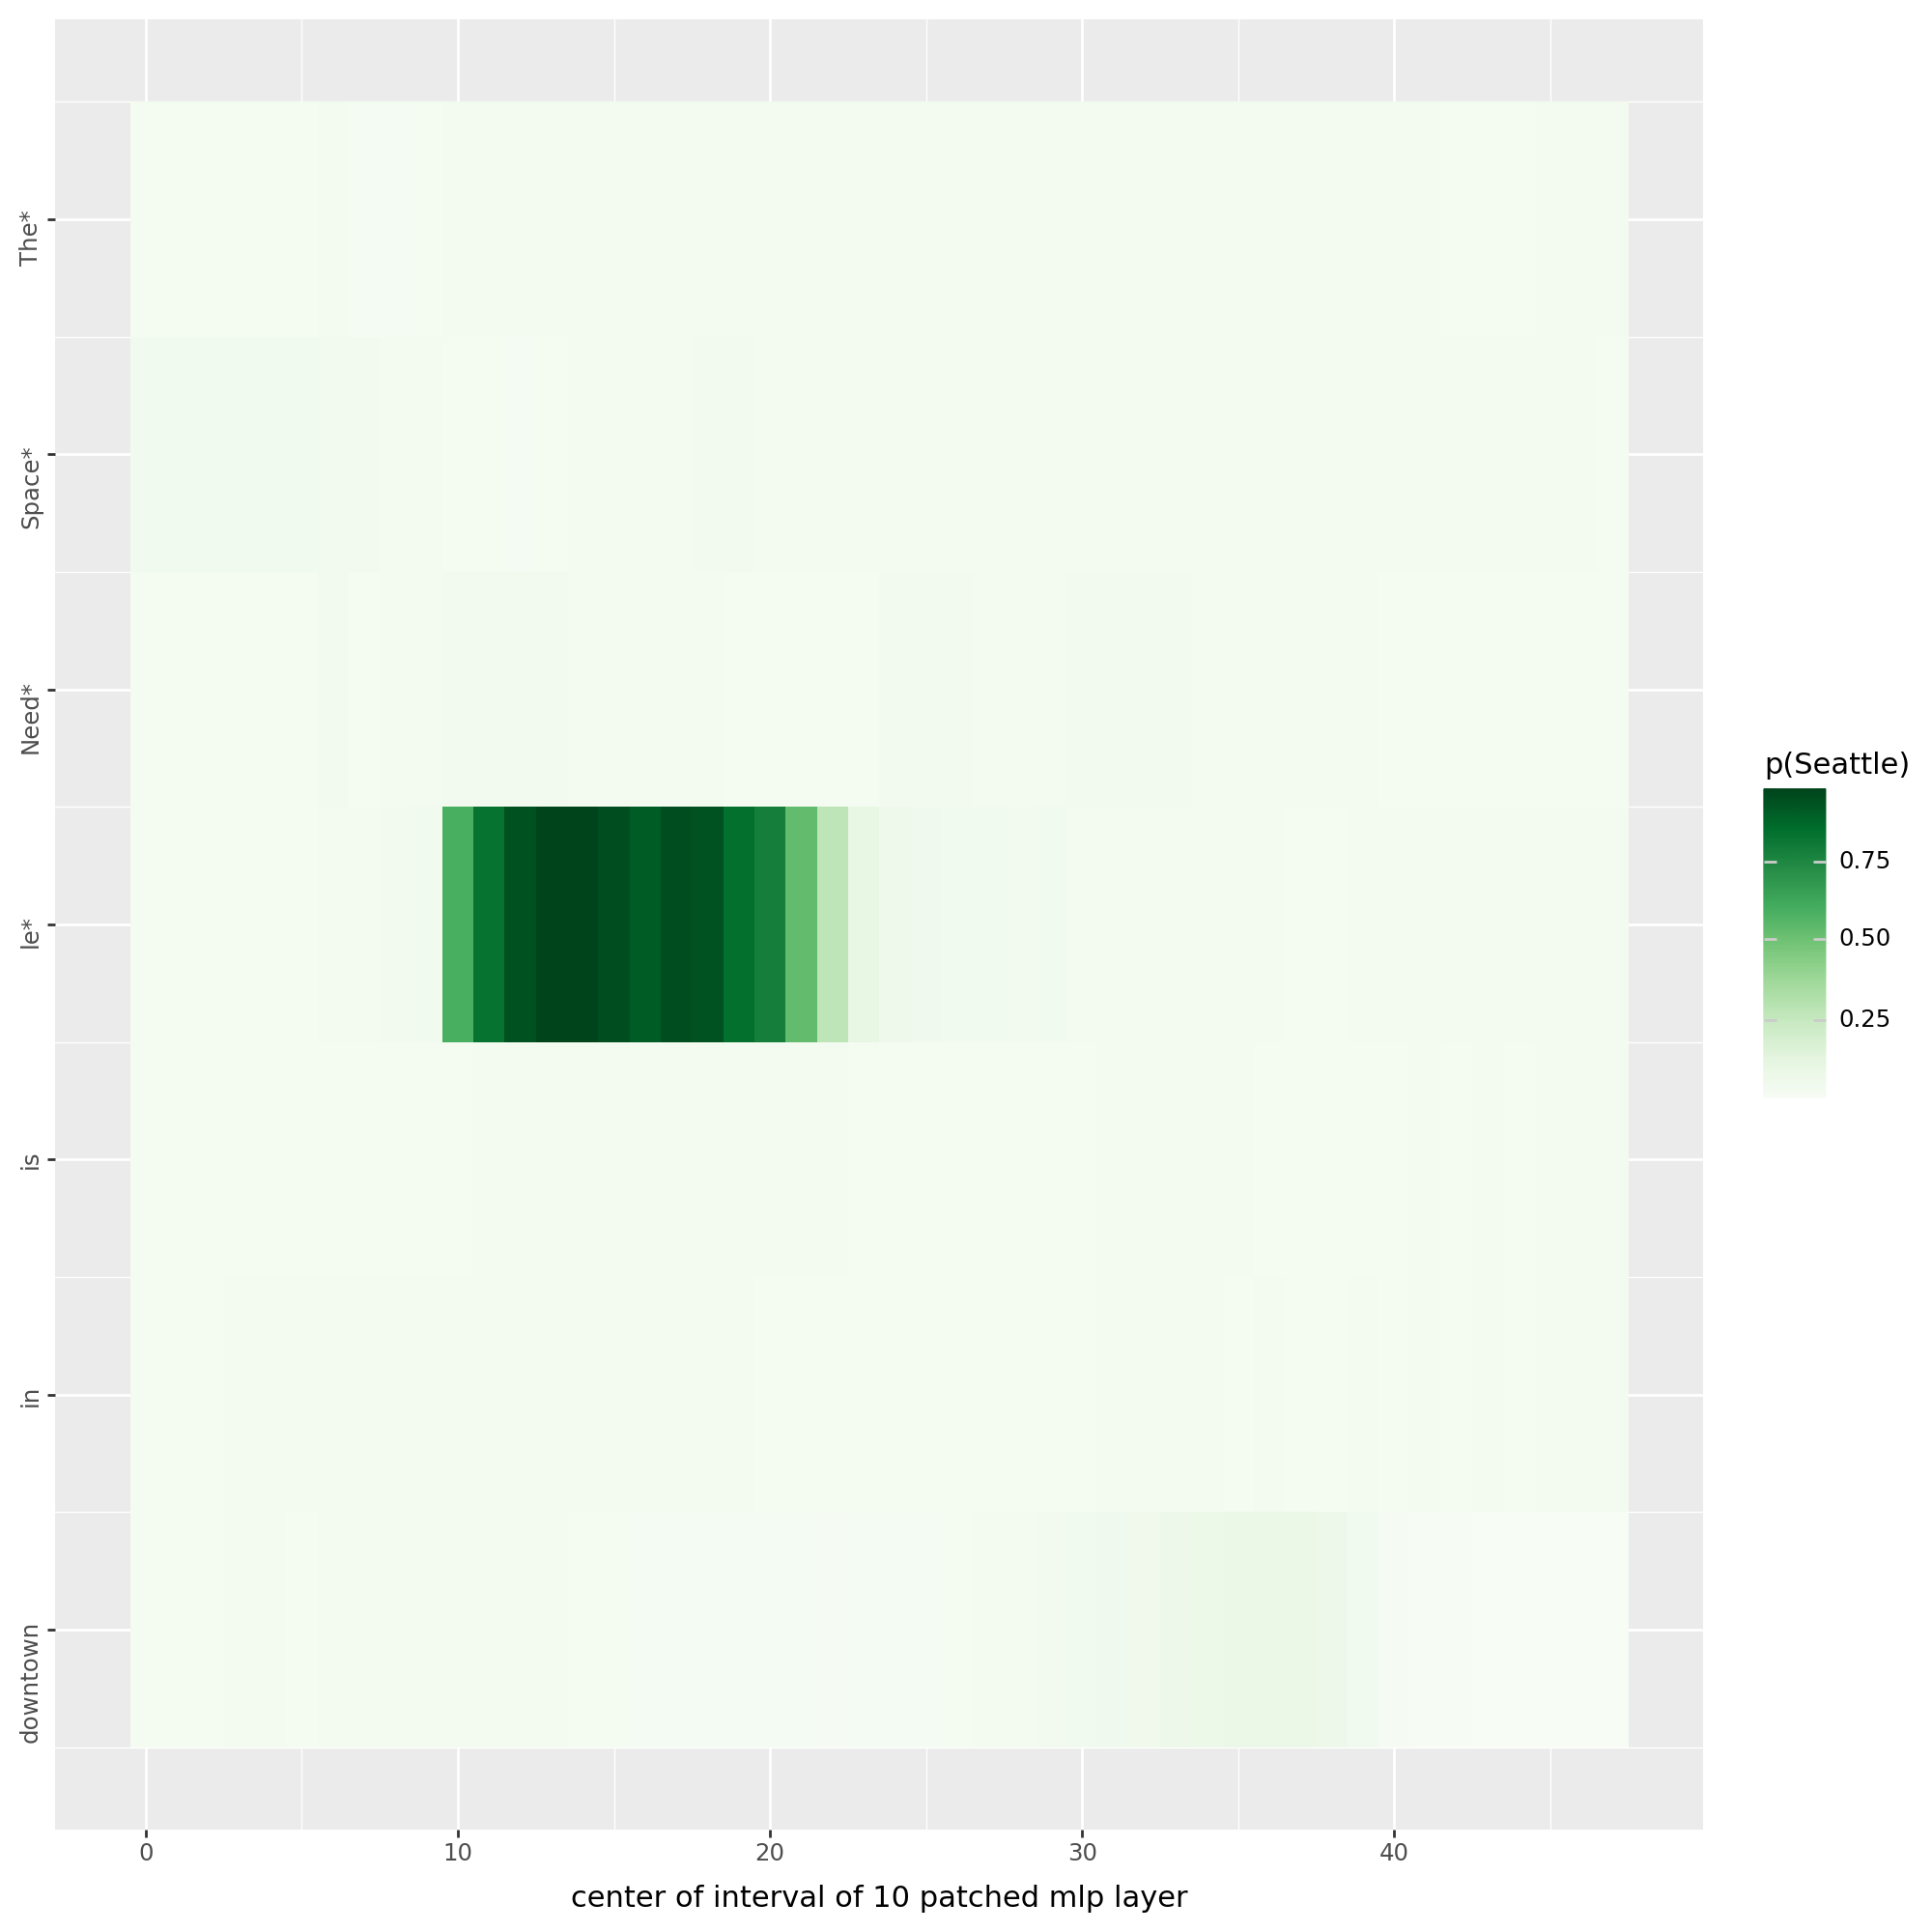

[0, 1, 2, 3, 4, 5, 6]


/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 10 in image.
/home/julita/anaconda3/envs/NLP/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./data/gptxl/sent4_attention_output.pdf


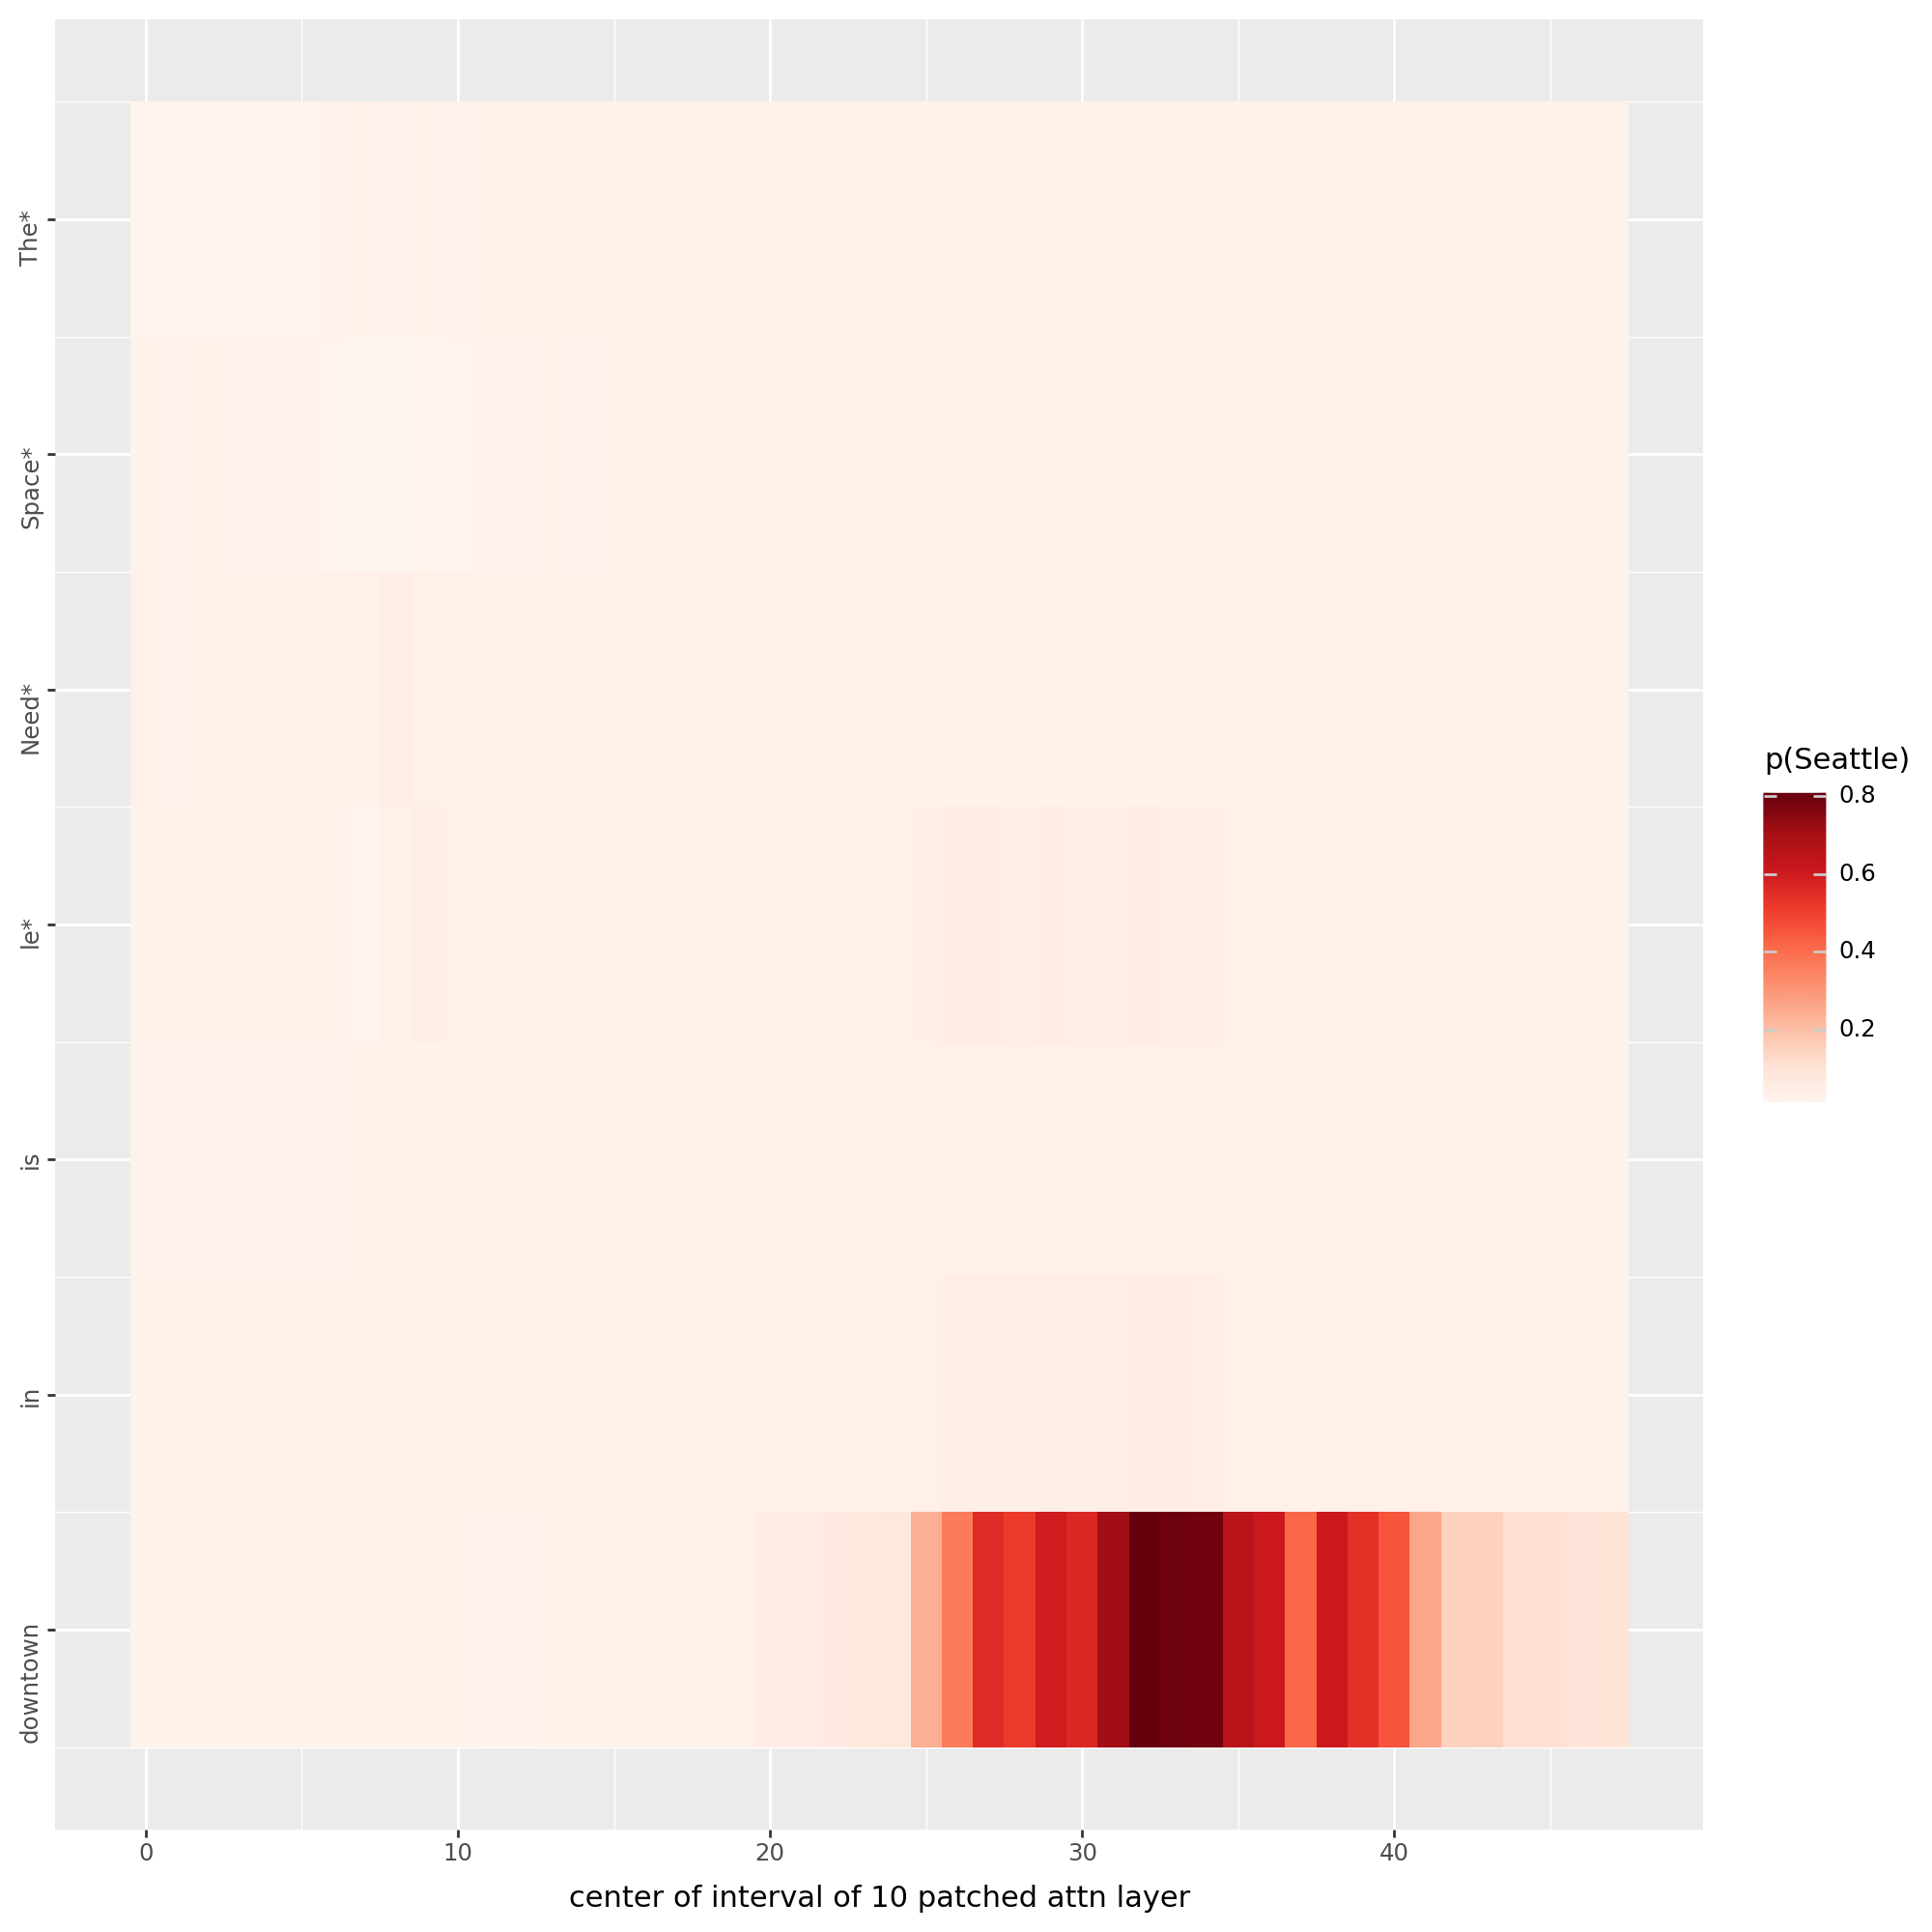

In [40]:
file_name = 'sent4'
name = "p(Seattle)"
custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
token = tokenizer.encode(" Seattle")[0]

base = tokenizer(sentence, return_tensors="pt").to(device)
plot(token, name, file_name, custom_labels, unit_locations)